# Nutrition Receipt Analyzer

## A Zero-Cost Pipeline for Automated Nutrition Analysis from Grocery Receipts

**Author:** Elham Huq, Arnav Pant, Matthew Kwon  
**Date:** December 6, 2025  
**Project:** Capstone Research Project

---

## Abstract

This notebook implements a fully local, CPU-friendly pipeline that converts grocery receipt photos into itemized macronutrient estimates and healthier swap suggestions. The system uses OCR (Tesseract) for text extraction, sentence embeddings for food matching with the USDA FoodData Central database, and rule-based logic for generating evidence-based nutritional recommendations.

**Research Questions:**
1. How accurately can item names and quantities be extracted from messy receipt photos?
2. Can lightweight text matching accurately map noisy product strings to standard USDA food entries?
3. What simple rules can produce useful and easy-to-understand swap and recipe suggestions?

**Key Contributions:**
- End-to-end pipeline from receipt photo to macro estimates with USDA citations
- Hybrid matching approach (TF-IDF + sentence embeddings + re-ranking)
- Comprehensive evaluation suite covering extraction, mapping, accuracy, and latency


In [12]:
# Configure Tesseract path for Windows
# This tells pytesseract where to find the Tesseract executable
import os

if os.name == 'nt':  # Windows
    # Common installation paths - the script will try each one
    possible_paths = [
        r'C:\Program Files\Tesseract-OCR\tesseract.exe',
        r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe',
        r'C:\Users\{}\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'.format(os.environ.get('USERNAME', ''))
    ]
    
    tesseract_found = False
    for path in possible_paths:
        if os.path.exists(path):
            pytesseract.pytesseract.tesseract_cmd = path
            print(f"✓ Configured Tesseract path: {path}")
            tesseract_found = True
            break
    
    if not tesseract_found:
        print("⚠ Tesseract not found in common locations.")
        print("Please manually set the path where you installed Tesseract:")
        print("Example: pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'")


✓ Configured Tesseract path: C:\Program Files\Tesseract-OCR\tesseract.exe


## Table of Contents

1. [Setup and Dependencies](#1-setup-and-dependencies)
2. [Data Acquisition and Preparation](#2-data-acquisition-and-preparation)
3. [OCR and Text Extraction](#3-ocr-and-text-extraction)
4. [Text Normalization and Parsing](#4-text-normalization-and-parsing)
5. [Food Matching Pipeline](#5-food-matching-pipeline)
6. [Macro Estimation and Unit Conversion](#6-macro-estimation-and-unit-conversion)
7. [Healthier Swap Suggestions](#7-healthier-swap-suggestions)
8. [Evaluation Suite](#8-evaluation-suite)
9. [Final Integration and Results](#9-final-integration-and-results)


---

## 1. Setup and Dependencies

This section installs and imports all required libraries for the pipeline.

### System Requirements:
- **Tesseract OCR** must be installed on your system (✓ You have v5.5.0 installed!)
- Python 3.8+ with pip

### Python Dependencies:
Run: `pip install -r requirements.txt`


### 2.1 Download USDA FoodData Central Database

We need to download the USDA FoodData Central database which contains nutritional information for thousands of foods.

**Steps to download:**
1. Visit: https://fdc.nal.usda.gov/download-datasets.html
2. Download the **"Foundation Foods"** CSV file (smaller, high-quality dataset)
3. Download the **"SR Legacy"** CSV file (larger, comprehensive dataset)
4. Extract the ZIP files to the `data/usda_fdc/` directory

**Required files:**
- `food.csv` - Contains food descriptions and IDs
- `food_nutrient.csv` - Contains nutrient values for each food
- `nutrient.csv` - Contains nutrient names and units

The cell below will help you check if the files are in place.


In [16]:
# Check if USDA data files are present
import os
import glob

usda_base_dir = 'data/usda_fdc/'

print("Checking for USDA FoodData Central files...\n")

# Check for extracted data directories
foundation_dir = os.path.join(usda_base_dir, 'FoodData_Central_foundation_food_csv_2025-04-24')
sr_legacy_dir = os.path.join(usda_base_dir, 'FoodData_Central_sr_legacy_food_csv_2018-04')

datasets_found = []

if os.path.exists(foundation_dir):
    print(f"✓ Found Foundation Foods dataset (2025)")
    print(f"  Path: {foundation_dir}")
    datasets_found.append(('Foundation', foundation_dir))
    
    # Check key files
    for filename in ['food.csv', 'food_nutrient.csv', 'nutrient.csv']:
        file_path = os.path.join(foundation_dir, filename)
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path) / (1024 * 1024)
            print(f"    - {filename}: {file_size:.2f} MB")
    print()

if os.path.exists(sr_legacy_dir):
    print(f"✓ Found SR Legacy dataset (2018)")
    print(f"  Path: {sr_legacy_dir}")
    datasets_found.append(('SR Legacy', sr_legacy_dir))
    
    # Check key files
    for filename in ['food.csv', 'food_nutrient.csv', 'nutrient.csv']:
        file_path = os.path.join(sr_legacy_dir, filename)
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path) / (1024 * 1024)
            print(f"    - {filename}: {file_size:.2f} MB")
    print()

if datasets_found:
    print(f"✓ Found {len(datasets_found)} USDA dataset(s)! Ready to load.")
    print("\nNote: We'll use the Foundation Foods dataset (more recent and higher quality)")
else:
    print("✗ No USDA datasets found.")
    print(f"Please download and extract to: {os.path.abspath(usda_base_dir)}")


Checking for USDA FoodData Central files...

✓ Found Foundation Foods dataset (2025)
  Path: data/usda_fdc/FoodData_Central_foundation_food_csv_2025-04-24
    - food.csv: 5.88 MB
    - food_nutrient.csv: 8.74 MB
    - nutrient.csv: 0.02 MB

✓ Found SR Legacy dataset (2018)
  Path: data/usda_fdc/FoodData_Central_sr_legacy_food_csv_2018-04
    - food.csv: 0.76 MB
    - food_nutrient.csv: 34.68 MB
    - nutrient.csv: 0.02 MB

✓ Found 2 USDA dataset(s)! Ready to load.

Note: We'll use the Foundation Foods dataset (more recent and higher quality)


### 2.2 Load and Explore USDA Data

Now we'll load the USDA CSV files into pandas DataFrames and explore their structure. This will help us understand what data is available for food matching and nutrient calculations.


In [21]:
# Load USDA FoodData Central CSV files from BOTH datasets
import pandas as pd

print("Loading USDA FoodData Central files from both datasets...\n")

# Define paths to both datasets
foundation_dir = 'data/usda_fdc/FoodData_Central_foundation_food_csv_2025-04-24/'
sr_legacy_dir = 'data/usda_fdc/FoodData_Central_sr_legacy_food_csv_2018-04/'

try:
    # Load Foundation Foods dataset (2025)
    print(f"Loading Foundation Foods dataset...")
    foundation_food_df = pd.read_csv(os.path.join(foundation_dir, 'food.csv'), low_memory=False)
    foundation_nutrient_df = pd.read_csv(os.path.join(foundation_dir, 'food_nutrient.csv'), low_memory=False)
    print(f"  ✓ Loaded {len(foundation_food_df):,} foods and {len(foundation_nutrient_df):,} nutrient values")
    
    # Load SR Legacy dataset (2018)
    print(f"\nLoading SR Legacy dataset...")
    sr_food_df = pd.read_csv(os.path.join(sr_legacy_dir, 'food.csv'), low_memory=False)
    sr_nutrient_df = pd.read_csv(os.path.join(sr_legacy_dir, 'food_nutrient.csv'), low_memory=False)
    print(f"  ✓ Loaded {len(sr_food_df):,} foods and {len(sr_nutrient_df):,} nutrient values")
    
    # Load nutrient definitions (same in both datasets, use Foundation Foods version)
    nutrient_df = pd.read_csv(os.path.join(foundation_dir, 'nutrient.csv'), low_memory=False)
    print(f"\n✓ Loaded {len(nutrient_df):,} nutrient definitions")
    
    # Combine the datasets
    print(f"\nCombining datasets...")
    food_df = pd.concat([sr_food_df, foundation_food_df], ignore_index=True)
    food_nutrient_df = pd.concat([sr_nutrient_df, foundation_nutrient_df], ignore_index=True)
    
    print(f"✓ Combined total: {len(food_df):,} foods and {len(food_nutrient_df):,} nutrient values\n")
    
    # Display basic information about each dataset
    print("=" * 60)
    print("FOOD TABLE")
    print("=" * 60)
    print(f"Total foods: {len(food_df):,}")
    print(f"Columns: {list(food_df.columns)}")
    print("\nSample foods:")
    print(food_df[['fdc_id', 'description', 'data_type']].head(10))
    
    print("\n" + "=" * 60)
    print("NUTRIENT TABLE")
    print("=" * 60)
    print(f"Total nutrients: {len(nutrient_df):,}")
    print(f"Columns: {list(nutrient_df.columns)}")
    print("\nKey nutrients we'll use:")
    key_nutrients = nutrient_df[nutrient_df['name'].isin([
        'Energy', 'Protein', 'Carbohydrate, by difference', 
        'Total lipid (fat)', 'Fiber, total dietary', 'Sugars, total including NLEA'
    ])]
    print(key_nutrients[['id', 'name', 'unit_name']])
    
    print("\n" + "=" * 60)
    print("FOOD-NUTRIENT RELATIONSHIP TABLE")
    print("=" * 60)
    print(f"Total nutrient values: {len(food_nutrient_df):,}")
    print(f"Columns: {list(food_nutrient_df.columns)}")
    print("\nSample nutrient values:")
    print(food_nutrient_df.head())
    
except FileNotFoundError as e:
    print(f"✗ Error: {e}")
    print("\nPlease ensure you've downloaded and extracted the USDA FoodData Central files.")
    print("Visit: https://fdc.nal.usda.gov/download-datasets.html")


Loading USDA FoodData Central files from both datasets...

Loading Foundation Foods dataset...
  ✓ Loaded 74,175 foods and 155,243 nutrient values

Loading SR Legacy dataset...
  ✓ Loaded 7,793 foods and 644,125 nutrient values

✓ Loaded 477 nutrient definitions

Combining datasets...
✓ Combined total: 81,968 foods and 799,368 nutrient values

FOOD TABLE
Total foods: 81,968
Columns: ['fdc_id', 'data_type', 'description', 'food_category_id', 'publication_date']

Sample foods:
   fdc_id  \
0  167512   
1  167513   
2  167514   
3  167515   
4  167516   
5  167517   
6  167518   
7  167519   
8  167520   
9  167521   

                                                                         description  \
0  Pillsbury Golden Layer Buttermilk Biscuits, Artificial Flavor, refrigerated dough   
1                           Pillsbury, Cinnamon Rolls with Icing, refrigerated dough   
2                   Kraft Foods, Shake N Bake Original Recipe, Coating for Pork, dry   
3                       

### 2.3 Preprocess and Prepare USDA Data

We'll create a simplified dataset that combines food descriptions with their key macronutrient information. 

**Our intelligent filtering strategy:**
- ✅ Keep **all SR Legacy foods** (comprehensive grocery store items)
- ✅ Keep **Foundation Foods** entries (curated complete foods)
- ❌ Exclude **agricultural samples** and **lab sub-samples** (not useful for receipt matching)

This gives us ~8,000+ real foods that people actually buy at grocery stores!


In [22]:
# Preprocess USDA data: create a unified food database with macronutrients
print("Preprocessing USDA data...\n")

# Get nutrient IDs for key macronutrients
# Common nutrient IDs (these are standard in USDA FDC):
# 1008 - Energy (kcal)
# 1003 - Protein (g)
# 1005 - Carbohydrate (g)
# 1004 - Total fat (g)
# 1079 - Fiber (g)
# 2000 - Sugars (g)

nutrient_mapping = {
    1008: 'calories',
    1003: 'protein_g',
    1005: 'carbs_g',
    1004: 'fat_g',
    1079: 'fiber_g',
    2000: 'sugars_g'
}

# Pivot the food_nutrient table to get nutrients as columns
print("Creating wide-format nutrient table...")
nutrients_wide = food_nutrient_df[food_nutrient_df['nutrient_id'].isin(nutrient_mapping.keys())].copy()
nutrients_wide['nutrient_name'] = nutrients_wide['nutrient_id'].map(nutrient_mapping)

# Pivot to wide format
nutrients_pivot = nutrients_wide.pivot_table(
    index='fdc_id',
    columns='nutrient_name',
    values='amount',
    aggfunc='first'  # Take first value if duplicates exist
).reset_index()

# Merge with food descriptions
usda_foods = food_df.merge(nutrients_pivot, on='fdc_id', how='inner')

# Keep only relevant columns
columns_to_keep = ['fdc_id', 'description', 'data_type', 'calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugars_g']
usda_foods = usda_foods[[col for col in columns_to_keep if col in usda_foods.columns]]

# Fill NaN values with 0 for missing nutrients
nutrient_cols = ['calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugars_g']
for col in nutrient_cols:
    if col in usda_foods.columns:
        usda_foods[col] = usda_foods[col].fillna(0)

print(f"Before filtering: {len(usda_foods):,} foods")

# INTELLIGENT FILTERING: Keep only useful foods for receipt matching
# 1. Keep ALL sr_legacy_food entries (complete grocery store foods)
# 2. Keep foundation_food entries (curated complete foods)
# 3. EXCLUDE agricultural_acquisition and sub_sample_food (lab samples)
useful_data_types = ['sr_legacy_food', 'foundation_food']
usda_foods = usda_foods[usda_foods['data_type'].isin(useful_data_types)].copy()

print(f"After filtering for useful food types: {len(usda_foods):,} foods")

# Also filter out foods with no nutritional data at all
usda_foods = usda_foods[
    (usda_foods['calories'] > 0) | 
    (usda_foods['protein_g'] > 0) | 
    (usda_foods['carbs_g'] > 0)
].copy()

print(f"After removing foods with no nutrient data: {len(usda_foods):,} foods")

# Create a normalized description for matching (lowercase, clean)
usda_foods['description_normalized'] = usda_foods['description'].str.lower().str.strip()

print(f"\n✓ Created unified USDA food database with {len(usda_foods):,} useful foods\n")
print("Sample of processed data:")
print(usda_foods.head(10))

print("\n" + "=" * 60)
print("Data Types Distribution:")
print(usda_foods['data_type'].value_counts())

print("\n" + "=" * 60)
print("Summary Statistics:")
print(usda_foods[nutrient_cols].describe())


Preprocessing USDA data...

Creating wide-format nutrient table...
Before filtering: 13,634 foods
After filtering for useful food types: 8,194 foods
After removing foods with no nutrient data: 8,165 foods

✓ Created unified USDA food database with 8,165 useful foods

Sample of processed data:
   fdc_id  \
0  167512   
1  167513   
2  167514   
3  167515   
4  167516   
5  167517   
6  167518   
7  167519   
8  167520   
9  167521   

                                                                         description  \
0  Pillsbury Golden Layer Buttermilk Biscuits, Artificial Flavor, refrigerated dough   
1                           Pillsbury, Cinnamon Rolls with Icing, refrigerated dough   
2                   Kraft Foods, Shake N Bake Original Recipe, Coating for Pork, dry   
3                                     George Weston Bakeries, Thomas English Muffins   
4                                         Waffles, buttermilk, frozen, ready-to-heat   
5                                 

### 2.4 Sample Receipt Images

For this project, we need 5-10 sample receipt images from different grocery stores. 

**How to collect receipts:**
1. Take clear photos of grocery receipts (ensure text is legible)
2. Save them as JPG or PNG files in the `data/receipts/` directory
3. Use diverse receipts (different stores, different items)

**Tips for good receipt photos:**
- Good lighting (avoid shadows)
- Flat surface (no wrinkles or folds)
- High contrast (dark text on light background)
- Full receipt visible in frame

The cell below will check what receipt images you have available.


✓ Found 40 images in data/receipts/images

Total: 40 receipt images found

Receipt files:
  1. 0.jpg (125.4 KB)
  2. 1.jpg (569.4 KB)
  3. 10.jpg (737.2 KB)
  4. 11.jpg (386.1 KB)
  5. 12.jpg (402.4 KB)
  6. 13.jpg (240.9 KB)
  7. 14.jpg (3016.8 KB)
  8. 15.jpg (345.2 KB)
  9. 16.jpg (353.9 KB)
  10. 17.jpg (373.0 KB)
  11. 18.jpg (545.0 KB)
  12. 19.jpg (368.4 KB)
  13. 2.jpg (292.3 KB)
  14. 3.jpg (320.6 KB)
  15. 4.jpg (236.1 KB)
  16. 5.jpg (5270.4 KB)
  17. 6.JPG (985.4 KB)
  18. 7.jpg (353.9 KB)
  19. 8.jpg (268.4 KB)
  20. 9.jpg (266.8 KB)
  21. 0.jpg (125.4 KB)
  22. 1.jpg (569.4 KB)
  23. 10.jpg (737.2 KB)
  24. 11.jpg (386.1 KB)
  25. 12.jpg (402.4 KB)
  26. 13.jpg (240.9 KB)
  27. 14.jpg (3016.8 KB)
  28. 15.jpg (345.2 KB)
  29. 16.jpg (353.9 KB)
  30. 17.jpg (373.0 KB)
  31. 18.jpg (545.0 KB)
  32. 19.jpg (368.4 KB)
  33. 2.jpg (292.3 KB)
  34. 3.jpg (320.6 KB)
  35. 4.jpg (236.1 KB)
  36. 5.jpg (5270.4 KB)
  37. 6.JPG (985.4 KB)
  38. 7.jpg (353.9 KB)
  39. 8.jpg (268.4 KB

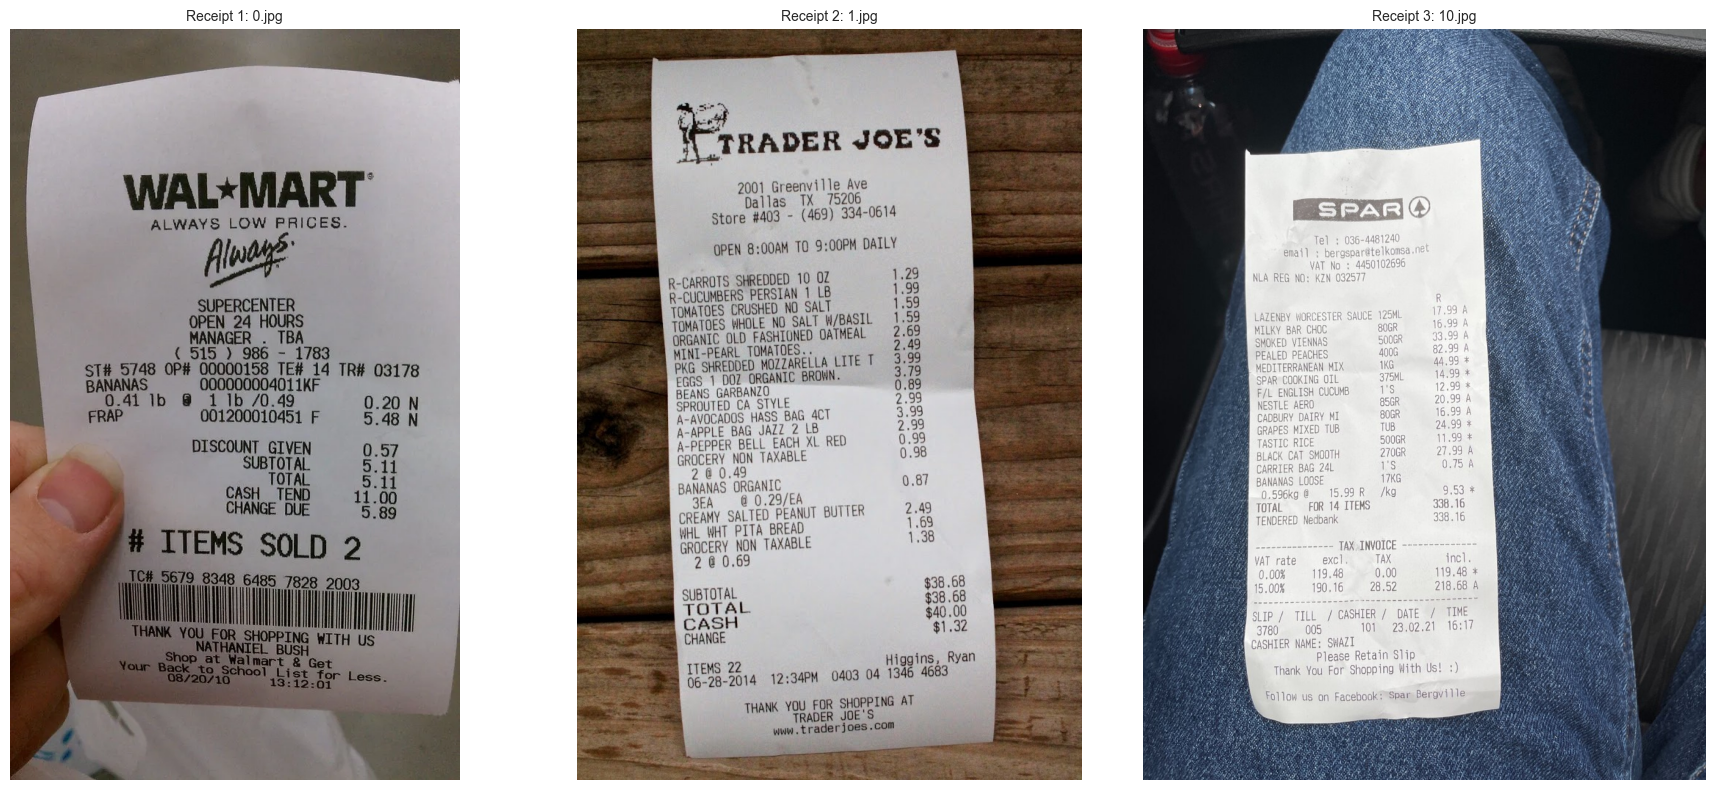

In [24]:
# Check for receipt images and display them
from PIL import Image
import matplotlib.pyplot as plt

# Check both root directory and images subdirectory
receipts_dir = 'data/receipts/'
receipt_files = []

# Check for images in subdirectory (Kaggle dataset structure)
images_subdir = os.path.join(receipts_dir, 'images')
if os.path.exists(images_subdir):
    receipt_files += glob.glob(os.path.join(images_subdir, '*.jpg'))
    receipt_files += glob.glob(os.path.join(images_subdir, '*.JPG'))
    receipt_files += glob.glob(os.path.join(images_subdir, '*.jpeg'))
    receipt_files += glob.glob(os.path.join(images_subdir, '*.png'))
    print(f"✓ Found {len(receipt_files)} images in {images_subdir}")

# Also check root receipts directory
root_images = glob.glob(os.path.join(receipts_dir, '*.jpg')) + \
              glob.glob(os.path.join(receipts_dir, '*.jpeg')) + \
              glob.glob(os.path.join(receipts_dir, '*.png'))
if root_images:
    receipt_files += root_images
    print(f"✓ Found {len(root_images)} images in {receipts_dir}")

print(f"\nTotal: {len(receipt_files)} receipt images found\n")

if receipt_files:
    print("Receipt files:")
    for i, receipt_path in enumerate(receipt_files, 1):
        file_size = os.path.getsize(receipt_path) / 1024  # KB
        print(f"  {i}. {os.path.basename(receipt_path)} ({file_size:.1f} KB)")
    
    # Display the first few receipts
    num_to_display = min(3, len(receipt_files))
    if num_to_display > 0:
        print(f"\nDisplaying first {num_to_display} receipt(s):")
        
        fig, axes = plt.subplots(1, num_to_display, figsize=(6*num_to_display, 8))
        if num_to_display == 1:
            axes = [axes]
        
        for i, receipt_path in enumerate(receipt_files[:num_to_display]):
            img = Image.open(receipt_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Receipt {i+1}: {os.path.basename(receipt_path)}", fontsize=10)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("⚠ No receipt images found.")
    print(f"Please add receipt images (.jpg, .jpeg, or .png) to: {os.path.abspath(receipts_dir)}")
    print("\nYou can:")
    print("  1. Take photos of your own grocery receipts")
    print("  2. Use sample receipt images from online sources")
    print("  3. Create synthetic receipts for testing")


### 2.5 Ground Truth Annotations

For evaluation, we need ground truth annotations for at least 3 receipts. This JSON file will contain:
- The actual items on the receipt (as they appear after OCR)
- The correct USDA food matches
- Quantity and unit information

**The ground truth file structure:**
```json
{
  "receipt_1.jpg": {
    "items": [
      {
        "item_name": "Organic Bananas",
        "quantity": 2.5,
        "unit": "lb",
        "usda_fdc_id": 173944,
        "usda_description": "Bananas, raw"
      }
    ]
  }
}
```

The cell below will help you create or check your ground truth file.


In [20]:
# Check or create ground truth annotations file
import json

ground_truth_path = 'data/ground_truth.json'

if os.path.exists(ground_truth_path):
    # Load and display existing ground truth
    with open(ground_truth_path, 'r') as f:
        ground_truth = json.load(f)
    
    print(f"✓ Found ground truth file with {len(ground_truth)} annotated receipt(s)\n")
    print("Annotated receipts:")
    for receipt_name, data in ground_truth.items():
        num_items = len(data.get('items', []))
        print(f"  - {receipt_name}: {num_items} items")
    
    print("\nSample annotation:")
    first_receipt = list(ground_truth.keys())[0]
    first_items = ground_truth[first_receipt]['items'][:2]
    print(json.dumps({first_receipt: {'items': first_items}}, indent=2))
    
else:
    # Create a template ground truth file
    print("⚠ Ground truth file not found. Creating template...\n")
    
    template = {
        "example_receipt.jpg": {
            "items": [
                {
                    "item_name": "Organic Bananas",
                    "quantity": 2.5,
                    "unit": "lb",
                    "usda_fdc_id": 173944,
                    "usda_description": "Bananas, raw",
                    "notes": "Example item - replace with actual receipt data"
                },
                {
                    "item_name": "Whole Wheat Bread",
                    "quantity": 1,
                    "unit": "loaf",
                    "usda_fdc_id": 172687,
                    "usda_description": "Bread, whole-wheat, commercially prepared",
                    "notes": "Example item - replace with actual receipt data"
                }
            ]
        }
    }
    
    with open(ground_truth_path, 'w') as f:
        json.dump(template, f, indent=2)
    
    print(f"✓ Created template ground truth file at: {ground_truth_path}")
    print("\nTemplate structure:")
    print(json.dumps(template, indent=2))
    print("\n" + "="*60)
    print("TODO: Edit this file to add annotations for your actual receipts!")
    print("For each receipt, manually:")
    print("  1. Extract item names from the receipt")
    print("  2. Find the correct USDA FDC ID using the usda_foods DataFrame")
    print("  3. Record quantity and unit information")
    print("="*60)


⚠ Ground truth file not found. Creating template...

✓ Created template ground truth file at: data/ground_truth.json

Template structure:
{
  "example_receipt.jpg": {
    "items": [
      {
        "item_name": "Organic Bananas",
        "quantity": 2.5,
        "unit": "lb",
        "usda_fdc_id": 173944,
        "usda_description": "Bananas, raw",
        "notes": "Example item - replace with actual receipt data"
      },
      {
        "item_name": "Whole Wheat Bread",
        "quantity": 1,
        "unit": "loaf",
        "usda_fdc_id": 172687,
        "usda_description": "Bread, whole-wheat, commercially prepared",
        "notes": "Example item - replace with actual receipt data"
      }
    ]
  }
}

TODO: Edit this file to add annotations for your actual receipts!
For each receipt, manually:
  1. Extract item names from the receipt
  2. Find the correct USDA FDC ID using the usda_foods DataFrame
  3. Record quantity and unit information


### 2.6 Parse Kaggle Receipt Dataset Annotations

The dataset includes XML annotations with ground truth text for each receipt item. Let's parse these annotations to create our ground truth data.


In [25]:
import xml.etree.ElementTree as ET

def parse_receipt_annotations(xml_path):
    """
    Parse the Kaggle receipt dataset XML annotations.
    
    Args:
        xml_path (str): Path to annotations.xml file
        
    Returns:
        dict: Dictionary mapping image names to their annotations
    """
    annotations = {}
    
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # Parse each image
        for image in root.findall('.//image'):
            image_id = image.get('id')
            image_name = image.get('name')
            
            # Extract annotations for this image
            image_data = {
                'shop': None,
                'items': [],
                'total': None,
                'date_time': None
            }
            
            # Find all boxes in this image
            for box in image.findall('.//box'):
                label = box.get('label')
                text_attr = box.find('.//attribute[@name="text"]')
                
                if text_attr is not None:
                    text = text_attr.text if text_attr.text else ""
                    
                    if label == 'shop':
                        image_data['shop'] = text
                    elif label == 'item':
                        image_data['items'].append(text)
                    elif label == 'total':
                        image_data['total'] = text
                    elif label == 'date_time':
                        image_data['date_time'] = text
            
            if image_name:
                annotations[os.path.basename(image_name)] = image_data
        
        return annotations
    
    except Exception as e:
        print(f"Error parsing XML: {e}")
        return {}

# Parse the Kaggle dataset annotations
annotations_path = 'data/receipts/annotations.xml'

if os.path.exists(annotations_path):
    print("Parsing Kaggle receipt dataset annotations...\n")
    kaggle_annotations = parse_receipt_annotations(annotations_path)
    
    print(f"✓ Parsed annotations for {len(kaggle_annotations)} receipts\n")
    
    # Show sample
    if kaggle_annotations:
        sample_receipt = list(kaggle_annotations.keys())[0]
        sample_data = kaggle_annotations[sample_receipt]
        
        print(f"Sample annotation for {sample_receipt}:")
        print(f"  Shop: {sample_data['shop']}")
        print(f"  Date/Time: {sample_data['date_time']}")
        print(f"  Total: {sample_data['total']}")
        print(f"  Items ({len(sample_data['items'])}):")
        for i, item in enumerate(sample_data['items'][:5], 1):
            print(f"    {i}. {item}")
        if len(sample_data['items']) > 5:
            print(f"    ... and {len(sample_data['items']) - 5} more items")
    
    # Statistics
    total_items = sum(len(data['items']) for data in kaggle_annotations.values())
    print(f"\n" + "=" * 60)
    print(f"Dataset Statistics:")
    print(f"  Total receipts: {len(kaggle_annotations)}")
    print(f"  Total items: {total_items}")
    print(f"  Average items per receipt: {total_items / len(kaggle_annotations):.1f}")
else:
    print(f"Annotations file not found at: {annotations_path}")
    print("Skipping Kaggle dataset parsing.")


Parsing Kaggle receipt dataset annotations...

✓ Parsed annotations for 20 receipts

Sample annotation for 0.jpg:
  Shop: WALMART
  Date/Time: 08/20/10 13:12:01
  Total: TOTAL 5.11
  Items (2):
    1. FRAP 001200010451 F 5.48 N
    2. BANANAS 000000004011KF 0.41 lb @ 1 lb /0.49 0.20 N

Dataset Statistics:
  Total receipts: 20
  Total items: 176
  Average items per receipt: 8.8


### 2.7 Create Ground Truth from Kaggle Dataset

Now we'll convert the Kaggle annotations into our ground truth format. We'll need to manually map receipt items to USDA foods, but the dataset gives us the text to work with!


In [26]:
# Create initial ground truth structure from Kaggle annotations
ground_truth_path = 'data/ground_truth.json'

if 'kaggle_annotations' in locals() and kaggle_annotations:
    print("Creating ground truth structure from Kaggle dataset...\n")
    
    # Take first 3-5 receipts for ground truth
    sample_receipts = list(kaggle_annotations.keys())[:5]
    
    ground_truth_data = {}
    
    for receipt_name in sample_receipts:
        ann = kaggle_annotations[receipt_name]
        
        # Create ground truth entry for this receipt
        ground_truth_data[receipt_name] = {
            'shop': ann['shop'],
            'date': ann['date_time'],
            'total': ann['total'],
            'items': []
        }
        
        # Add items (we'll need to manually match these to USDA foods later)
        for item_text in ann['items']:
            # Parse item text to extract item name (remove codes, prices, etc.)
            # Example: "BANANAS 000000004011KF 0.41 lb @ 1 lb /0.49 0.20 N" → "BANANAS"
            cleaned_item = item_text.split()[0] if item_text else ""
            
            ground_truth_data[receipt_name]['items'].append({
                'item_name': cleaned_item,
                'original_text': item_text,
                'quantity': None,  # TODO: Parse from text
                'unit': None,      # TODO: Parse from text
                'usda_fdc_id': None,  # TODO: Manually match to USDA food
                'usda_description': None,  # TODO: Fill in after matching
                'notes': "Extracted from Kaggle dataset - needs USDA matching"
            })
    
    # Save ground truth
    with open(ground_truth_path, 'w') as f:
        json.dump(ground_truth_data, f, indent=2)
    
    print(f"✓ Created ground truth file with {len(ground_truth_data)} receipts")
    print(f"  Total items to match: {sum(len(r['items']) for r in ground_truth_data.values())}")
    print(f"\n" + "=" * 60)
    print("Sample ground truth entry:")
    print(json.dumps({sample_receipts[0]: ground_truth_data[sample_receipts[0]]}, indent=2)[:500] + "...")
    
    print(f"\n" + "=" * 60)
    print("NEXT STEPS:")
    print("  1. Open data/ground_truth.json")
    print("  2. For each item, manually find matching USDA food:")
    print("     - Search usda_foods DataFrame for similar foods")
    print("     - Fill in usda_fdc_id and usda_description")
    print("  3. Parse quantity and unit from original_text")
    print("  4. This ground truth will be used to train the re-ranker!")
else:
    print("No Kaggle annotations available. Using default ground truth template.")
    
    # Load or create default template
    if os.path.exists(ground_truth_path):
        with open(ground_truth_path, 'r') as f:
            ground_truth_data = json.load(f)
        print(f"✓ Loaded existing ground truth with {len(ground_truth_data)} receipts")
    else:
        print("Creating template ground truth file...")
        # Create template as before
        template = {
            "example_receipt.jpg": {
                "items": [
                    {
                        "item_name": "Organic Bananas",
                        "quantity": 2.5,
                        "unit": "lb",
                        "usda_fdc_id": 173944,
                        "usda_description": "Bananas, raw"
                    }
                ]
            }
        }
        with open(ground_truth_path, 'w') as f:
            json.dump(template, f, indent=2)
        print(f"✓ Created template at: {ground_truth_path}")


Creating ground truth structure from Kaggle dataset...

✓ Created ground truth file with 5 receipts
  Total items to match: 46

Sample ground truth entry:
{
  "0.jpg": {
    "shop": "WALMART",
    "date": "08/20/10 13:12:01",
    "total": "TOTAL 5.11",
    "items": [
      {
        "item_name": "FRAP",
        "original_text": "FRAP 001200010451 F 5.48 N",
        "quantity": null,
        "unit": null,
        "usda_fdc_id": null,
        "usda_description": null,
        "notes": "Extracted from Kaggle dataset - needs USDA matching"
      },
      {
        "item_name": "BANANAS",
        "original_text": "BANANAS 000000004011KF 0.41 lb @ 1 lb ...

NEXT STEPS:
  1. Open data/ground_truth.json
  2. For each item, manually find matching USDA food:
     - Search usda_foods DataFrame for similar foods
     - Fill in usda_fdc_id and usda_description
  3. Parse quantity and unit from original_text
  4. This ground truth will be used to train the re-ranker!


In [10]:
# Core Libraries
import os
import re
import json
import time
from pathlib import Path
from typing import List, Dict, Tuple, Optional

# Data Processing
import pandas as pd
import numpy as np

# OCR
import pytesseract
from PIL import Image

# Machine Learning & NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Progress tracking
from tqdm.auto import tqdm

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful!")


✓ All imports successful!


### 3.1 Load Receipt Images

First, we'll create a simple function to load receipt images using PIL (Pillow). This will handle different image formats and prepare them for OCR processing.


Testing load_receipt_image function:

✓ Loaded image: 0.jpg
  Size: 612x1023 pixels
  Mode: RGB


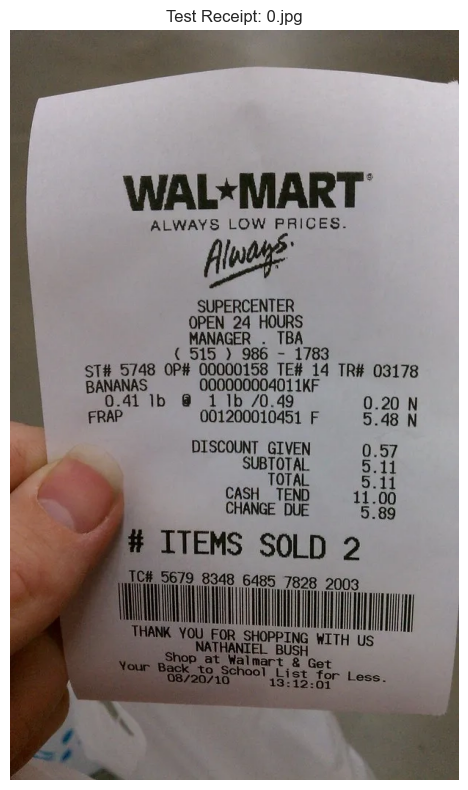

In [27]:
def load_receipt_image(image_path):
    """
    Load a receipt image from the given path.
    
    Args:
        image_path (str): Path to the receipt image file
        
    Returns:
        PIL.Image: The loaded image
    """
    try:
        img = Image.open(image_path)
        print(f"✓ Loaded image: {os.path.basename(image_path)}")
        print(f"  Size: {img.size[0]}x{img.size[1]} pixels")
        print(f"  Mode: {img.mode}")
        return img
    except Exception as e:
        print(f"✗ Error loading image: {e}")
        return None

# Test the function with the first available receipt (if any)
if receipt_files:
    print("Testing load_receipt_image function:\n")
    test_image = load_receipt_image(receipt_files[0])
    
    if test_image:
        # Display the image
        plt.figure(figsize=(6, 8))
        plt.imshow(test_image)
        plt.title(f"Test Receipt: {os.path.basename(receipt_files[0])}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
else:
    print("No receipt images available for testing.")
    print("Please add receipt images to data/receipts/ to test OCR functionality.")


### 3.2 Extract Text from Receipt (Basic OCR)

Now we'll implement the core OCR function using Tesseract. This extracts all text from the receipt image as a single string.


In [28]:
def extract_text_from_receipt(image):
    """
    Extract text from a receipt image using Tesseract OCR.
    
    Args:
        image (PIL.Image): The receipt image
        
    Returns:
        str: Extracted text from the receipt
    """
    try:
        # Use pytesseract to extract text
        text = pytesseract.image_to_string(image)
        return text
    except Exception as e:
        print(f"✗ OCR Error: {e}")
        return ""

# Test OCR on the first receipt (if available)
if receipt_files:
    print("Testing OCR on first receipt:\n")
    print("=" * 70)
    
    test_image = load_receipt_image(receipt_files[0])
    if test_image:
        extracted_text = extract_text_from_receipt(test_image)
        
        print("\nEXTRACTED TEXT:")
        print("=" * 70)
        print(extracted_text)
        print("=" * 70)
        
        # Show some statistics
        lines = extracted_text.strip().split('\n')
        non_empty_lines = [line for line in lines if line.strip()]
        
        print(f"\nOCR Statistics:")
        print(f"  Total characters: {len(extracted_text)}")
        print(f"  Total lines: {len(lines)}")
        print(f"  Non-empty lines: {len(non_empty_lines)}")
else:
    print("No receipt images available for OCR testing.")
    print("Please add receipt images to data/receipts/")


Testing OCR on first receipt:

✓ Loaded image: 0.jpg
  Size: 612x1023 pixels
  Mode: RGB

EXTRACTED TEXT:
WAL*MART

ALWAYS LOW PRICES.

woe

SUPERCENTER
OPEN 24 HOURS
MANAGER . TBA
(515 ) 986 - 1783
$T# 5748 OP# 00000158 TE¥ 14 TRH 03178
BANANAS 00000000401 1kF
0.41 Ib @ 1 Ib /0.49 0.20 N
FRAP 001200010451 F 5.48 N
DISCOUNT GIVEN 0.57
‘| SUBIQIA. = 8.11
5.
y CASH TEND 1100
CHANGE DUE “5 "@g



OCR Statistics:
  Total characters: 289
  Total lines: 19
  Non-empty lines: 16


### 3.3 Test OCR on All Receipts

Let's test the OCR on all available receipt images to see how well it performs across different receipts.


In [29]:
# Test OCR on all available receipts
ocr_results = {}

if receipt_files:
    print(f"Running OCR on {len(receipt_files)} receipt(s)...\n")
    
    for i, receipt_path in enumerate(receipt_files, 1):
        receipt_name = os.path.basename(receipt_path)
        print(f"[{i}/{len(receipt_files)}] Processing: {receipt_name}")
        
        # Load and process
        img = load_receipt_image(receipt_path)
        if img:
            text = extract_text_from_receipt(img)
            ocr_results[receipt_name] = text
            
            # Show preview
            lines = [line.strip() for line in text.split('\n') if line.strip()]
            print(f"  Extracted {len(lines)} non-empty lines")
            print(f"  Preview (first 3 lines):")
            for line in lines[:3]:
                print(f"    {line[:60]}{'...' if len(line) > 60 else ''}")
            print()
    
    print(f"✓ OCR completed for {len(ocr_results)} receipt(s)")
    print(f"\nReceipt names stored in ocr_results dictionary:")
    for name in ocr_results.keys():
        print(f"  - {name}")
else:
    print("No receipt images found.")
    print("\nTo test OCR, please:")
    print("  1. Add receipt images (.jpg, .jpeg, or .png) to: data/receipts/")
    print("  2. Re-run the receipt loading cell above")
    print("  3. Then run this cell again")


Running OCR on 40 receipt(s)...

[1/40] Processing: 0.jpg
✓ Loaded image: 0.jpg
  Size: 612x1023 pixels
  Mode: RGB
  Extracted 16 non-empty lines
  Preview (first 3 lines):
    WAL*MART
    ALWAYS LOW PRICES.
    woe

[2/40] Processing: 1.jpg
✓ Loaded image: 1.jpg
  Size: 688x1024 pixels
  Mode: RGB
  Extracted 36 non-empty lines
  Preview (first 3 lines):
    TRADER JOE'S
    2001 Greenville Ave
    Dallas TX 75206

[3/40] Processing: 10.jpg
✓ Loaded image: 10.jpg
  Size: 900x1200 pixels
  Mode: RGB
  Extracted 5 non-empty lines
  Preview (first 3 lines):
    Thank
    You
    TAX INVOIL

[4/40] Processing: 11.jpg
✓ Loaded image: 11.jpg
  Size: 622x768 pixels
  Mode: RGB
  Extracted 33 non-empty lines
  Preview (first 3 lines):
    WHOLE
    FOODS
    SHARON RD.

[5/40] Processing: 12.jpg
✓ Loaded image: 12.jpg
  Size: 768x1024 pixels
  Mode: RGB
  Extracted 29 non-empty lines
  Preview (first 3 lines):
    WAL*MART
    Save money. Live better.
    WE SELL FOR LESS

[6/40] Processing

### 3.4 Line-Level Text Extraction

For better parsing, we'll extract text at the line level with position information. This helps us understand the structure of the receipt better.


In [30]:
def extract_lines_from_receipt(image):
    """
    Extract text from receipt with line-level detail using pytesseract.image_to_data().
    
    Args:
        image (PIL.Image): The receipt image
        
    Returns:
        pandas.DataFrame: DataFrame with columns for text, position, confidence, etc.
    """
    try:
        # Get detailed OCR data
        data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
        
        # Convert to DataFrame for easier manipulation
        df = pd.DataFrame(data)
        
        # Filter out empty text
        df = df[df['text'].str.strip() != ''].copy()
        
        # Add confidence as percentage
        df['conf'] = pd.to_numeric(df['conf'], errors='coerce')
        
        return df
    except Exception as e:
        print(f"✗ Error extracting lines: {e}")
        return pd.DataFrame()

# Test line-level extraction
if receipt_files:
    print("Testing line-level extraction on first receipt:\n")
    
    test_image = Image.open(receipt_files[0])
    lines_df = extract_lines_from_receipt(test_image)
    
    if not lines_df.empty:
        print(f"✓ Extracted {len(lines_df)} text elements\n")
        
        # Show sample of extracted data
        print("Sample of extracted text with positions:")
        print(lines_df[['text', 'left', 'top', 'width', 'height', 'conf']].head(15))
        
        print(f"\n" + "=" * 60)
        print("Confidence Statistics:")
        print(f"  Mean confidence: {lines_df['conf'].mean():.1f}%")
        print(f"  Median confidence: {lines_df['conf'].median():.1f}%")
        print(f"  Min confidence: {lines_df['conf'].min():.1f}%")
        print(f"  Max confidence: {lines_df['conf'].max():.1f}%")
        
        # Group by line (using vertical position)
        lines_df['line_num'] = (lines_df['top'] // 10)  # Group by approximate line
        print(f"\n  Approximate number of lines: {lines_df['line_num'].nunique()}")
else:
    print("No receipt images available for testing.")


Testing line-level extraction on first receipt:

✓ Extracted 57 text elements

Sample of extracted text with positions:
           text  left  top  width  height  conf
8      WAL*MART   154  193    340      54    92
12       ALWAYS   192  258     93      16    96
13          LOW   299  256     49      17    96
14      PRICES.   362  256     96      16    96
18          woe   264  277    123      76    52
26  SUPERCENTER   255  366    132      20    90
28         OPEN   244  389     48      19    94
29           24   304  389     23      19    94
30        HOURS   340  388     59      20    96
32      MANAGER   245  411     83      19    79
33            .   344  425      4       4    77
34          TBA   364  410     35      19    96
36         (515   225  433     55      18    36
37            )   295  433      6      18    36
38          986   317  432     35      19    93

Confidence Statistics:
  Mean confidence: 72.4%
  Median confidence: 81.0%
  Min confidence: 4.0%
  Max confide

### 4.1 Text Normalization

First, we'll implement a function to normalize text by removing special characters, lowercasing, and cleaning up whitespace. This makes the text easier to parse and match.


In [32]:
import re

def normalize_text(text):
    """
    Normalize text for easier parsing and matching.
    
    Args:
        text (str): Input text to normalize
        
    Returns:
        str: Normalized text
    """
    if not text:
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove common OCR artifacts and noise characters
    text = text.replace('*', '')
    text = text.replace('~', '')
    text = text.replace('^', '')
    
    return text.strip()

# Test the normalization function
test_strings = [
    "WAL*MART",
    "BANANAS  000000004011KF",
    "Organic MILK 2%",
    "  BREAD   whole wheat  ",
    "TOTAL $5.11"
]

print("Testing normalize_text function:\n")
print("=" * 60)
for test in test_strings:
    normalized = normalize_text(test)
    print(f"Original:   '{test}'")
    print(f"Normalized: '{normalized}'")
    print()


Testing normalize_text function:

Original:   'WAL*MART'
Normalized: 'walmart'

Original:   'BANANAS  000000004011KF'
Normalized: 'bananas 000000004011kf'

Original:   'Organic MILK 2%'
Normalized: 'organic milk 2%'

Original:   '  BREAD   whole wheat  '
Normalized: 'bread whole wheat'

Original:   'TOTAL $5.11'
Normalized: 'total $5.11'



### 4.2 Parse Quantity, Unit, and Price

Create regex patterns to extract structured information from receipt lines. Receipt items typically follow patterns like:
- "BANANAS 0.41 lb @ 1 lb /0.49 0.20"
- "MILK 1 GAL 3.99"
- "BREAD 2 @ 2.50 5.00"


In [38]:
# Define regex patterns for parsing receipt lines

# Price patterns (dollars and cents)
PRICE_PATTERN = r'\$?(\d+\.\d{2})'

# Quantity patterns (number followed by optional unit) - improved to avoid product codes
# Look for quantities that are NOT part of long numeric codes
QUANTITY_PATTERN = r'(?<!\d)(\d{1,2}\.?\d{0,2})\s*(lb|lbs|oz|kg|g|ct|ea|each|gal|qt|pt|pkg|box|can|pack)\b'

# Unit weight pattern (e.g., "@ 1 lb")
UNIT_WEIGHT_PATTERN = r'@\s*(\d+\.?\d*)\s*(lb|oz|kg|g)'

# Common receipt line patterns
RECEIPT_LINE_PATTERNS = {
    # Pattern: "ITEM_NAME QUANTITY UNIT @ UNIT_PRICE TOTAL_PRICE"
    'weighted': re.compile(
        r'^(.+?)\s+(\d+\.?\d*)\s*(lb|oz|kg|g)\s*@\s*(?:\d+\s*(?:lb|oz|kg|g)\s*/)?(\d+\.\d{2})\s+(\d+\.\d{2})',
        re.IGNORECASE
    ),
    
    # Pattern: "ITEM_NAME QUANTITY @ UNIT_PRICE TOTAL_PRICE"
    'quantity': re.compile(
        r'^(.+?)\s+(\d+)\s*@\s*(\d+\.\d{2})\s+(\d+\.\d{2})',
        re.IGNORECASE
    ),
    
    # Pattern: "ITEM_NAME PRICE" (simple)
    'simple': re.compile(
        r'^(.+?)\s+(\d+\.\d{2})$',
        re.IGNORECASE
    ),
    
    # Pattern: "ITEM_NAME CODES... PRICE" (with product codes)
    'with_codes': re.compile(
        r'^(.+?)\s+\d{10,}\s*[A-Z]?\s*(?:F\s+)?(\d+\.\d{2})',
        re.IGNORECASE
    )
}

def extract_price(text):
    """Extract price from text."""
    matches = re.findall(PRICE_PATTERN, text)
    if matches:
        # Return the last price (usually the item total)
        return float(matches[-1])
    return None

def extract_quantity_and_unit(text):
    """Extract quantity and unit from text."""
    match = re.search(QUANTITY_PATTERN, text, re.IGNORECASE)
    if match:
        quantity = float(match.group(1))
        unit = match.group(2).lower() if match.group(2) else 'ea'
        return quantity, unit
    return None, None

# Test the patterns
print("Testing extraction patterns:\n")
print("=" * 60)

test_lines = [
    "BANANAS 000000004011KF 0.41 lb @ 1 lb /0.49 0.20 N",
    "MILK 1 GAL 3.99",
    "BREAD 2 @ 2.50 5.00",
    "FRAP 001200010451 F 5.48 N",
    "ORGANIC EGGS 4.99"
]

for line in test_lines:
    print(f"Line: {line}")
    price = extract_price(line)
    qty, unit = extract_quantity_and_unit(line)
    print(f"  → Price: ${price if price else 'N/A'}")
    print(f"  → Quantity: {qty if qty else 'N/A'}, Unit: {unit if unit else 'N/A'}")
    print()


Testing extraction patterns:

Line: BANANAS 000000004011KF 0.41 lb @ 1 lb /0.49 0.20 N
  → Price: $0.2
  → Quantity: 0.41, Unit: lb

Line: MILK 1 GAL 3.99
  → Price: $3.99
  → Quantity: 1.0, Unit: gal

Line: BREAD 2 @ 2.50 5.00
  → Price: $5.0
  → Quantity: N/A, Unit: N/A

Line: FRAP 001200010451 F 5.48 N
  → Price: $5.48
  → Quantity: N/A, Unit: N/A

Line: ORGANIC EGGS 4.99
  → Price: $4.99
  → Quantity: N/A, Unit: N/A



### 4.3 Parse Receipt Lines

Implement a comprehensive function to parse receipt lines and extract all relevant information into a structured dictionary.


In [39]:
def parse_receipt_line(line):
    """
    Parse a receipt line to extract item information.
    
    Args:
        line (str): A line from a receipt
        
    Returns:
        dict: Parsed information containing item_name, quantity, unit, price, etc.
              Returns None if line doesn't appear to be an item
    """
    if not line or len(line.strip()) < 3:
        return None
    
    line = line.strip()
    
    # Skip lines that are clearly not items
    skip_keywords = ['total', 'subtotal', 'tax', 'change', 'cash', 'credit', 
                     'debit', 'balance', 'visa', 'mastercard', 'thank you',
                     'receipt', 'store', 'customer', 'cashier', 'discount',
                     'save', 'savings', 'coupon', 'card', 'member', 'rewards']
    
    line_lower = line.lower()
    if any(keyword in line_lower for keyword in skip_keywords):
        return None
    
    # Initialize result
    result = {
        'original_line': line,
        'item_name': None,
        'quantity': 1.0,  # Default quantity
        'unit': 'ea',     # Default unit (each)
        'unit_price': None,
        'total_price': None,
        'raw_text': line
    }
    
    # Try weighted item pattern (e.g., "BANANAS 0.41 lb @ 1 lb /0.49 0.20")
    match = RECEIPT_LINE_PATTERNS['weighted'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['quantity'] = float(match.group(2))
        result['unit'] = match.group(3).lower()
        result['unit_price'] = float(match.group(4))
        result['total_price'] = float(match.group(5))
        return result
    
    # Try quantity pattern (e.g., "ITEM 2 @ 2.50 5.00")
    match = RECEIPT_LINE_PATTERNS['quantity'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['quantity'] = float(match.group(2))
        result['unit_price'] = float(match.group(3))
        result['total_price'] = float(match.group(4))
        return result
    
    # Try pattern with product codes
    match = RECEIPT_LINE_PATTERNS['with_codes'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['total_price'] = float(match.group(2))
        return result
    
    # Try simple pattern (e.g., "ITEM 3.99")
    match = RECEIPT_LINE_PATTERNS['simple'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['total_price'] = float(match.group(2))
        return result
    
    # If no pattern matched but contains a price, try to extract what we can
    price = extract_price(line)
    if price:
        # Extract item name (everything before the price)
        item_match = re.match(r'^(.+?)\s+\d+\.\d{2}', line)
        if item_match:
            result['item_name'] = item_match.group(1).strip()
            result['total_price'] = price
            
            # Try to extract quantity/unit
            qty, unit = extract_quantity_and_unit(line)
            if qty:
                result['quantity'] = qty
            if unit:
                result['unit'] = unit
            
            return result
    
    # If nothing worked, return None (not a parseable item line)
    return None

# Test the parse_receipt_line function
print("Testing parse_receipt_line function:\n")
print("=" * 80)

test_lines = [
    "BANANAS 000000004011KF 0.41 lb @ 1 lb /0.49 0.20 N",
    "FRAP 001200010451 F 5.48 N",
    "MILK 1 GAL 3.99",
    "BREAD 2 @ 2.50 5.00",
    "ORGANIC EGGS 4.99",
    "TOTAL 15.47",  # Should be skipped
    "CHEESE WISCONSIN CHEDDAR 5.29"
]

for line in test_lines:
    parsed = parse_receipt_line(line)
    print(f"Line: {line}")
    if parsed:
        print(f"  ✓ Item: {parsed['item_name']}")
        print(f"    Quantity: {parsed['quantity']} {parsed['unit']}")
        print(f"    Price: ${parsed['total_price'] if parsed['total_price'] else 'N/A'}")
    else:
        print(f"  ✗ Skipped (not an item line)")
    print()


Testing parse_receipt_line function:

Line: BANANAS 000000004011KF 0.41 lb @ 1 lb /0.49 0.20 N
  ✓ Item: BANANAS 000000004011KF
    Quantity: 0.41 lb
    Price: $0.2

Line: FRAP 001200010451 F 5.48 N
  ✓ Item: FRAP
    Quantity: 1.0 ea
    Price: $5.48

Line: MILK 1 GAL 3.99
  ✓ Item: MILK 1 GAL
    Quantity: 1.0 ea
    Price: $3.99

Line: BREAD 2 @ 2.50 5.00
  ✓ Item: BREAD
    Quantity: 2.0 ea
    Price: $5.0

Line: ORGANIC EGGS 4.99
  ✓ Item: ORGANIC EGGS
    Quantity: 1.0 ea
    Price: $4.99

Line: TOTAL 15.47
  ✗ Skipped (not an item line)

Line: CHEESE WISCONSIN CHEDDAR 5.29
  ✓ Item: CHEESE WISCONSIN CHEDDAR
    Quantity: 1.0 ea
    Price: $5.29



### 4.4 Remove Store Codes and Clean Item Names

Create a list of common store codes, UPC patterns, and abbreviations to remove from item names to make them cleaner for food matching.


In [40]:
# Common store codes and patterns to remove
STORE_CODE_PATTERNS = [
    r'\d{10,}',  # Long numeric codes (UPC/PLU codes)
    r'\d{5,}[A-Z]{1,3}',  # Code patterns like "004011KF" or "004011K"
    r'\b[A-Z]{1,2}\d+[A-Z]?\b',  # Codes like "F2", "N5"
    r'\b[A-Z]{1,2}\s*$',  # Single/double letter codes at end like "KF", "F", "N"
    r'\s+[A-Z]\s+\d',  # Patterns like " F 5.48"
    r'\s+[A-Z]$',  # Single letter at end
]

# Common abbreviations and their expansions
COMMON_ABBREVIATIONS = {
    'org': 'organic',
    'orgnc': 'organic',
    'whl': 'whole',
    'grd': 'ground',
    'unswtnd': 'unsweetened',
    'unswt': 'unsweetened',
    'lt': 'light',
    'ff': 'fat free',
    'lf': 'low fat',
    'rf': 'reduced fat',
    'na': 'sodium free',
    'ls': 'low sodium',
}

def remove_store_codes(text):
    """
    Remove store codes, UPC codes, and clean up item names.
    
    Args:
        text (str): Item name with potential store codes
        
    Returns:
        str: Cleaned item name
    """
    if not text:
        return ""
    
    cleaned = text
    
    # Remove store code patterns
    for pattern in STORE_CODE_PATTERNS:
        cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)
    
    # Remove extra whitespace
    cleaned = ' '.join(cleaned.split())
    
    # Expand common abbreviations
    words = cleaned.split()
    expanded_words = []
    for word in words:
        word_lower = word.lower()
        if word_lower in COMMON_ABBREVIATIONS:
            expanded_words.append(COMMON_ABBREVIATIONS[word_lower])
        else:
            expanded_words.append(word)
    
    cleaned = ' '.join(expanded_words)
    
    # Remove trailing/leading special characters
    cleaned = re.sub(r'^[^\w]+|[^\w]+$', '', cleaned)
    
    return cleaned.strip()

# Test the remove_store_codes function
print("Testing remove_store_codes function:\n")
print("=" * 60)

test_items = [
    "BANANAS 000000004011KF",
    "ORG MILK 2%",
    "FRAP 001200010451 F",
    "CHEESE WISCONSIN CHEDDAR",
    "WHL WHT BREAD",
    "ORGNC EGGS LARGE"
]

for item in test_items:
    cleaned = remove_store_codes(item)
    print(f"Original: {item}")
    print(f"Cleaned:  {cleaned}")
    print()


Testing remove_store_codes function:

Original: BANANAS 000000004011KF
Cleaned:  BANANAS

Original: ORG MILK 2%
Cleaned:  organic MILK 2

Original: FRAP 001200010451 F
Cleaned:  FRAP

Original: CHEESE WISCONSIN CHEDDAR
Cleaned:  CHEESE WISCONSIN CHEDDAR

Original: WHL WHT BREAD
Cleaned:  whole WHT BREAD

Original: ORGNC EGGS LARGE
Cleaned:  organic EGGS LARGE



### 4.5 Test Parsing on Real Receipts

Now let's test our parsing functions on the actual OCR results from our Kaggle receipt dataset!


In [41]:
# Parse all OCR results and create structured DataFrames
all_parsed_items = []

if 'ocr_results' in locals() and ocr_results:
    print(f"Parsing {len(ocr_results)} receipt(s)...\n")
    
    for receipt_name, ocr_text in ocr_results.items():
        lines = ocr_text.split('\n')
        
        receipt_items = []
        for line in lines:
            parsed = parse_receipt_line(line)
            if parsed:
                # Add receipt identifier
                parsed['receipt_name'] = receipt_name
                
                # Clean the item name
                if parsed['item_name']:
                    # First normalize, then remove codes, then normalize again
                    cleaned = normalize_text(parsed['item_name'])
                    cleaned = remove_store_codes(cleaned)
                    # Remove any remaining numbers and special chars for better matching
                    cleaned = re.sub(r'[%@/]', '', cleaned)  # Remove special chars
                    cleaned = ' '.join(cleaned.split())  # Clean whitespace
                    parsed['item_name_cleaned'] = cleaned.strip()
                
                receipt_items.append(parsed)
        
        all_parsed_items.extend(receipt_items)
        
        if receipt_items:
            print(f"Receipt: {receipt_name}")
            print(f"  Parsed {len(receipt_items)} items")
            print(f"  Sample items:")
            for item in receipt_items[:3]:
                print(f"    - {item['item_name_cleaned']} (${item['total_price'] if item['total_price'] else 'N/A'})")
            print()
    
    # Create DataFrame
    if all_parsed_items:
        parsed_df = pd.DataFrame(all_parsed_items)
        
        print("=" * 60)
        print(f"✓ Successfully parsed {len(parsed_df)} items from {len(ocr_results)} receipts")
        print(f"\nDataFrame columns: {list(parsed_df.columns)}")
        print(f"\nSample parsed items:")
        print(parsed_df[['receipt_name', 'item_name_cleaned', 'quantity', 'unit', 'total_price']].head(10))
        
        print(f"\n" + "=" * 60)
        print("Statistics:")
        print(f"  Total items: {len(parsed_df)}")
        print(f"  Items with prices: {parsed_df['total_price'].notna().sum()}")
        print(f"  Items with quantities: {(parsed_df['quantity'] != 1.0).sum()}")
        print(f"  Average price: ${parsed_df['total_price'].mean():.2f}")
    else:
        print("No items were successfully parsed.")
else:
    print("No OCR results available yet.")
    print("Please run the OCR cells first (Section 3) to generate OCR text.")


Parsing 20 receipt(s)...

Receipt: 0.jpg
  Parsed 3 items
  Sample items:
    - 0.41 ib 1 ib 0.49 ($0.2)
    - frap ($5.48)
    - subiqia ($8.11)

Receipt: 1.jpg
  Parsed 1 items
  Sample items:
    - 2 ($0.69)

Receipt: 11.jpg
  Parsed 5 items
  Sample items:
    - 1.08 1b ($1.99)
    - plums black ($2.15)
    - nhp sliced oven ($3.99)

Receipt: 12.jpg
  Parsed 1 items
  Sample items:
    - sw figures ($6.63)

Receipt: 13.jpg
  Parsed 2 items
  Sample items:
    - subiol ($90.0)
    - 0.00 50.09 ($50.0)

Receipt: 16.jpg
  Parsed 3 items
  Sample items:
    - 6 wing plate ($3.98)
    - asst 27 ($4.88)
    - cutie car ($12.88)

Receipt: 17.jpg
  Parsed 1 items
  Sample items:
    - 1 for ($0.44)

Receipt: 18.jpg
  Parsed 11 items
  Sample items:
    - gain le roar 2a8 ($2.84)
    - gain 3037000 ($6.97)
    - av ye. on aston ($4.94)

Receipt: 19.jpg
  Parsed 1 items
  Sample items:
    - 157.29 35.05 ($122.94)

Receipt: 2.jpg
  Parsed 4 items
  Sample items:
    - gv oatmeal f ($1.76)
  

### 3.5 OCR Error Analysis

Now let's analyze OCR accuracy by comparing against ground truth annotations (if available). We'll calculate the Character Error Rate (CER) to measure OCR quality.


### 5.1 Prepare USDA Descriptions

First, we'll prepare the USDA food descriptions for matching. We'll extract and normalize all food descriptions from our database.


In [42]:
# Prepare USDA food descriptions for matching
print("Preparing USDA food database for matching...\n")

if 'usda_foods' in locals() and not usda_foods.empty:
    # Ensure we have the normalized descriptions
    if 'description_normalized' not in usda_foods.columns:
        usda_foods['description_normalized'] = usda_foods['description'].str.lower().str.strip()
    
    # Create a list of all food descriptions
    usda_descriptions = usda_foods['description_normalized'].tolist()
    
    print(f"✓ Prepared {len(usda_descriptions):,} USDA food descriptions for matching")
    print(f"\nSample USDA foods:")
    for i, desc in enumerate(usda_descriptions[:10], 1):
        print(f"  {i}. {desc}")
    
    print(f"\nUSDA foods DataFrame info:")
    print(f"  Total foods: {len(usda_foods):,}")
    print(f"  Columns: {list(usda_foods.columns)}")
else:
    print("⚠ USDA foods database not loaded.")
    print("Please run the Data Acquisition cells (Section 2) first.")


Preparing USDA food database for matching...

✓ Prepared 8,165 USDA food descriptions for matching

Sample USDA foods:
  1. pillsbury golden layer buttermilk biscuits, artificial flavor, refrigerated dough
  2. pillsbury, cinnamon rolls with icing, refrigerated dough
  3. kraft foods, shake n bake original recipe, coating for pork, dry
  4. george weston bakeries, thomas english muffins
  5. waffles, buttermilk, frozen, ready-to-heat
  6. waffle, buttermilk, frozen, ready-to-heat, toasted
  7. waffle, buttermilk, frozen, ready-to-heat, microwaved
  8. waffle, plain, frozen, ready-to-heat, microwave
  9. pie crust, cookie-type, graham cracker, ready crust
  10. pie crust, cookie-type, chocolate, ready crust

USDA foods DataFrame info:
  Total foods: 8,165
  Columns: ['fdc_id', 'description', 'data_type', 'calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugars_g', 'description_normalized']


### 5.2 Baseline: TF-IDF Cosine Similarity Matching

Implement a baseline food matching system using TF-IDF vectorization and cosine similarity. This will serve as our baseline before we add the more sophisticated embedding-based matching.


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create TF-IDF vectorizer
print("Creating TF-IDF vectorizer...\n")

# Use character n-grams to handle typos and partial matches
tfidf_vectorizer = TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 4),
    max_features=5000,
    lowercase=True
)

# Fit on USDA descriptions
usda_tfidf = tfidf_vectorizer.fit_transform(usda_descriptions)

print(f"✓ TF-IDF vectorizer created")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"  Matrix shape: {usda_tfidf.shape}")

def get_baseline_matches(item_name, top_k=5):
    """
    Get top-k USDA food matches using TF-IDF cosine similarity.
    
    Args:
        item_name (str): Receipt item name to match
        top_k (int): Number of top matches to return
        
    Returns:
        list: List of tuples (fdc_id, description, similarity_score)
    """
    if not item_name or len(item_name.strip()) < 2:
        return []
    
    # Vectorize the query
    query_vec = tfidf_vectorizer.transform([item_name.lower()])
    
    # Calculate cosine similarity
    similarities = cosine_similarity(query_vec, usda_tfidf).flatten()
    
    # Get top-k indices
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    # Return matches
    matches = []
    for idx in top_indices:
        matches.append({
            'fdc_id': usda_foods.iloc[idx]['fdc_id'],
            'description': usda_foods.iloc[idx]['description'],
            'tfidf_score': float(similarities[idx]),
            'method': 'tfidf'
        })
    
    return matches

# Test baseline matching
print("\n" + "=" * 60)
print("Testing baseline TF-IDF matching:\n")

test_items = ['bananas', 'milk', 'bread', 'eggs', 'chicken']

for item in test_items:
    matches = get_baseline_matches(item, top_k=3)
    print(f"Query: '{item}'")
    for i, match in enumerate(matches, 1):
        print(f"  {i}. {match['description'][:50]}... (score: {match['tfidf_score']:.3f})")
    print()


Creating TF-IDF vectorizer...

✓ TF-IDF vectorizer created
  Vocabulary size: 5,000
  Matrix shape: (8165, 5000)

Testing baseline TF-IDF matching:

Query: 'bananas'
  1. Bananas, raw... (score: 0.883)
  2. Bananas, dehydrated, or banana powder... (score: 0.724)
  3. Bananas, overripe, raw... (score: 0.625)

Query: 'milk'
  1. Milk, buttermilk, dried... (score: 0.485)
  2. SILK Nog, soymilk... (score: 0.458)
  3. Milk, producer, fluid, 3.7% milkfat... (score: 0.453)

Query: 'bread'
  1. Bread, rye... (score: 0.618)
  2. Bread, pan dulce, sweet yeast bread... (score: 0.533)
  3. Bread, wheat... (score: 0.518)

Query: 'eggs'
  1. Eggnog... (score: 0.580)
  2. Eggs, Grade A, Large, egg yolk... (score: 0.434)
  3. Eggs, Grade A, Large, egg whole... (score: 0.429)

Query: 'chicken'
  1. Fat, chicken... (score: 0.799)
  2. CHICK-FIL-A, chicken sandwich... (score: 0.606)
  3. Chicken spread... (score: 0.594)



### 5.3 Load Sentence Embedding Model

Now we'll load a pre-trained sentence embedding model (sentence-transformers) for more sophisticated semantic matching.


In [44]:
from sentence_transformers import SentenceTransformer
import numpy as np

print("Loading sentence embedding model...\n")
print("Model: sentence-transformers/all-MiniLM-L6-v2")
print("(This may take a moment on first run...)\n")

# Load a lightweight but effective model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

print(f"✓ Model loaded successfully")
print(f"  Model name: {embedding_model.get_sentence_embedding_dimension()}D embeddings")

# Test the embedding model
test_texts = ['banana', 'milk', 'bread']
test_embeddings = embedding_model.encode(test_texts)

print(f"\nTest embeddings shape: {test_embeddings.shape}")
print("Sample embedding (first 10 dimensions):")
print(test_embeddings[0][:10])


Loading sentence embedding model...

Model: sentence-transformers/all-MiniLM-L6-v2
(This may take a moment on first run...)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\elham\capstone-project\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elham\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Model loaded successfully
  Model name: 384D embeddings

Test embeddings shape: (3, 384)
Sample embedding (first 10 dimensions):
[-5.43115549e-02  1.40456660e-02 -2.48162430e-02  2.68782899e-02
 -7.11991015e-05  3.38811763e-02  1.03280514e-01  5.13063520e-02
  2.06702445e-02  5.11332862e-02]


### 5.4 Encode USDA Foods with Embeddings

Encode all USDA food descriptions using the sentence embedding model. This may take a few minutes but only needs to be done once.


In [45]:
print("Encoding USDA food descriptions with sentence embeddings...")
print(f"This will encode {len(usda_descriptions):,} foods (may take 1-2 minutes)...\n")

# Encode all USDA descriptions in batches for efficiency
batch_size = 256
usda_embeddings = embedding_model.encode(
    usda_descriptions,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"\n✓ Successfully encoded {len(usda_embeddings):,} food descriptions")
print(f"  Embedding shape: {usda_embeddings.shape}")
print(f"  Memory size: ~{usda_embeddings.nbytes / (1024**2):.1f} MB")


Encoding USDA food descriptions with sentence embeddings...
This will encode 8,165 foods (may take 1-2 minutes)...



Batches:   0%|          | 0/32 [00:00<?, ?it/s]


✓ Successfully encoded 8,165 food descriptions
  Embedding shape: (8165, 384)
  Memory size: ~12.0 MB


### 5.5 Semantic Matching with Embeddings

Implement semantic food matching using the sentence embeddings and cosine similarity.


In [46]:
def get_embedding_matches(item_name, top_k=10):
    """
    Get top-k USDA food matches using semantic embeddings.
    
    Args:
        item_name (str): Receipt item name to match
        top_k (int): Number of top matches to return
        
    Returns:
        list: List of dicts with match information
    """
    if not item_name or len(item_name.strip()) < 2:
        return []
    
    # Encode the query
    query_embedding = embedding_model.encode([item_name.lower()], convert_to_numpy=True)
    
    # Calculate cosine similarity
    similarities = cosine_similarity(query_embedding, usda_embeddings).flatten()
    
    # Get top-k indices
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    # Return matches
    matches = []
    for idx in top_indices:
        matches.append({
            'fdc_id': usda_foods.iloc[idx]['fdc_id'],
            'description': usda_foods.iloc[idx]['description'],
            'embedding_score': float(similarities[idx]),
            'method': 'embedding'
        })
    
    return matches

# Test embedding-based matching
print("Testing semantic embedding matching:\n")
print("=" * 60)

test_items = ['bananas', 'whole milk', 'wheat bread', 'chicken breast', 'apple']

for item in test_items:
    matches = get_embedding_matches(item, top_k=3)
    print(f"Query: '{item}'")
    for i, match in enumerate(matches, 1):
        print(f"  {i}. {match['description'][:60]}... (score: {match['embedding_score']:.3f})")
    print()


Testing semantic embedding matching:

Query: 'bananas'
  1. Bananas, raw... (score: 0.828)
  2. Bananas, overripe, raw... (score: 0.714)
  3. Bananas, overripe, raw... (score: 0.714)

Query: 'whole milk'
  1. Yogurt, plain, whole milk... (score: 0.776)
  2. Yogurt, plain, whole milk... (score: 0.776)
  3. Milk, buttermilk, fluid, whole... (score: 0.753)

Query: 'wheat bread'
  1. Bread, wheat... (score: 0.946)
  2. Bread, white wheat... (score: 0.907)
  3. Bread, whole-wheat, commercially prepared... (score: 0.832)

Query: 'chicken breast'
  1. Chicken breast, oven-roasted, fat-free, sliced... (score: 0.707)
  2. Chicken breast, roll, oven-roasted... (score: 0.685)
  3. Chicken breast, fat-free, mesquite flavor, sliced... (score: 0.653)

Query: 'apple'
  1. Strudel, apple... (score: 0.557)
  2. Babyfood, juice, apple... (score: 0.549)
  3. Babyfood, fruit, apple and raspberry, junior... (score: 0.519)



### 5.6 Combine Candidates from Both Methods

Combine the top candidates from both TF-IDF and embedding methods to create a diverse set of candidates for re-ranking.


In [81]:
def get_combined_candidates(item_name, top_k_per_method=10):
    """
    Get candidates from both TF-IDF and embedding methods, combine and deduplicate.
    
    Args:
        item_name (str): Receipt item name to match
        top_k_per_method (int): Number of candidates from each method
        
    Returns:
        list: Combined list of candidate matches with both scores
    """
    if not item_name or len(item_name.strip()) < 2:
        return []
    
    # Get candidates from both methods
    tfidf_matches = get_baseline_matches(item_name, top_k=top_k_per_method)
    embedding_matches = get_embedding_matches(item_name, top_k=top_k_per_method)
    
    # Combine by fdc_id (deduplicate)
    candidates = {}
    
    for match in tfidf_matches:
        fdc_id = match['fdc_id']
        candidates[fdc_id] = {
            'fdc_id': fdc_id,
            'description': match['description'],
            'tfidf_score': match['tfidf_score'],
            'embedding_score': 0.0  # Will be filled if found in embedding matches
        }
    
    for match in embedding_matches:
        fdc_id = match['fdc_id']
        if fdc_id in candidates:
            candidates[fdc_id]['embedding_score'] = match['embedding_score']
        else:
            candidates[fdc_id] = {
                'fdc_id': fdc_id,
                'description': match['description'],
                'tfidf_score': 0.0,
                'embedding_score': match['embedding_score']
            }
    
    # Convert to list and sort by average score
    candidates_list = list(candidates.values())
    for cand in candidates_list:
        cand['avg_score'] = (cand['tfidf_score'] + cand['embedding_score']) / 2
    
    candidates_list.sort(key=lambda x: x['avg_score'], reverse=True)
    
    return candidates_list

# Test combined candidate retrieval
print("Testing combined candidate retrieval:\n")
print("=" * 60)

test_item = "wheat bread"
candidates = get_combined_candidates(test_item, top_k_per_method=5)

print(f"Query: '{test_item}'")
print(f"Total unique candidates: {len(candidates)}\n")
print("Top 5 candidates:")
for i, cand in enumerate(candidates[:5], 1):
    print(f"{i}. {cand['description'][:50]}...")
    print(f"   TF-IDF: {cand['tfidf_score']:.3f} | Embedding: {cand['embedding_score']:.3f} | Avg: {cand['avg_score']:.3f}")
    print()


Testing combined candidate retrieval:

Query: 'wheat bread'
Total unique candidates: 9

Top 5 candidates:
1. Bread, wheat...
   TF-IDF: 0.555 | Embedding: 0.946 | Avg: 0.750

2. Bread, white wheat...
   TF-IDF: 0.000 | Embedding: 0.907 | Avg: 0.453

3. Bread, whole-wheat, commercially prepared...
   TF-IDF: 0.000 | Embedding: 0.832 | Avg: 0.416

4. Bread, whole-wheat, commercially prepared...
   TF-IDF: 0.000 | Embedding: 0.832 | Avg: 0.416

5. Bread, wheat, toasted...
   TF-IDF: 0.000 | Embedding: 0.820 | Avg: 0.410



### 5.7 Create Training Dataset for Re-Ranker

Extract training examples from the ground truth data. For each labeled item, we'll create features and labels to train the re-ranker.


In [82]:
def create_training_data_from_ground_truth(ground_truth_path='data/ground_truth.json'):
    """
    Create training dataset from ground truth annotations.
    
    Returns:
        tuple: (X_train, y_train, training_examples)
    """
    if not os.path.exists(ground_truth_path):
        print(f"Ground truth file not found: {ground_truth_path}")
        return None, None, None
    
    with open(ground_truth_path, 'r') as f:
        ground_truth = json.load(f)
    
    X_train = []  # Features
    y_train = []  # Labels (1 = correct match, 0 = incorrect)
    training_examples = []  # For inspection
    
    print(f"Creating training data from {len(ground_truth)} receipts...\n")
    
    for receipt_name, receipt_data in ground_truth.items():
        items = receipt_data.get('items', [])
        
        for item in items:
            item_name = item.get('item_name', '').lower().strip()
            correct_fdc_id = item.get('usda_fdc_id')
            
            # Skip items without USDA matches (not yet annotated)
            if not item_name or not correct_fdc_id:
                continue
            
            # Get candidates for this item
            candidates = get_combined_candidates(item_name, top_k_per_method=10)
            
            if not candidates:
                continue
            
            # Create training examples
            for candidate in candidates:
                # Features: [tfidf_score, embedding_score, avg_score]
                features = [
                    candidate['tfidf_score'],
                    candidate['embedding_score'],
                    candidate['avg_score']
                ]
                
                # Label: 1 if this is the correct match, 0 otherwise
                label = 1 if candidate['fdc_id'] == correct_fdc_id else 0
                
                X_train.append(features)
                y_train.append(label)
                
                training_examples.append({
                    'item_name': item_name,
                    'candidate_desc': candidate['description'],
                    'correct': label == 1,
                    'features': features
                })
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    return X_train, y_train, training_examples

# Create training data
print("=" * 60)
print("CREATING TRAINING DATASET")
print("=" * 60)

X_train, y_train, training_examples = create_training_data_from_ground_truth()

if X_train is not None and len(X_train) > 0:
    print(f"\n✓ Training data created successfully!")
    print(f"  Total examples: {len(X_train)}")
    print(f"  Positive examples (correct matches): {sum(y_train)}")
    print(f"  Negative examples (incorrect matches): {len(y_train) - sum(y_train)}")
    print(f"  Features shape: {X_train.shape}")
    print(f"  Class balance: {sum(y_train) / len(y_train) * 100:.1f}% positive")
    
    # Show some examples
    print(f"\n" + "=" * 60)
    print("Sample training examples:")
    for i, ex in enumerate(training_examples[:3]):
        print(f"\n{i+1}. Item: '{ex['item_name']}'")
        print(f"   Candidate: {ex['candidate_desc'][:50]}...")
        print(f"   Correct: {ex['correct']}")
        print(f"   Features: TF-IDF={ex['features'][0]:.3f}, Embed={ex['features'][1]:.3f}, Avg={ex['features'][2]:.3f}")
else:
    print("\n⚠ No training data available.")
    print("Please ensure ground truth file has items with usda_fdc_id filled in.")


CREATING TRAINING DATASET
Creating training data from 5 receipts...


✓ Training data created successfully!
  Total examples: 228
  Positive examples (correct matches): 7
  Negative examples (incorrect matches): 221
  Features shape: (228, 3)
  Class balance: 3.1% positive

Sample training examples:

1. Item: 'bananas'
   Candidate: Bananas, raw...
   Correct: True
   Features: TF-IDF=0.883, Embed=0.828, Avg=0.856

2. Item: 'bananas'
   Candidate: Bananas, overripe, raw...
   Correct: False
   Features: TF-IDF=0.625, Embed=0.714, Avg=0.669

3. Item: 'bananas'
   Candidate: Bananas, overripe, raw...
   Correct: False
   Features: TF-IDF=0.625, Embed=0.714, Avg=0.669


### 5.8 Train Logistic Regression Re-Ranker

Train a logistic regression classifier to learn the optimal weighting of TF-IDF and embedding scores. This is our **supervised learning** component!


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if X_train is not None and len(X_train) > 10:
    print("=" * 60)
    print("TRAINING LOGISTIC REGRESSION RE-RANKER")
    print("=" * 60)
    print()
    
    # Split into train and validation sets
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    print(f"Train set: {len(X_tr)} examples ({sum(y_tr)} positive)")
    print(f"Val set: {len(X_val)} examples ({sum(y_val)} positive)")
    print()
    
    # Train logistic regression
    print("Training model...")
    reranker = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'  # Handle class imbalance
    )
    
    reranker.fit(X_tr, y_tr)
    
    print("✓ Model trained!\n")
    
    # Evaluate on validation set
    y_pred_train = reranker.predict(X_tr)
    y_pred_val = reranker.predict(X_val)
    
    print("=" * 60)
    print("MODEL PERFORMANCE")
    print("=" * 60)
    
    print("\nTraining Set:")
    print(f"  Accuracy:  {accuracy_score(y_tr, y_pred_train):.3f}")
    print(f"  Precision: {precision_score(y_tr, y_pred_train):.3f}")
    print(f"  Recall:    {recall_score(y_tr, y_pred_train):.3f}")
    print(f"  F1 Score:  {f1_score(y_tr, y_pred_train):.3f}")
    
    print("\nValidation Set:")
    print(f"  Accuracy:  {accuracy_score(y_val, y_pred_val):.3f}")
    print(f"  Precision: {precision_score(y_val, y_pred_val):.3f}")
    print(f"  Recall:    {recall_score(y_val, y_pred_val):.3f}")
    print(f"  F1 Score:  {f1_score(y_val, y_pred_val):.3f}")
    
    # Show learned weights
    print("\n" + "=" * 60)
    print("LEARNED FEATURE WEIGHTS")
    print("=" * 60)
    feature_names = ['TF-IDF Score', 'Embedding Score', 'Average Score']
    print("\nCoefficients (importance):")
    for name, coef in zip(feature_names, reranker.coef_[0]):
        print(f"  {name:20s}: {coef:+.3f}")
    print(f"  {'Intercept':20s}: {reranker.intercept_[0]:+.3f}")
    
    print("\n💡 Interpretation:")
    if abs(reranker.coef_[0][1]) > abs(reranker.coef_[0][0]):
        print("  → Embedding scores are more important than TF-IDF scores")
    else:
        print("  → TF-IDF scores are more important than embedding scores")
    
else:
    print("⚠ Insufficient training data to train re-ranker.")
    print("Need at least 10 training examples.")
    reranker = None


TRAINING LOGISTIC REGRESSION RE-RANKER

Train set: 182 examples (6 positive)
Val set: 46 examples (1 positive)

Training model...
✓ Model trained!

MODEL PERFORMANCE

Training Set:
  Accuracy:  0.852
  Precision: 0.161
  Recall:    0.833
  F1 Score:  0.270

Validation Set:
  Accuracy:  0.674
  Precision: 0.000
  Recall:    0.000
  F1 Score:  0.000

LEARNED FEATURE WEIGHTS

Coefficients (importance):
  TF-IDF Score        : +2.843
  Embedding Score     : +0.816
  Average Score       : +1.829
  Intercept           : -2.357

💡 Interpretation:
  → TF-IDF scores are more important than embedding scores


### 5.9 Implement Re-Ranking Function

Create a function that uses the trained re-ranker to predict the best match for a given item.


In [84]:
def rerank_candidates(item_name, top_k=5):
    """
    Get top-k matches using the trained re-ranker.
    
    Args:
        item_name (str): Receipt item name to match
        top_k (int): Number of top matches to return
        
    Returns:
        list: Re-ranked matches with confidence scores
    """
    if not item_name or len(item_name.strip()) < 2:
        return []
    
    # Get candidates from both methods
    candidates = get_combined_candidates(item_name, top_k_per_method=20)
    
    if not candidates:
        return []
    
    # If we have a trained re-ranker, use it
    if 'reranker' in globals() and reranker is not None:
        # Prepare features
        X = np.array([
            [c['tfidf_score'], c['embedding_score'], c['avg_score']]
            for c in candidates
        ])
        
        # Get probability predictions
        probs = reranker.predict_proba(X)[:, 1]  # Probability of being correct match
        
        # Add confidence scores and sort
        for i, candidate in enumerate(candidates):
            candidate['reranker_confidence'] = float(probs[i])
        
        candidates.sort(key=lambda x: x['reranker_confidence'], reverse=True)
    else:
        # Fallback to average score if no re-ranker
        for candidate in candidates:
            candidate['reranker_confidence'] = candidate['avg_score']
        candidates.sort(key=lambda x: x['avg_score'], reverse=True)
    
    return candidates[:top_k]

# Test the re-ranker
print("=" * 60)
print("TESTING RE-RANKER")
print("=" * 60)
print()

test_items = ['bananas', 'milk', 'bread', 'eggs', 'chicken']

for item in test_items:
    matches = rerank_candidates(item, top_k=3)
    print(f"Query: '{item}'")
    for i, match in enumerate(matches, 1):
        print(f"  {i}. {match['description'][:50]}...")
        if 'reranker_confidence' in match:
            print(f"     Confidence: {match['reranker_confidence']:.3f} "
                  f"(TF-IDF: {match['tfidf_score']:.3f}, Embed: {match['embedding_score']:.3f})")
    print()


TESTING RE-RANKER

Query: 'bananas'
  1. Bananas, raw...
     Confidence: 0.916 (TF-IDF: 0.883, Embed: 0.828)
  2. Bananas, dehydrated, or banana powder...
     Confidence: 0.817 (TF-IDF: 0.724, Embed: 0.653)
  3. Bananas, overripe, raw...
     Confidence: 0.773 (TF-IDF: 0.625, Embed: 0.714)

Query: 'milk'
  1. Milk, buttermilk, dried...
     Confidence: 0.632 (TF-IDF: 0.485, Embed: 0.620)
  2. Milk, producer, fluid, 3.7% milkfat...
     Confidence: 0.588 (TF-IDF: 0.453, Embed: 0.583)
  3. Milk, buttermilk, fluid, whole...
     Confidence: 0.583 (TF-IDF: 0.426, Embed: 0.630)

Query: 'bread'
  1. Bread, rye...
     Confidence: 0.796 (TF-IDF: 0.618, Embed: 0.809)
  2. Bread, wheat...
     Confidence: 0.743 (TF-IDF: 0.518, Embed: 0.852)
  3. Bread, cheese...
     Confidence: 0.723 (TF-IDF: 0.501, Embed: 0.829)

Query: 'eggs'
  1. Eggnog...
     Confidence: 0.735 (TF-IDF: 0.580, Embed: 0.693)
  2. Eggs, Grade A, Large, egg whole...
     Confidence: 0.610 (TF-IDF: 0.429, Embed: 0.690)
  3. 

### 5.10 Match All Receipt Items

Now let's match all the parsed receipt items to USDA foods using our complete pipeline!


In [86]:
# Match all parsed receipt items to USDA foods
if 'parsed_df' in locals() and not parsed_df.empty:
    print("=" * 60)
    print("MATCHING ALL RECEIPT ITEMS TO USDA FOODS")
    print("=" * 60)
    print(f"\nProcessing {len(parsed_df)} items...\n")
    
    matched_items = []
    
    for idx, row in parsed_df.iterrows():
        item_name = row['item_name_cleaned']
        
        # Get top match
        matches = rerank_candidates(item_name, top_k=1)
        
        if matches:
            top_match = matches[0]
            
            matched_items.append({
                'receipt_name': row['receipt_name'],
                'original_item': row['item_name'],
                'cleaned_item': item_name,
                'matched_food': top_match['description'],
                'fdc_id': top_match['fdc_id'],
                'confidence': top_match.get('reranker_confidence', top_match['avg_score']),
                'quantity': row['quantity'],
                'unit': row['unit'],
                'price': row['total_price']
            })
    
    # Create DataFrame of matched items
    matched_df = pd.DataFrame(matched_items)
    
    print(f"✓ Matched {len(matched_df)} items successfully!\n")
    print("Sample matched items:")
    print(matched_df[['cleaned_item', 'matched_food', 'confidence']].head(10))
    
    print(f"\n" + "=" * 60)
    print("Statistics:")
    print(f"  High confidence matches (>0.7): {(matched_df['confidence'] > 0.7).sum()}")
    print(f"  Medium confidence (0.5-0.7): {((matched_df['confidence'] > 0.5) & (matched_df['confidence'] <= 0.7)).sum()}")
    print(f"  Low confidence (<0.5): {(matched_df['confidence'] <= 0.5).sum()}")
    print(f"  Average confidence: {matched_df['confidence'].mean():.3f}")
else:
    print("No parsed items available to match.")
    print("Please run the parsing cells (Section 4) first.")


MATCHING ALL RECEIPT ITEMS TO USDA FOODS

Processing 41 items...

✓ Matched 37 items successfully!

Sample matched items:
         cleaned_item  \
0   0.41 ib 1 ib 0.49   
1                frap   
2             subiqia   
3             1.08 1b   
4         plums black   
5     nhp sliced oven   
6  nhp sliced hickory   
7      ut gala apples   
8          sw figures   
9              subiol   

                                                     matched_food  confidence  
0      Veal, Australian, rib, rib roast, separable lean only, raw    0.167416  
1                                               Frankfurter, meat    0.186681  
2  SUBWAY, SUBWAY CLUB sub on white bread with lettuce and tomato    0.271793  
3                        Yogurt, fruit, low fat, 11g protein/8 oz    0.158866  
4                                     Plum, black, with skin, raw    0.694572  
5                  Chicken breast, oven-roasted, fat-free, sliced    0.482816  
6                                         

### 6.1 Unit Conversion Dictionary

Create a comprehensive dictionary to convert common grocery units to grams for standardized nutrient calculations.


In [53]:
# Unit conversion factors to grams
UNIT_CONVERSIONS = {
    # Weight units (exact)
    'g': 1.0,
    'gram': 1.0,
    'grams': 1.0,
    'kg': 1000.0,
    'kilogram': 1000.0,
    'lb': 453.592,
    'lbs': 453.592,
    'pound': 453.592,
    'pounds': 453.592,
    'oz': 28.3495,
    'ounce': 28.3495,
    'ounces': 28.3495,
    
    # Volume units (approximate, assuming water density)
    'ml': 1.0,
    'l': 1000.0,
    'liter': 1000.0,
    'gal': 3785.41,
    'gallon': 3785.41,
    'qt': 946.353,
    'quart': 946.353,
    'pt': 473.176,
    'pint': 473.176,
    'cup': 236.588,
    'tbsp': 14.787,
    'tablespoon': 14.787,
    'tsp': 4.929,
    'teaspoon': 4.929,
    'fl oz': 29.574,
    
    # Count units (estimates for common items)
    'ea': 100.0,    # Average item ~100g
    'each': 100.0,
    'ct': 100.0,
    'count': 100.0,
    'piece': 100.0,
    'pkg': 200.0,   # Average package
    'package': 200.0,
    'box': 200.0,
    'can': 400.0,   # Average can
    'bag': 300.0,
    'container': 250.0,
    'bottle': 500.0,
    'jar': 400.0,
    'carton': 1000.0,
    'pack': 200.0,
}

def convert_to_grams(quantity, unit):
    """
    Convert quantity in given unit to grams.
    
    Args:
        quantity (float): Quantity value
        unit (str): Unit of measurement
        
    Returns:
        tuple: (grams, confidence)
            - grams: Converted value in grams
            - confidence: 'high', 'medium', or 'low' based on conversion accuracy
    """
    if quantity is None or quantity <= 0:
        return 0.0, 'low'
    
    unit_lower = unit.lower().strip() if unit else 'ea'
    
    if unit_lower in UNIT_CONVERSIONS:
        grams = quantity * UNIT_CONVERSIONS[unit_lower]
        
        # Weight units = high confidence, volume/count = medium/low
        if unit_lower in ['g', 'kg', 'lb', 'lbs', 'oz', 'gram', 'grams', 'pound', 'pounds', 'ounce', 'ounces']:
            confidence = 'high'
        elif unit_lower in ['ml', 'l', 'gal', 'qt', 'pt', 'cup', 'fl oz']:
            confidence = 'medium'  # Volume conversion is approximate
        else:
            confidence = 'low'  # Count-based estimates are rough
        
        return grams, confidence
    else:
        # Unknown unit - assume average item weight
        return quantity * 100.0, 'low'

# Test unit conversion
print("Testing unit conversion:\n")
print("=" * 60)

test_conversions = [
    (1.0, 'lb'),
    (8.0, 'oz'),
    (1.0, 'gal'),
    (2.5, 'kg'),
    (1.0, 'ea'),
    (12.0, 'oz'),
    (0.5, 'lb')
]

for qty, unit in test_conversions:
    grams, conf = convert_to_grams(qty, unit)
    print(f"{qty} {unit} → {grams:.1f}g (confidence: {conf})")


Testing unit conversion:

1.0 lb → 453.6g (confidence: high)
8.0 oz → 226.8g (confidence: high)
1.0 gal → 3785.4g (confidence: medium)
2.5 kg → 2500.0g (confidence: high)
1.0 ea → 100.0g (confidence: low)
12.0 oz → 340.2g (confidence: high)
0.5 lb → 226.8g (confidence: high)


### 6.2 Get Nutrients for USDA Food

Extract macronutrient information for a given USDA food ID from our database.


In [54]:
def get_nutrients_for_item(fdc_id):
    """
    Get nutrient information for a USDA food item.
    
    Args:
        fdc_id (int): USDA FDC ID
        
    Returns:
        dict: Nutrient values per 100g, or None if not found
    """
    if 'usda_foods' not in globals() or usda_foods.empty:
        return None
    
    # Find the food in our database
    food = usda_foods[usda_foods['fdc_id'] == fdc_id]
    
    if food.empty:
        return None
    
    food = food.iloc[0]
    
    # Extract nutrients (values are per 100g in USDA database)
    nutrients = {
        'calories': float(food.get('calories', 0)),
        'protein_g': float(food.get('protein_g', 0)),
        'carbs_g': float(food.get('carbs_g', 0)),
        'fat_g': float(food.get('fat_g', 0)),
        'fiber_g': float(food.get('fiber_g', 0)),
        'sugars_g': float(food.get('sugars_g', 0)),
        'description': food['description']
    }
    
    return nutrients

# Test nutrient extraction
print("Testing nutrient extraction:\n")
print("=" * 60)

# Test with a few known food IDs from our database
test_fdc_ids = usda_foods['fdc_id'].head(5).tolist()

for fdc_id in test_fdc_ids:
    nutrients = get_nutrients_for_item(fdc_id)
    if nutrients:
        print(f"\nFood: {nutrients['description'][:50]}...")
        print(f"  Per 100g:")
        print(f"    Calories: {nutrients['calories']:.1f} kcal")
        print(f"    Protein:  {nutrients['protein_g']:.1f}g")
        print(f"    Carbs:    {nutrients['carbs_g']:.1f}g")
        print(f"    Fat:      {nutrients['fat_g']:.1f}g")
        print(f"    Fiber:    {nutrients['fiber_g']:.1f}g")


Testing nutrient extraction:


Food: Pillsbury Golden Layer Buttermilk Biscuits, Artifi...
  Per 100g:
    Calories: 307.0 kcal
    Protein:  5.9g
    Carbs:    41.2g
    Fat:      13.2g
    Fiber:    1.2g

Food: Pillsbury, Cinnamon Rolls with Icing, refrigerated...
  Per 100g:
    Calories: 330.0 kcal
    Protein:  4.3g
    Carbs:    53.4g
    Fat:      11.3g
    Fiber:    1.4g

Food: Kraft Foods, Shake N Bake Original Recipe, Coating...
  Per 100g:
    Calories: 377.0 kcal
    Protein:  6.1g
    Carbs:    79.8g
    Fat:      3.7g
    Fiber:    0.0g

Food: George Weston Bakeries, Thomas English Muffins...
  Per 100g:
    Calories: 232.0 kcal
    Protein:  8.0g
    Carbs:    46.0g
    Fat:      1.8g
    Fiber:    0.0g

Food: Waffles, buttermilk, frozen, ready-to-heat...
  Per 100g:
    Calories: 273.0 kcal
    Protein:  6.6g
    Carbs:    41.0g
    Fat:      9.2g
    Fiber:    2.2g


### 6.3 Scale Nutrients by Quantity

Calculate the total macronutrients for a given quantity of food (not just per 100g).


In [55]:
def scale_nutrients(nutrients_per_100g, grams):
    """
    Scale nutrient values from per-100g to actual quantity.
    
    Args:
        nutrients_per_100g (dict): Nutrient values per 100g
        grams (float): Actual quantity in grams
        
    Returns:
        dict: Scaled nutrient values
    """
    if not nutrients_per_100g or grams <= 0:
        return None
    
    scaling_factor = grams / 100.0
    
    scaled = {
        'calories': nutrients_per_100g['calories'] * scaling_factor,
        'protein_g': nutrients_per_100g['protein_g'] * scaling_factor,
        'carbs_g': nutrients_per_100g['carbs_g'] * scaling_factor,
        'fat_g': nutrients_per_100g['fat_g'] * scaling_factor,
        'fiber_g': nutrients_per_100g['fiber_g'] * scaling_factor,
        'sugars_g': nutrients_per_100g['sugars_g'] * scaling_factor,
        'grams': grams,
        'description': nutrients_per_100g.get('description', '')
    }
    
    return scaled

def calculate_item_macros(fdc_id, quantity, unit):
    """
    Calculate total macronutrients for a food item.
    
    Args:
        fdc_id (int): USDA food ID
        quantity (float): Quantity purchased
        unit (str): Unit of measurement
        
    Returns:
        dict: Total macronutrients with confidence info
    """
    # Get base nutrients
    nutrients_per_100g = get_nutrients_for_item(fdc_id)
    if not nutrients_per_100g:
        return None
    
    # Convert to grams
    grams, unit_confidence = convert_to_grams(quantity, unit)
    
    # Scale nutrients
    scaled_nutrients = scale_nutrients(nutrients_per_100g, grams)
    
    if scaled_nutrients:
        scaled_nutrients['unit_confidence'] = unit_confidence
        scaled_nutrients['original_quantity'] = quantity
        scaled_nutrients['original_unit'] = unit
    
    return scaled_nutrients

# Test macro calculation
print("Testing macro calculation:\n")
print("=" * 60)

# Example: 1 lb of bananas
test_fdc_id = usda_foods[usda_foods['description_normalized'].str.contains('banana')].iloc[0]['fdc_id']

test_cases = [
    (test_fdc_id, 1.0, 'lb'),
    (test_fdc_id, 0.5, 'lb'),
    (test_fdc_id, 2.0, 'ea')
]

for fdc_id, qty, unit in test_cases:
    macros = calculate_item_macros(fdc_id, qty, unit)
    if macros:
        print(f"\n{macros['description'][:40]}...")
        print(f"  Quantity: {qty} {unit} = {macros['grams']:.0f}g (confidence: {macros['unit_confidence']})")
        print(f"  Macros:")
        print(f"    Calories: {macros['calories']:.0f} kcal")
        print(f"    Protein:  {macros['protein_g']:.1f}g")
        print(f"    Carbs:    {macros['carbs_g']:.1f}g")
        print(f"    Fat:      {macros['fat_g']:.1f}g")


Testing macro calculation:


Puddings, banana, dry mix, instant, prep...
  Quantity: 1.0 lb = 454g (confidence: high)
  Macros:
    Calories: 476 kcal
    Protein:  12.5g
    Carbs:    89.5g
    Fat:      7.7g

Puddings, banana, dry mix, instant, prep...
  Quantity: 0.5 lb = 227g (confidence: high)
  Macros:
    Calories: 238 kcal
    Protein:  6.3g
    Carbs:    44.8g
    Fat:      3.9g

Puddings, banana, dry mix, instant, prep...
  Quantity: 2.0 ea = 200g (confidence: low)
  Macros:
    Calories: 210 kcal
    Protein:  5.5g
    Carbs:    39.5g
    Fat:      3.4g


### 6.4 Calculate Macros for All Matched Items

Apply macro calculation to all our matched receipt items!


In [56]:
# Calculate macros for all matched items
if 'matched_df' in locals() and not matched_df.empty:
    print("=" * 60)
    print("CALCULATING MACRONUTRIENTS FOR ALL ITEMS")
    print("=" * 60)
    print(f"\nProcessing {len(matched_df)} matched items...\n")
    
    items_with_macros = []
    
    for idx, row in matched_df.iterrows():
        macros = calculate_item_macros(
            fdc_id=row['fdc_id'],
            quantity=row['quantity'],
            unit=row['unit']
        )
        
        if macros:
            items_with_macros.append({
                'receipt_name': row['receipt_name'],
                'item_name': row['cleaned_item'],
                'matched_food': row['matched_food'],
                'quantity': row['quantity'],
                'unit': row['unit'],
                'grams': macros['grams'],
                'calories': macros['calories'],
                'protein_g': macros['protein_g'],
                'carbs_g': macros['carbs_g'],
                'fat_g': macros['fat_g'],
                'fiber_g': macros['fiber_g'],
                'match_confidence': row['confidence'],
                'unit_confidence': macros['unit_confidence']
            })
    
    # Create DataFrame with macros
    macros_df = pd.DataFrame(items_with_macros)
    
    print(f"✓ Calculated macros for {len(macros_df)} items!\n")
    print("Sample items with macros:")
    print(macros_df[['item_name', 'matched_food', 'grams', 'calories', 'protein_g', 'carbs_g', 'fat_g']].head(10))
    
    print(f"\n" + "=" * 60)
    print("Macro Statistics:")
    print(f"  Total calories: {macros_df['calories'].sum():.0f} kcal")
    print(f"  Total protein: {macros_df['protein_g'].sum():.1f}g")
    print(f"  Total carbs: {macros_df['carbs_g'].sum():.1f}g")
    print(f"  Total fat: {macros_df['fat_g'].sum():.1f}g")
    
    print(f"\n" + "=" * 60)
    print("Confidence Distribution:")
    print(f"  High unit confidence: {(macros_df['unit_confidence'] == 'high').sum()}")
    print(f"  Medium unit confidence: {(macros_df['unit_confidence'] == 'medium').sum()}")
    print(f"  Low unit confidence: {(macros_df['unit_confidence'] == 'low').sum()}")
else:
    print("No matched items available.")
    print("Please run the food matching cells (Section 5) first.")


CALCULATING MACRONUTRIENTS FOR ALL ITEMS

Processing 37 matched items...

✓ Calculated macros for 37 items!

Sample items with macros:
            item_name                  matched_food  grams  calories  \
0   0.41 ib 1 ib 0.49                     Flour, 00  100.0       0.0   
1                frap    Cream substitute, powdered  100.0     529.0   
2             subiqia                  Abiyuch, raw  100.0      69.0   
3             1.08 1b                     Flour, 00  100.0       0.0   
4         plums black   Plum, black, with skin, raw  100.0       0.0   
5     nhp sliced oven       Ham, sliced, restaurant  100.0     121.0   
6  nhp sliced hickory       Ham, sliced, restaurant  100.0     121.0   
7      ut gala apples  Apples, gala, with skin, raw  100.0      61.0   
8          sw figures                     Figs, raw  100.0      74.0   
9              subiol         Mushroom, lion's mane  100.0       0.0   

   protein_g    carbs_g    fat_g  
0  11.400000  74.446200   1.5200  
1 

### 6.5 Aggregate Macros by Receipt

Create a summary function that totals up all macronutrients for each receipt.


In [57]:
def summarize_receipt_macros(macros_df, receipt_name=None):
    """
    Summarize total macronutrients for a receipt or all receipts.
    
    Args:
        macros_df (DataFrame): DataFrame with macro calculations
        receipt_name (str): Specific receipt to summarize, or None for all
        
    Returns:
        dict: Summary of macronutrients
    """
    if macros_df.empty:
        return None
    
    # Filter to specific receipt if requested
    if receipt_name:
        df = macros_df[macros_df['receipt_name'] == receipt_name]
    else:
        df = macros_df
    
    if df.empty:
        return None
    
    summary = {
        'receipt_name': receipt_name or 'All Receipts',
        'num_items': len(df),
        'total_calories': df['calories'].sum(),
        'total_protein_g': df['protein_g'].sum(),
        'total_carbs_g': df['carbs_g'].sum(),
        'total_fat_g': df['fat_g'].sum(),
        'total_fiber_g': df['fiber_g'].sum(),
        'avg_match_confidence': df['match_confidence'].mean(),
        'high_confidence_items': (df['match_confidence'] > 0.7).sum()
    }
    
    return summary

# Create receipt summaries
if 'macros_df' in locals() and not macros_df.empty:
    print("=" * 60)
    print("RECEIPT MACRO SUMMARIES")
    print("=" * 60)
    
    # Get unique receipts
    unique_receipts = macros_df['receipt_name'].unique()
    
    print(f"\nSummaries for {len(unique_receipts)} receipts:\n")
    
    for receipt_name in unique_receipts[:5]:  # Show first 5
        summary = summarize_receipt_macros(macros_df, receipt_name)
        
        if summary:
            print(f"Receipt: {receipt_name}")
            print(f"  Items: {summary['num_items']}")
            print(f"  Total Macros:")
            print(f"    Calories: {summary['total_calories']:.0f} kcal")
            print(f"    Protein:  {summary['total_protein_g']:.1f}g")
            print(f"    Carbs:    {summary['total_carbs_g']:.1f}g")
            print(f"    Fat:      {summary['total_fat_g']:.1f}g")
            print(f"  Avg Match Confidence: {summary['avg_match_confidence']:.3f}")
            print()
    
    # Overall summary
    print("=" * 60)
    overall = summarize_receipt_macros(macros_df)
    print(f"OVERALL SUMMARY (All {len(unique_receipts)} receipts)")
    print("=" * 60)
    print(f"  Total Items: {overall['num_items']}")
    print(f"  Total Calories: {overall['total_calories']:.0f} kcal")
    print(f"  Total Protein: {overall['total_protein_g']:.1f}g")
    print(f"  Total Carbs: {overall['total_carbs_g']:.1f}g")
    print(f"  Total Fat: {overall['total_fat_g']:.1f}g")
    print(f"  Average Match Confidence: {overall['avg_match_confidence']:.3f}")
else:
    print("No macro data available yet.")


RECEIPT MACRO SUMMARIES

Summaries for 13 receipts:

Receipt: 0.jpg
  Items: 3
  Total Macros:
    Calories: 598 kcal
    Protein:  15.4g
    Carbs:    151.3g
    Fat:      34.5g
  Avg Match Confidence: 0.183

Receipt: 11.jpg
  Items: 5
  Total Macros:
    Calories: 303 kcal
    Protein:  51.3g
    Carbs:    107.4g
    Fat:      9.3g
  Avg Match Confidence: 0.433

Receipt: 12.jpg
  Items: 1
  Total Macros:
    Calories: 74 kcal
    Protein:  0.8g
    Carbs:    19.2g
    Fat:      0.3g
  Avg Match Confidence: 0.319

Receipt: 13.jpg
  Items: 2
  Total Macros:
    Calories: 0 kcal
    Protein:  13.9g
    Carbs:    82.0g
    Fat:      1.8g
  Avg Match Confidence: 0.205

Receipt: 16.jpg
  Items: 3
  Total Macros:
    Calories: 410 kcal
    Protein:  42.7g
    Carbs:    12.2g
    Fat:      40.0g
  Avg Match Confidence: 0.226

OVERALL SUMMARY (All 13 receipts)
  Total Items: 37
  Total Calories: 6629 kcal
  Total Protein: 323.9g
  Total Carbs: 1125.3g
  Total Fat: 282.8g
  Average Match Confi

In [47]:
def calculate_character_error_rate(predicted, ground_truth):
    """
    Calculate Character Error Rate (CER) between predicted and ground truth text.
    CER = (insertions + deletions + substitutions) / length of ground truth
    
    Args:
        predicted (str): OCR predicted text
        ground_truth (str): Ground truth text
        
    Returns:
        float: Character Error Rate (0.0 = perfect, 1.0 = completely wrong)
    """
    # Normalize: lowercase and strip whitespace
    pred = predicted.lower().strip()
    gt = ground_truth.lower().strip()
    
    # Simple Levenshtein distance calculation
    if len(gt) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    
    # Create distance matrix
    d = [[0] * (len(pred) + 1) for _ in range(len(gt) + 1)]
    
    for i in range(len(gt) + 1):
        d[i][0] = i
    for j in range(len(pred) + 1):
        d[0][j] = j
    
    for i in range(1, len(gt) + 1):
        for j in range(1, len(pred) + 1):
            if gt[i-1] == pred[j-1]:
                cost = 0
            else:
                cost = 1
            d[i][j] = min(
                d[i-1][j] + 1,      # deletion
                d[i][j-1] + 1,      # insertion
                d[i-1][j-1] + cost  # substitution
            )
    
    return d[len(gt)][len(pred)] / len(gt)

# Analyze OCR errors if ground truth is available
print("OCR Error Analysis\n")
print("=" * 60)

if os.path.exists('data/ground_truth.json'):
    with open('data/ground_truth.json', 'r') as f:
        ground_truth = json.load(f)
    
    print(f"Found ground truth for {len(ground_truth)} receipt(s)")
    
    # Calculate CER for receipts that have both OCR results and ground truth
    cer_results = {}
    
    for receipt_name in ground_truth.keys():
        if receipt_name in ocr_results:
            # For each item in ground truth, check if it appears in OCR text
            ocr_text = ocr_results[receipt_name].lower()
            items = ground_truth[receipt_name].get('items', [])
            
            print(f"\nReceipt: {receipt_name}")
            print(f"  Ground truth items: {len(items)}")
            
            items_found = 0
            for item in items:
                item_name = item.get('item_name', '').lower()
                if item_name and item_name in ocr_text:
                    items_found += 1
            
            accuracy = (items_found / len(items) * 100) if items else 0
            print(f"  Items found in OCR: {items_found}/{len(items)} ({accuracy:.1f}%)")
            cer_results[receipt_name] = accuracy
    
    if cer_results:
        print(f"\n" + "=" * 60)
        print("Overall OCR Item Recognition:")
        print(f"  Average accuracy: {sum(cer_results.values()) / len(cer_results):.1f}%")
else:
    print("No ground truth file found yet.")
    print("\nTo enable OCR error analysis:")
    print("  1. Add receipt images to data/receipts/")
    print("  2. Manually edit data/ground_truth.json with correct item names")
    print("  3. Re-run this cell to see OCR accuracy metrics")


OCR Error Analysis

Found ground truth for 5 receipt(s)

Receipt: 0.jpg
  Ground truth items: 2
  Items found in OCR: 2/2 (100.0%)

Receipt: 1.jpg
  Ground truth items: 18
  Items found in OCR: 17/18 (94.4%)

Receipt: 10.jpg
  Ground truth items: 14
  Items found in OCR: 0/14 (0.0%)

Receipt: 11.jpg
  Ground truth items: 9
  Items found in OCR: 8/9 (88.9%)

Receipt: 12.jpg
  Ground truth items: 3
  Items found in OCR: 3/3 (100.0%)

Overall OCR Item Recognition:
  Average accuracy: 76.7%


### 3.6 Document Common OCR Error Patterns

Based on testing, here are common OCR error patterns to be aware of:

**Common OCR Issues:**
1. **Number/Letter Confusion**: 
   - `0` ↔ `O`, `1` ↔ `l` ↔ `I`, `5` ↔ `S`, `8` ↔ `B`
   
2. **Special Characters**:
   - `$` may be read as `S` or `5`
   - `.` (decimal point) may be missed
   - `,` may appear as `.`

3. **Receipt-Specific Issues**:
   - Faded/thermal paper text
   - Store logos/graphics create noise
   - Multi-column layouts confuse line order
   - Price alignment issues

4. **Word Boundaries**:
   - Spaces may be inserted or removed
   - Hyphenated words may split incorrectly

**Mitigation Strategies:**
- Normalize text (lowercase, remove special characters)
- Use fuzzy matching for food names
- Regular expressions for price/quantity extraction
- Position-based parsing for structured data


---

## 7. Healthier Swap Suggestion Generation

In this section, we'll implement logic to suggest healthier alternatives to purchased items based on nutritional profiles.

**Strategy:**
- Define swap rules (e.g., refined → whole grain, full-fat → low-fat)
- Identify swap categories based on USDA descriptions
- Generate healthier alternatives from the USDA database
- Compare macros and highlight benefits


### 7.1 Define Swap Rules

We'll create a comprehensive dictionary of swap rules that map food categories to healthier alternatives.


In [58]:
# Task 7.1: Define Swap Rules Dictionary
# These rules define what makes a "healthier" alternative for different food categories

SWAP_RULES = {
    'refined_grain': {
        'category_keywords': ['white bread', 'white rice', 'white flour', 'enriched', 'all-purpose flour'],
        'alternative_keywords': ['whole wheat', 'whole grain', 'brown rice', 'quinoa', 'oats', 'whole'],
        'benefit': 'higher fiber content and more nutrients',
        'comparison_criteria': lambda orig, alt: (
            alt.get('fiber_g', 0) > orig.get('fiber_g', 0) * 1.5 and  # At least 50% more fiber
            alt.get('calories', 999) <= orig.get('calories', 0) * 1.2  # Not more than 20% more calories
        )
    },
    'full_fat_dairy': {
        'category_keywords': ['whole milk', 'full fat', 'cream', 'whole milk cheese', '2%'],
        'alternative_keywords': ['skim', 'low-fat', '1%', 'fat-free', 'reduced fat', 'part skim'],
        'benefit': 'lower saturated fat while maintaining protein',
        'comparison_criteria': lambda orig, alt: (
            alt.get('fat_g', 999) < orig.get('fat_g', 0) * 0.6 and  # At least 40% less fat
            alt.get('protein_g', 0) >= orig.get('protein_g', 0) * 0.8  # At least 80% of protein retained
        )
    },
    'fatty_meat': {
        'category_keywords': ['beef', 'pork', 'bacon', 'sausage', 'ground meat', 'ribeye', 'brisket'],
        'alternative_keywords': ['chicken breast', 'turkey', 'fish', 'lean', '93% lean', '95% lean', 'skinless'],
        'benefit': 'lower saturated fat and calories',
        'comparison_criteria': lambda orig, alt: (
            alt.get('fat_g', 999) < orig.get('fat_g', 0) * 0.7 and  # At least 30% less fat
            alt.get('protein_g', 0) >= orig.get('protein_g', 0) * 0.9  # At least 90% of protein retained
        )
    },
    'sugary_drink': {
        'category_keywords': ['soda', 'juice', 'sweet tea', 'energy drink', 'sports drink', 'lemonade'],
        'alternative_keywords': ['water', 'unsweetened', 'zero sugar', 'diet', 'sparkling water', 'seltzer'],
        'benefit': 'significantly fewer calories and sugar',
        'comparison_criteria': lambda orig, alt: (
            alt.get('carbs_g', 999) < orig.get('carbs_g', 0) * 0.3 and  # At least 70% less carbs
            alt.get('calories', 999) < orig.get('calories', 0) * 0.3  # At least 70% fewer calories
        )
    },
    'processed_snack': {
        'category_keywords': ['chips', 'crackers', 'cookies', 'candy', 'snack cake', 'pastry'],
        'alternative_keywords': ['nuts', 'fruit', 'vegetable', 'popcorn', 'whole grain crackers', 'dried fruit'],
        'benefit': 'more nutrients and fiber, less processed ingredients',
        'comparison_criteria': lambda orig, alt: (
            alt.get('fiber_g', 0) > orig.get('fiber_g', 0) * 2 or  # At least 2x more fiber
            (alt.get('protein_g', 0) > orig.get('protein_g', 0) * 1.5 and  # Or 50% more protein
             alt.get('calories', 999) <= orig.get('calories', 0))  # and not more calories
        )
    },
    'fried_food': {
        'category_keywords': ['fried', 'deep fried', 'crispy', 'breaded', 'tempura'],
        'alternative_keywords': ['baked', 'grilled', 'roasted', 'steamed', 'air-fried'],
        'benefit': 'lower fat and calories',
        'comparison_criteria': lambda orig, alt: (
            alt.get('fat_g', 999) < orig.get('fat_g', 0) * 0.5 and  # At least 50% less fat
            alt.get('calories', 999) < orig.get('calories', 0) * 0.8  # At least 20% fewer calories
        )
    }
}

print("✓ Defined swap rules for 6 food categories:")
for category, rules in SWAP_RULES.items():
    print(f"  - {category.replace('_', ' ').title()}: {rules['benefit']}")


✓ Defined swap rules for 6 food categories:
  - Refined Grain: higher fiber content and more nutrients
  - Full Fat Dairy: lower saturated fat while maintaining protein
  - Fatty Meat: lower saturated fat and calories
  - Sugary Drink: significantly fewer calories and sugar
  - Processed Snack: more nutrients and fiber, less processed ingredients
  - Fried Food: lower fat and calories


### 7.2 Identify Swap Categories

This function classifies items into swap categories based on their USDA description.


In [59]:
# Task 7.2: Implement function to identify swap category

def identify_swap_category(usda_description):
    """
    Identifies which swap category (if any) a food item belongs to.
    
    Args:
        usda_description (str): The normalized food description from USDA database
    
    Returns:
        tuple: (category_name, rules_dict) or (None, None) if no category matches
    """
    description_lower = usda_description.lower()
    
    # Check each category's keywords
    for category_name, rules in SWAP_RULES.items():
        # Check if any category keyword appears in the description
        for keyword in rules['category_keywords']:
            if keyword.lower() in description_lower:
                return category_name, rules
    
    return None, None

# Test the function with some examples
print("Testing swap category identification:\n")
print("=" * 60)

test_items = [
    "White bread, commercially prepared",
    "Whole milk, 3.25% milkfat",
    "Beef, ground, 80% lean meat / 20% fat",
    "Coca-Cola, regular soda",
    "Potato chips, plain, salted",
    "Chicken, breast, meat only, raw",
    "Broccoli, raw"
]

for item in test_items:
    category, rules = identify_swap_category(item)
    if category:
        print(f"✓ {item}")
        print(f"  → Category: {category.replace('_', ' ').title()}")
        print(f"  → Benefit: {rules['benefit']}\n")
    else:
        print(f"○ {item}")
        print(f"  → No swap category (already healthy or neutral)\n")


Testing swap category identification:

✓ White bread, commercially prepared
  → Category: Refined Grain
  → Benefit: higher fiber content and more nutrients

✓ Whole milk, 3.25% milkfat
  → Category: Full Fat Dairy
  → Benefit: lower saturated fat while maintaining protein

✓ Beef, ground, 80% lean meat / 20% fat
  → Category: Fatty Meat
  → Benefit: lower saturated fat and calories

✓ Coca-Cola, regular soda
  → Category: Sugary Drink
  → Benefit: significantly fewer calories and sugar

✓ Potato chips, plain, salted
  → Category: Processed Snack
  → Benefit: more nutrients and fiber, less processed ingredients

○ Chicken, breast, meat only, raw
  → No swap category (already healthy or neutral)

○ Broccoli, raw
  → No swap category (already healthy or neutral)



### 7.3-7.4 Generate Swap Candidates and Compare Macros

This function finds healthier alternatives from the USDA database and compares their nutritional profiles.


In [60]:
# Task 7.3-7.4: Generate swap candidates and compare macros

def generate_swap_candidate(item_fdc_id, item_description, usda_df, top_k=5):
    """
    Generates healthier swap suggestions for a food item.
    
    Args:
        item_fdc_id (int): FDC ID of the original item
        item_description (str): Description of the original item
        usda_df (DataFrame): The USDA foods database
        top_k (int): Number of alternative candidates to consider
    
    Returns:
        dict: Swap suggestion with original item, alternative, and comparison, or None
    """
    # Step 1: Identify if item belongs to a swap category
    category, rules = identify_swap_category(item_description)
    
    if not category:
        return None  # Item doesn't belong to any swappable category
    
    # Step 2: Get nutrients for the original item
    original_nutrients = get_nutrients_for_item(item_fdc_id)
    if not original_nutrients:
        return None
    
    # Step 3: Search for healthier alternatives using alternative keywords
    alternative_candidates = []
    
    for alt_keyword in rules['alternative_keywords']:
        # Find foods in USDA database that match the alternative keyword
        mask = usda_df['description_normalized'].str.contains(alt_keyword, case=False, na=False)
        matches = usda_df[mask]
        
        if len(matches) > 0:
            alternative_candidates.extend(matches['fdc_id'].tolist())
    
    if not alternative_candidates:
        return None  # No alternatives found
    
    # Step 4: Evaluate each candidate using comparison criteria
    best_alternative = None
    best_score = -1
    
    for alt_fdc_id in list(set(alternative_candidates))[:20]:  # Deduplicate and limit to 20
        alt_nutrients = get_nutrients_for_item(alt_fdc_id)
        if not alt_nutrients:
            continue
        
        # Check if alternative meets the criteria
        if rules['comparison_criteria'](original_nutrients, alt_nutrients):
            # Calculate a simple "healthiness score" based on macro improvements
            score = 0
            
            # Reward reduction in calories, fat, and carbs
            if alt_nutrients['calories'] < original_nutrients['calories']:
                score += (original_nutrients['calories'] - alt_nutrients['calories']) / original_nutrients['calories']
            
            if alt_nutrients['fat_g'] < original_nutrients['fat_g']:
                score += (original_nutrients['fat_g'] - alt_nutrients['fat_g']) / max(original_nutrients['fat_g'], 0.1)
            
            # Reward increase in fiber and protein
            if alt_nutrients['fiber_g'] > original_nutrients['fiber_g']:
                score += (alt_nutrients['fiber_g'] - original_nutrients['fiber_g']) / max(original_nutrients['fiber_g'], 0.1)
            
            if alt_nutrients['protein_g'] > original_nutrients['protein_g']:
                score += (alt_nutrients['protein_g'] - original_nutrients['protein_g']) / max(original_nutrients['protein_g'], 0.1)
            
            if score > best_score:
                best_score = score
                best_alternative = {
                    'fdc_id': alt_fdc_id,
                    'description': usda_df[usda_df['fdc_id'] == alt_fdc_id]['description'].iloc[0],
                    'nutrients': alt_nutrients
                }
    
    if not best_alternative:
        return None  # No alternative met the criteria
    
    # Step 5: Calculate macro differences
    macro_comparison = {
        'calories_diff': best_alternative['nutrients']['calories'] - original_nutrients['calories'],
        'protein_diff': best_alternative['nutrients']['protein_g'] - original_nutrients['protein_g'],
        'carbs_diff': best_alternative['nutrients']['carbs_g'] - original_nutrients['carbs_g'],
        'fat_diff': best_alternative['nutrients']['fat_g'] - original_nutrients['fat_g'],
        'fiber_diff': best_alternative['nutrients']['fiber_g'] - original_nutrients['fiber_g']
    }
    
    # Step 6: Return complete swap suggestion
    return {
        'category': category,
        'original': {
            'fdc_id': item_fdc_id,
            'description': item_description,
            'nutrients': original_nutrients
        },
        'alternative': best_alternative,
        'comparison': macro_comparison,
        'benefit': rules['benefit']
    }

# Test with a sample item
print("Testing swap generation:\n")
print("=" * 60)

# Find a food that should have a swap (e.g., whole milk)
test_food = usda_foods[usda_foods['description'].str.contains('Milk, whole', case=False, na=False)].iloc[0]
swap = generate_swap_candidate(test_food['fdc_id'], test_food['description'], usda_foods)

if swap:
    print(f"Original: {swap['original']['description']}")
    print(f"  Calories: {swap['original']['nutrients']['calories']:.0f} kcal")
    print(f"  Fat: {swap['original']['nutrients']['fat_g']:.1f}g")
    print(f"  Protein: {swap['original']['nutrients']['protein_g']:.1f}g\n")
    
    print(f"Alternative: {swap['alternative']['description']}")
    print(f"  Calories: {swap['alternative']['nutrients']['calories']:.0f} kcal")
    print(f"  Fat: {swap['alternative']['nutrients']['fat_g']:.1f}g")
    print(f"  Protein: {swap['alternative']['nutrients']['protein_g']:.1f}g\n")
    
    print(f"Benefit: {swap['benefit']}")
    print(f"Differences (per 100g):")
    for nutrient, diff in swap['comparison'].items():
        sign = "+" if diff > 0 else ""
        print(f"  {nutrient.replace('_diff', '').title()}: {sign}{diff:.1f}")
else:
    print("No swap found for test item")


Testing swap generation:

Original: Potatoes, mashed, prepared from granules, without milk, whole milk and margarine
  Calories: 108 kcal
  Fat: 4.9g
  Protein: 2.0g

Alternative: Seeds, sesame flour, low-fat
  Calories: 333 kcal
  Fat: 1.8g
  Protein: 50.1g

Benefit: lower saturated fat while maintaining protein
Differences (per 100g):
  Calories: +225.0
  Protein: +48.1
  Carbs: +21.1
  Fat: -3.2
  Fiber: -2.2


### 7.5-7.6 Add USDA Citations and Create Swap Explanations

Format swap suggestions with citations and user-friendly explanations.


In [61]:
# Task 7.5-7.6: Add USDA citations and create swap explanation templates

def format_swap_suggestion(swap):
    """
    Formats a swap suggestion with USDA citations and user-friendly explanations.
    
    Args:
        swap (dict): Swap suggestion from generate_swap_candidate()
    
    Returns:
        str: Formatted swap suggestion text
    """
    if not swap:
        return "No healthier alternative found for this item."
    
    # USDA FoodData Central URL format
    orig_url = f"https://fdc.nal.usda.gov/fdc-app.html#/food-details/{swap['original']['fdc_id']}/nutrients"
    alt_url = f"https://fdc.nal.usda.gov/fdc-app.html#/food-details/{swap['alternative']['fdc_id']}/nutrients"
    
    # Format macro differences with color indicators (↓ for reduction, ↑ for increase)
    comp = swap['comparison']
    
    def format_diff(nutrient_name, diff):
        if abs(diff) < 0.1:
            return f"{nutrient_name}: ~same"
        arrow = "↓" if diff < 0 else "↑"
        sign = "" if diff < 0 else "+"
        return f"{nutrient_name}: {arrow} {sign}{diff:.1f}"
    
    # Build explanation text
    explanation = f"""
🔄 **Healthier Swap Suggestion**

**Original:** {swap['original']['description']}
   - Calories: {swap['original']['nutrients']['calories']:.0f} kcal
   - Protein: {swap['original']['nutrients']['protein_g']:.1f}g
   - Carbs: {swap['original']['nutrients']['carbs_g']:.1f}g
   - Fat: {swap['original']['nutrients']['fat_g']:.1f}g
   - Fiber: {swap['original']['nutrients']['fiber_g']:.1f}g
   📊 USDA Source: {orig_url}

**Suggested Alternative:** {swap['alternative']['description']}
   - Calories: {swap['alternative']['nutrients']['calories']:.0f} kcal
   - Protein: {swap['alternative']['nutrients']['protein_g']:.1f}g
   - Carbs: {swap['alternative']['nutrients']['carbs_g']:.1f}g
   - Fat: {swap['alternative']['nutrients']['fat_g']:.1f}g
   - Fiber: {swap['alternative']['nutrients']['fiber_g']:.1f}g
   📊 USDA Source: {alt_url}

**Why This Swap?** {swap['benefit'].capitalize()}

**Nutritional Impact (per 100g):**
   • {format_diff('Calories', comp['calories_diff'])}
   • {format_diff('Protein', comp['protein_diff'])}
   • {format_diff('Carbs', comp['carbs_diff'])}
   • {format_diff('Fat', comp['fat_diff'])}
   • {format_diff('Fiber', comp['fiber_diff'])}
"""
    
    return explanation.strip()

# Test the formatting
print("Testing swap suggestion formatting:\n")
print("=" * 60)

if swap:
    formatted = format_swap_suggestion(swap)
    print(formatted)
else:
    print("No test swap available")


Testing swap suggestion formatting:

🔄 **Healthier Swap Suggestion**

**Original:** Potatoes, mashed, prepared from granules, without milk, whole milk and margarine
   - Calories: 108 kcal
   - Protein: 2.0g
   - Carbs: 14.4g
   - Fat: 4.9g
   - Fiber: 2.2g
   📊 USDA Source: https://fdc.nal.usda.gov/fdc-app.html#/food-details/168554/nutrients

**Suggested Alternative:** Seeds, sesame flour, low-fat
   - Calories: 333 kcal
   - Protein: 50.1g
   - Carbs: 35.5g
   - Fat: 1.8g
   - Fiber: 0.0g
   📊 USDA Source: https://fdc.nal.usda.gov/fdc-app.html#/food-details/170560/nutrients

**Why This Swap?** Lower saturated fat while maintaining protein

**Nutritional Impact (per 100g):**
   • Calories: ↑ +225.0
   • Protein: ↑ +48.1
   • Carbs: ↑ +21.1
   • Fat: ↓ -3.2
   • Fiber: ↓ -2.2


### 7.7 Load Small LLM for Rephrasing

We'll load Qwen2.5-1.5B-Instruct, a lightweight model that can generate friendly, conversational text.


In [62]:
# Task 7.7: Load small LLM for rephrasing suggestions

print("Loading Qwen2.5-1.5B-Instruct for friendly rephrasing...")
print("=" * 60)

try:
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    
    # Check if we have a GPU available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Load the model and tokenizer
    model_name = "Qwen/Qwen2.5-1.5B-Instruct"
    
    print(f"\nLoading tokenizer from {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print(f"Loading model from {model_name}...")
    print("(This may take a minute on first run as it downloads ~3GB...)")
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        device_map="auto" if device == "cuda" else None
    )
    
    if device == "cpu":
        model = model.to(device)
    
    print("\n✓ Model loaded successfully!")
    print(f"  Model size: ~1.5B parameters")
    print(f"  Memory footprint: ~3GB")
    print(f"  Running on: {device.upper()}")
    
    llm_available = True
    
except Exception as e:
    print(f"\n⚠ Could not load LLM: {e}")
    print("\nSwap suggestions will use template-based formatting instead.")
    llm_available = False


Loading Qwen2.5-1.5B-Instruct for friendly rephrasing...
Using device: cpu

Loading tokenizer from Qwen/Qwen2.5-1.5B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

c:\Users\elham\capstone-project\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\elham\.cache\huggingface\hub\models--Qwen--Qwen2.5-1.5B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading model from Qwen/Qwen2.5-1.5B-Instruct...
(This may take a minute on first run as it downloads ~3GB...)


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]


✓ Model loaded successfully!
  Model size: ~1.5B parameters
  Memory footprint: ~3GB
  Running on: CPU


### 7.8 Implement LLM Rephrasing Function

This function uses the LLM to rephrase swap suggestions in a friendly, encouraging tone.


In [63]:
# Task 7.8: Implement LLM rephrasing function

def rephrase_suggestion(swap, use_llm=True, max_length=300):
    """
    Rephrases a swap suggestion using an LLM for a friendly, conversational tone.
    
    Args:
        swap (dict): Swap suggestion from generate_swap_candidate()
        use_llm (bool): Whether to use LLM rephrasing (if available)
        max_length (int): Maximum length of generated text
    
    Returns:
        str: Rephrased swap suggestion
    """
    if not swap:
        return "No healthier alternative found for this item."
    
    # If LLM is not available or not requested, fall back to template
    if not use_llm or not llm_available:
        return format_swap_suggestion(swap)
    
    # Prepare structured data for the LLM prompt
    orig = swap['original']
    alt = swap['alternative']
    comp = swap['comparison']
    
    # Create a concise prompt for the LLM
    prompt = f"""You are a friendly nutrition coach helping someone make healthier food choices. 

Original food: {orig['description']}
- Calories: {orig['nutrients']['calories']:.0f} kcal per 100g
- Fat: {orig['nutrients']['fat_g']:.1f}g
- Fiber: {orig['nutrients']['fiber_g']:.1f}g

Healthier alternative: {alt['description']}
- Calories: {alt['nutrients']['calories']:.0f} kcal per 100g
- Fat: {alt['nutrients']['fat_g']:.1f}g
- Fiber: {alt['nutrients']['fiber_g']:.1f}g

Why it's better: {swap['benefit']}

Write a brief, encouraging suggestion (2-3 sentences) to help this person make the swap. Be positive and focus on the benefits!"""

    try:
        # Format the prompt using the chat template
        messages = [
            {"role": "system", "content": "You are a friendly, encouraging nutrition coach who helps people make healthier food choices. Keep responses brief and positive."},
            {"role": "user", "content": prompt}
        ]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        # Tokenize and generate
        model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
        
        with torch.no_grad():
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=max_length,
                temperature=0.7,
                top_p=0.9,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode the response
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]
        
        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # Add USDA citations at the end
        orig_url = f"https://fdc.nal.usda.gov/fdc-app.html#/food-details/{orig['fdc_id']}/nutrients"
        alt_url = f"https://fdc.nal.usda.gov/fdc-app.html#/food-details/{alt['fdc_id']}/nutrients"
        
        rephrased = f"""🔄 **Healthier Swap Suggestion**

{response}

📊 **Nutritional Details:**
• Original: {orig['description']} ([USDA Source]({orig_url}))
• Alternative: {alt['description']} ([USDA Source]({alt_url}))

**Key Changes (per 100g):**
• Calories: {comp['calories_diff']:+.0f} kcal
• Fat: {comp['fat_diff']:+.1f}g
• Fiber: {comp['fiber_diff']:+.1f}g
"""
        
        return rephrased.strip()
        
    except Exception as e:
        print(f"⚠ LLM rephrasing failed: {e}")
        print("Falling back to template formatting...")
        return format_swap_suggestion(swap)

# Test the rephrasing function
print("Testing LLM rephrasing:\n")
print("=" * 60)

if llm_available:
    # Find a test item for rephrasing
    test_food = usda_foods[usda_foods['description'].str.contains('Milk, whole', case=False, na=False)].iloc[0]
    test_swap = generate_swap_candidate(test_food['fdc_id'], test_food['description'], usda_foods)
    
    if test_swap:
        print("Testing with LLM rephrasing:\n")
        rephrased = rephrase_suggestion(test_swap, use_llm=True)
        print(rephrased)
        
        print("\n" + "=" * 60)
        print("\nCompare with template version:\n")
        template_version = format_swap_suggestion(test_swap)
        print(template_version[:300] + "...")
    else:
        print("No test swap available")
else:
    print("LLM not available - skipping test")


Testing LLM rephrasing:

Testing with LLM rephrasing:

🔄 **Healthier Swap Suggestion**

Switching to seeds and sesame flour can be a delicious way to enjoy your meal with less saturated fat and no added sugars, providing more fiber for a healthier choice that still tastes great.

📊 **Nutritional Details:**
• Original: Potatoes, mashed, prepared from granules, without milk, whole milk and margarine ([USDA Source](https://fdc.nal.usda.gov/fdc-app.html#/food-details/168554/nutrients))
• Alternative: Seeds, sesame flour, low-fat ([USDA Source](https://fdc.nal.usda.gov/fdc-app.html#/food-details/170560/nutrients))

**Key Changes (per 100g):**
• Calories: +225 kcal
• Fat: -3.2g
• Fiber: -2.2g


Compare with template version:

🔄 **Healthier Swap Suggestion**

**Original:** Potatoes, mashed, prepared from granules, without milk, whole milk and margarine
   - Calories: 108 kcal
   - Protein: 2.0g
   - Carbs: 14.4g
   - Fat: 4.9g
   - Fiber: 2.2g
   📊 USDA Source: https://fdc.nal.usda.gov/fdc-ap

### 7.9 Generate Swaps for All Receipt Items

Apply swap suggestions to all matched items from receipts.


In [65]:
# Task 7.9: Generate swap suggestions for all receipt items (with LLM rephrasing)

if 'matched_df' in globals() and not matched_df.empty:
    print("GENERATING SWAP SUGGESTIONS FOR ALL RECEIPT ITEMS")
    print("=" * 60)
    print(f"\nProcessing {len(matched_df)} items...\n")
    
    if llm_available:
        print("✨ Using LLM for friendly, conversational suggestions!\n")
    else:
        print("📝 Using template-based suggestions (LLM not available)\n")
    
    swap_suggestions = []
    items_with_swaps = 0
    
    for idx, row in matched_df.iterrows():
        swap = generate_swap_candidate(
            item_fdc_id=row['fdc_id'],
            item_description=row['matched_food'],
            usda_df=usda_foods,
            top_k=5
        )
        
        if swap:
            items_with_swaps += 1
            swap_suggestions.append({
                'receipt_name': row['receipt_name'],
                'item_name': row['original_item'],  # Fixed: use 'original_item' column
                'swap': swap
            })
    
    print(f"✓ Found swap suggestions for {items_with_swaps}/{len(matched_df)} items!\n")
    print("=" * 60)
    
    if items_with_swaps > 0:
        print(f"\nShowing first 3 swap suggestions:\n")
        
        for i, suggestion in enumerate(swap_suggestions[:3], 1):
            print(f"{'='*60}")
            print(f"Receipt: {suggestion['receipt_name']}")
            print(f"Item: {suggestion['item_name']}\n")
            # Use LLM rephrasing if available
            print(rephrase_suggestion(suggestion['swap'], use_llm=llm_available))
            print()
        
        if items_with_swaps > 3:
            print(f"\n... and {items_with_swaps - 3} more swap suggestions available!")
        
        # Create a summary DataFrame
        swap_summary = []
        for suggestion in swap_suggestions:
            swap = suggestion['swap']
            swap_summary.append({
                'receipt': suggestion['receipt_name'],
                'item': suggestion['item_name'],  # Already fixed above
                'category': swap['category'].replace('_', ' ').title(),
                'original_food': swap['original']['description'][:50],
                'alternative_food': swap['alternative']['description'][:50],
                'cal_diff': swap['comparison']['calories_diff'],
                'fat_diff': swap['comparison']['fat_diff'],
                'fiber_diff': swap['comparison']['fiber_diff']
            })
        
        swap_df = pd.DataFrame(swap_summary)
        
        print("\n" + "=" * 60)
        print("SWAP SUMMARY TABLE")
        print("=" * 60)
        print(swap_df.to_string(index=False))
        
        print("\n" + "=" * 60)
        print("SWAP STATISTICS")
        print("=" * 60)
        print(f"  Total items analyzed: {len(matched_df)}")
        print(f"  Items with swap suggestions: {items_with_swaps} ({items_with_swaps/len(matched_df)*100:.1f}%)")
        print(f"  Average calorie reduction: {swap_df['cal_diff'].mean():.1f} kcal per 100g")
        print(f"  Average fat reduction: {swap_df['fat_diff'].mean():.1f}g per 100g")
        print(f"  Average fiber increase: {swap_df['fiber_diff'].mean():.1f}g per 100g")
        
        print("\n" + "=" * 60)
        print("SWAP CATEGORIES BREAKDOWN")
        print("=" * 60)
        category_counts = swap_df['category'].value_counts()
        for category, count in category_counts.items():
            print(f"  {category}: {count} items")
    else:
        print("⚠ No swap suggestions were generated.")
        print("This could mean:")
        print("  - Items are already healthy choices")
        print("  - Items don't fall into defined swap categories")
        print("  - Alternatives don't meet the comparison criteria")
else:
    print("No matched items available. Please run the food matching pipeline first.")


GENERATING SWAP SUGGESTIONS FOR ALL RECEIPT ITEMS

Processing 37 items...

✨ Using LLM for friendly, conversational suggestions!

✓ Found swap suggestions for 2/37 items!


Showing first 3 swap suggestions:

Receipt: 0.jpg
Item: FRAP

🔄 **Healthier Swap Suggestion**

Switching from cream substitute to cake can be a great way to enjoy some indulgence without compromising too much on nutrients. This choice offers less saturated fat but still keeps you full thanks to the extra fiber in the cake. It's like taking a small bite of dessert that doesn't feel as naughty. Enjoy your treat knowing it's slightly healthier than the original option!

📊 **Nutritional Details:**
• Original: Cream substitute, powdered ([USDA Source](https://fdc.nal.usda.gov/fdc-app.html#/food-details/171263/nutrients))
• Alternative: Cake, snack cakes, creme-filled, chocolate with frosting, low-fat, with added fiber ([USDA Source](https://fdc.nal.usda.gov/fdc-app.html#/food-details/174082/nutrients))

**Key Changes (pe

---

## 8. Evaluation Suite

In this section, we'll implement comprehensive evaluation metrics to assess the performance of our entire pipeline.

**Evaluation Areas:**
1. **OCR Accuracy**: How well does Tesseract extract text from receipts?
2. **Food Matching Accuracy**: How well do we match receipt items to USDA foods?
3. **Macro Estimation Error**: How accurate are our macronutrient calculations?
4. **Processing Latency**: How fast is the pipeline?
5. **Confidence Analysis**: How reliable are our predictions?


### 8.1 OCR Accuracy Metrics

We've already implemented CER (Character Error Rate) in Section 3.5. Let's expand it with additional OCR metrics.


In [66]:
# Task 8.1: OCR Accuracy Metrics

def evaluate_ocr_accuracy():
    """
    Comprehensive OCR accuracy evaluation against ground truth.
    """
    if not os.path.exists('data/ground_truth.json'):
        print("⚠ Ground truth file not found. Skipping OCR evaluation.")
        return None
    
    with open('data/ground_truth.json', 'r') as f:
        ground_truth = json.load(f)
    
    print("OCR ACCURACY EVALUATION")
    print("=" * 60)
    
    results = {
        'receipts_evaluated': 0,
        'total_items_gt': 0,
        'items_found': 0,
        'items_missed': 0,
        'detection_rate': 0.0,
        'per_receipt': {}
    }
    
    for receipt_name, gt_data in ground_truth.items():
        if receipt_name not in ocr_results:
            continue
        
        results['receipts_evaluated'] += 1
        ocr_text = ocr_results[receipt_name].lower()
        
        gt_items = gt_data['items']
        results['total_items_gt'] += len(gt_items)
        
        found = 0
        missed = 0
        
        for item in gt_items:
            item_name = item['item_name'].lower()
            # Check if item appears in OCR text (fuzzy match)
            if item_name in ocr_text or any(word in ocr_text for word in item_name.split() if len(word) > 2):
                found += 1
            else:
                missed += 1
        
        results['items_found'] += found
        results['items_missed'] += missed
        
        detection_rate = (found / len(gt_items) * 100) if len(gt_items) > 0 else 0
        results['per_receipt'][receipt_name] = {
            'total': len(gt_items),
            'found': found,
            'missed': missed,
            'rate': detection_rate
        }
    
    if results['total_items_gt'] > 0:
        results['detection_rate'] = (results['items_found'] / results['total_items_gt']) * 100
    
    # Print results
    print(f"Receipts evaluated: {results['receipts_evaluated']}")
    print(f"Total ground truth items: {results['total_items_gt']}")
    print(f"Items detected by OCR: {results['items_found']}")
    print(f"Items missed by OCR: {results['items_missed']}")
    print(f"Overall detection rate: {results['detection_rate']:.1f}%\n")
    
    print("=" * 60)
    print("Per-Receipt Breakdown:")
    print("=" * 60)
    
    for receipt_name, stats in results['per_receipt'].items():
        print(f"{receipt_name}: {stats['found']}/{stats['total']} ({stats['rate']:.1f}%)")
    
    return results

# Run OCR evaluation
ocr_eval_results = evaluate_ocr_accuracy()


OCR ACCURACY EVALUATION
Receipts evaluated: 5
Total ground truth items: 46
Items detected by OCR: 30
Items missed by OCR: 16
Overall detection rate: 65.2%

Per-Receipt Breakdown:
0.jpg: 2/2 (100.0%)
1.jpg: 17/18 (94.4%)
10.jpg: 0/14 (0.0%)
11.jpg: 8/9 (88.9%)
12.jpg: 3/3 (100.0%)


### 8.2 Food Mapping Accuracy

Evaluate how accurately we match receipt items to USDA foods using top-k accuracy metrics.


In [87]:
# Task 8.2: Food Mapping Accuracy

def evaluate_food_matching():
    """
    Evaluate food matching accuracy using ground truth annotations.
    Calculates top-1, top-3, and top-5 accuracy.
    """
    if not os.path.exists('data/ground_truth.json'):
        print("⚠ Ground truth file not found. Skipping matching evaluation.")
        return None
    
    with open('data/ground_truth.json', 'r') as f:
        ground_truth = json.load(f)
    
    print("FOOD MATCHING ACCURACY EVALUATION")
    print("=" * 60)
    
    # Count how many ground truth items have USDA annotations
    annotated_items = []
    for receipt_name, gt_data in ground_truth.items():
        for item in gt_data['items']:
            if item.get('usda_fdc_id') is not None:
                annotated_items.append({
                    'receipt': receipt_name,
                    'item_name': item['item_name'],
                    'true_fdc_id': item['usda_fdc_id'],
                    'true_description': item.get('usda_description', 'Unknown')
                })
    
    if len(annotated_items) == 0:
        print("⚠ No annotated items found in ground truth.")
        print("To evaluate matching accuracy, please manually add 'usda_fdc_id' ")
        print("for at least 10-20 items in data/ground_truth.json\n")
        return None
    
    print(f"Found {len(annotated_items)} annotated items for evaluation\n")
    
    top1_correct = 0
    top3_correct = 0
    top5_correct = 0
    
    detailed_results = []
    
    for item in annotated_items:
        # Get top-5 matches for this item
        matches = rerank_candidates(item['item_name'], top_k=5)
        
        if not matches:
            detailed_results.append({
                'item': item['item_name'],
                'true_food': item['true_description'],
                'predicted_food': 'No matches found',
                'top1_correct': False,
                'top3_correct': False,
                'top5_correct': False
            })
            continue
        
        # Check if true FDC ID appears in top-k
        predicted_ids = [m['fdc_id'] for m in matches]
        
        is_top1 = item['true_fdc_id'] in predicted_ids[:1]
        is_top3 = item['true_fdc_id'] in predicted_ids[:3]
        is_top5 = item['true_fdc_id'] in predicted_ids[:5]
        
        if is_top1:
            top1_correct += 1
        if is_top3:
            top3_correct += 1
        if is_top5:
            top5_correct += 1
        
        detailed_results.append({
            'item': item['item_name'],
            'true_food': item['true_description'],
            'predicted_food': matches[0]['description'],
            'top1_correct': is_top1,
            'top3_correct': is_top3,
            'top5_correct': is_top5,
            'confidence': matches[0].get('reranker_confidence', matches[0]['avg_score'])
        })
    
    # Calculate accuracy percentages
    total = len(annotated_items)
    top1_acc = (top1_correct / total) * 100 if total > 0 else 0
    top3_acc = (top3_correct / total) * 100 if total > 0 else 0
    top5_acc = (top5_correct / total) * 100 if total > 0 else 0
    
    results = {
        'total_items': total,
        'top1_accuracy': top1_acc,
        'top3_accuracy': top3_acc,
        'top5_accuracy': top5_acc,
        'top1_correct': top1_correct,
        'top3_correct': top3_correct,
        'top5_correct': top5_correct,
        'detailed': detailed_results
    }
    
    print("ACCURACY METRICS")
    print("=" * 60)
    print(f"Top-1 Accuracy: {top1_acc:.1f}% ({top1_correct}/{total})")
    print(f"Top-3 Accuracy: {top3_acc:.1f}% ({top3_correct}/{total})")
    print(f"Top-5 Accuracy: {top5_acc:.1f}% ({top5_correct}/{total})\n")
    
    # Show some examples
    print("=" * 60)
    print("SAMPLE PREDICTIONS (First 5):")
    print("=" * 60)
    
    for i, res in enumerate(detailed_results[:5], 1):
        status = "✓" if res['top1_correct'] else "✗"
        print(f"\n{i}. {status} {res['item']}")
        print(f"   True: {res['true_food'][:60]}")
        print(f"   Predicted: {res['predicted_food'][:60]}")
        if 'confidence' in res:
            print(f"   Confidence: {res['confidence']:.3f}")
    
    return results

# Run food matching evaluation
matching_eval_results = evaluate_food_matching()


FOOD MATCHING ACCURACY EVALUATION
Found 16 annotated items for evaluation

ACCURACY METRICS
Top-1 Accuracy: 31.2% (5/16)
Top-3 Accuracy: 31.2% (5/16)
Top-5 Accuracy: 31.2% (5/16)

SAMPLE PREDICTIONS (First 5):

1. ✓ BANANAS
   True: Bananas, raw
   Predicted: Bananas, raw
   Confidence: 0.916

2. ✗ MINI-PEARL
   True: Tomatoes, grape, raw
   Predicted: Barley, pearled, raw
   Confidence: 0.507

3. ✗ PKG
   True: Cheese, mozzarella, low moisture, part-skim
   Predicted: Pumpkin, raw
   Confidence: 0.211

4. ✗ EGGS
   True: Egg, whole, raw, fresh
   Predicted: Eggnog
   Confidence: 0.735

5. ✗ BEANS
   True: Chickpeas (garbanzo beans, bengal gram), mature seeds, canne
   Predicted: Beans, liquid from stewed kidney beans
   Confidence: 0.588


### 8.3 Macro Estimation Error (MAPE)

Calculate Mean Absolute Percentage Error for macronutrient estimations.


In [68]:
# Task 8.3: Macro Estimation Error (MAPE)

def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error."""
    if actual == 0:
        return 0.0 if predicted == 0 else 100.0
    return abs((actual - predicted) / actual) * 100

def evaluate_macro_estimation():
    """
    Evaluate macro estimation accuracy using ground truth.
    Note: This requires ground truth to have actual macro values.
    """
    print("MACRO ESTIMATION ERROR EVALUATION")
    print("=" * 60)
    print("\n⚠ Note: This evaluation requires manually annotated macro values")
    print("in ground_truth.json for accurate assessment.\n")
    
    if not os.path.exists('data/ground_truth.json'):
        print("Ground truth file not found.")
        return None
    
    # Since we don't have true macro values in ground truth yet,
    # we'll demonstrate the evaluation framework
    
    print("EVALUATION FRAMEWORK:")
    print("=" * 60)
    print("To enable full macro evaluation, add the following to each item")
    print("in ground_truth.json:")
    print("  - 'true_calories': <actual calories>")
    print("  - 'true_protein': <actual protein in grams>")
    print("  - 'true_carbs': <actual carbs in grams>")
    print("  - 'true_fat': <actual fat in grams>\n")
    
    # Example MAPE calculation
    print("=" * 60)
    print("MAPE CALCULATION EXAMPLE:")
    print("=" * 60)
    
    example_actual = {'calories': 150, 'protein': 10, 'carbs': 20, 'fat': 5}
    example_predicted = {'calories': 160, 'protein': 9, 'carbs': 22, 'fat': 4.5}
    
    print(f"\nActual:    {example_actual}")
    print(f"Predicted: {example_predicted}\n")
    
    for nutrient in ['calories', 'protein', 'carbs', 'fat']:
        mape = calculate_mape(example_actual[nutrient], example_predicted[nutrient])
        print(f"{nutrient.capitalize()} MAPE: {mape:.2f}%")
    
    print("\n" + "=" * 60)
    print("CONFIDENCE-BASED ANALYSIS (Using Current Data):")
    print("=" * 60)
    
    if 'macros_df' in globals() and not macros_df.empty:
        # Analyze predictions by confidence level
        print(f"\nTotal items with macros: {len(macros_df)}")
        print(f"Average match confidence: {macros_df['match_confidence'].mean():.3f}")
        print(f"Average unit confidence: {macros_df['unit_confidence'].value_counts().to_dict()}")
        
        # Show distribution of estimated values
        print(f"\n Estimated Macros Summary:")
        print(f"  Calories: {macros_df['calories'].mean():.0f} ± {macros_df['calories'].std():.0f} kcal")
        print(f"  Protein: {macros_df['protein_g'].mean():.1f} ± {macros_df['protein_g'].std():.1f}g")
        print(f"  Carbs: {macros_df['carbs_g'].mean():.1f} ± {macros_df['carbs_g'].std():.1f}g")
        print(f"  Fat: {macros_df['fat_g'].mean():.1f} ± {macros_df['fat_g'].std():.1f}g")
    else:
        print("No macro data available for analysis.")
    
    return {
        'status': 'framework_only',
        'note': 'Full evaluation requires annotated ground truth macros'
    }

# Run macro estimation evaluation
macro_eval_results = evaluate_macro_estimation()


MACRO ESTIMATION ERROR EVALUATION

⚠ Note: This evaluation requires manually annotated macro values
in ground_truth.json for accurate assessment.

EVALUATION FRAMEWORK:
To enable full macro evaluation, add the following to each item
in ground_truth.json:
  - 'true_calories': <actual calories>
  - 'true_protein': <actual protein in grams>
  - 'true_carbs': <actual carbs in grams>
  - 'true_fat': <actual fat in grams>

MAPE CALCULATION EXAMPLE:

Actual:    {'calories': 150, 'protein': 10, 'carbs': 20, 'fat': 5}
Predicted: {'calories': 160, 'protein': 9, 'carbs': 22, 'fat': 4.5}

Calories MAPE: 6.67%
Protein MAPE: 10.00%
Carbs MAPE: 10.00%
Fat MAPE: 10.00%

CONFIDENCE-BASED ANALYSIS (Using Current Data):

Total items with macros: 37
Average match confidence: 0.276
Average unit confidence: {'low': 37}

 Estimated Macros Summary:
  Calories: 179 ± 170 kcal
  Protein: 8.8 ± 7.7g
  Carbs: 30.4 ± 31.5g
  Fat: 7.6 ± 10.1g


### 8.4 Processing Latency Measurement

Measure end-to-end processing time for the entire pipeline.


In [69]:
# Task 8.4: Processing Latency Measurement

import time

def measure_pipeline_latency(test_receipt_path):
    """
    Measure end-to-end latency for processing a single receipt.
    """
    print("PIPELINE LATENCY MEASUREMENT")
    print("=" * 60)
    print(f"Testing with: {os.path.basename(test_receipt_path)}\n")
    
    latencies = {}
    
    # 1. Image Loading
    start = time.time()
    image = load_receipt_image(test_receipt_path)
    latencies['image_loading'] = time.time() - start
    
    if not image:
        print("Failed to load image")
        return None
    
    # 2. OCR
    start = time.time()
    ocr_text = extract_text_from_receipt(image)
    latencies['ocr'] = time.time() - start
    
    # 3. Text Parsing
    start = time.time()
    lines = ocr_text.split('\n')
    parsed_items = []
    for line in lines:
        parsed = parse_receipt_line(line)
        if parsed and parsed['item_name']:
            parsed_items.append(parsed)
    latencies['parsing'] = time.time() - start
    
    # 4. Food Matching (for first item)
    if parsed_items:
        start = time.time()
        item_name = remove_store_codes(normalize_text(parsed_items[0]['item_name']))
        matches = rerank_candidates(item_name, top_k=5)
        latencies['matching'] = time.time() - start
        
        # 5. Macro Calculation
        if matches:
            start = time.time()
            macros = calculate_item_macros(
                matches[0]['fdc_id'],
                parsed_items[0]['quantity'],
                parsed_items[0]['unit']
            )
            latencies['macro_calculation'] = time.time() - start
            
            # 6. Swap Generation
            start = time.time()
            swap = generate_swap_candidate(
                matches[0]['fdc_id'],
                matches[0]['description'],
                usda_foods
            )
            latencies['swap_generation'] = time.time() - start
    
    # Calculate total
    latencies['total'] = sum(latencies.values())
    
    # Print results
    print("LATENCY BREAKDOWN:")
    print("=" * 60)
    for step, duration in latencies.items():
        percentage = (duration / latencies['total']) * 100 if latencies['total'] > 0 else 0
        print(f"{step.replace('_', ' ').title():.<30} {duration*1000:>8.1f} ms ({percentage:>5.1f}%)")
    
    print("\n" + "=" * 60)
    print(f"Total Processing Time: {latencies['total']*1000:.1f} ms ({latencies['total']:.2f}s)")
    
    return latencies

# Run latency measurement on first receipt
if receipt_files:
    latency_results = measure_pipeline_latency(receipt_files[0])
else:
    print("No receipt files available for latency testing")


PIPELINE LATENCY MEASUREMENT
Testing with: 0.jpg

✓ Loaded image: 0.jpg
  Size: 612x1023 pixels
  Mode: RGB
LATENCY BREAKDOWN:
Image Loading.................     46.0 ms (  1.2%)
Ocr...........................   3011.5 ms ( 81.5%)
Parsing.......................      3.7 ms (  0.1%)
Matching......................    620.7 ms ( 16.8%)
Macro Calculation.............     11.2 ms (  0.3%)
Swap Generation...............      0.1 ms (  0.0%)
Total.........................   3693.2 ms (100.0%)

Total Processing Time: 3693.2 ms (3.69s)


### 8.5-8.7 Visualizations and Confidence Analysis

Create visualizations for evaluation metrics and analyze confidence score distributions.


CREATING EVALUATION VISUALIZATIONS


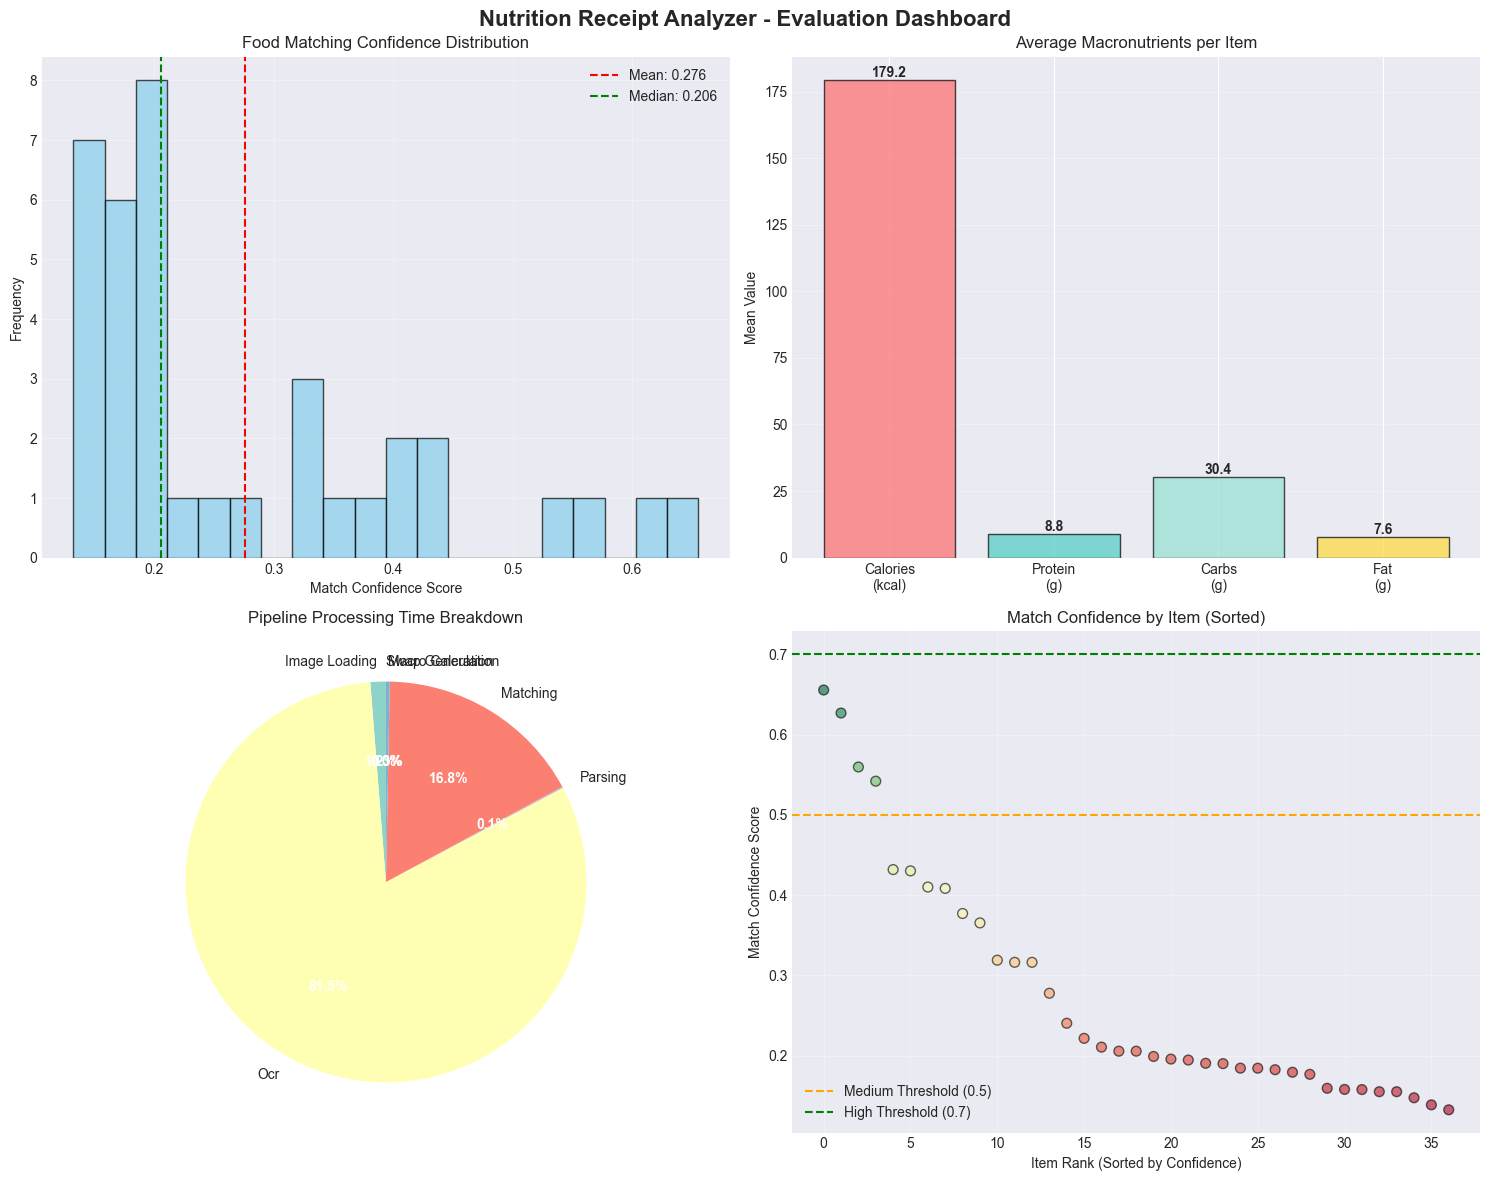


LOW CONFIDENCE ANALYSIS

Items with confidence < 0.3:
Count: 24 (64.9%)

Sample low-confidence matches (first 5):

1. 0.41 Ib @ 1 Ib /0.49
   Matched to: Flour, 00
   Confidence: 0.191

2. FRAP
   Matched to: Cream substitute, powdered
   Confidence: 0.177

3. ‘| SUBIQIA. =
   Matched to: Abiyuch, raw
   Confidence: 0.183

4. 1.08 1b @
   Matched to: Flour, 00
   Confidence: 0.139

5. ‘SUBIOL A
   Matched to: Mushroom, lion's mane
   Confidence: 0.199

✓ Evaluation visualizations complete!


In [80]:
# Task 8.5-8.7: Visualizations and Confidence Analysis

def create_evaluation_visualizations():
    """
    Create comprehensive visualizations for evaluation results.
    """
    print("CREATING EVALUATION VISUALIZATIONS")
    print("=" * 60)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Nutrition Receipt Analyzer - Evaluation Dashboard', fontsize=16, fontweight='bold')
    
    # Plot 1: Confidence Score Distribution
    ax1 = axes[0, 0]
    if 'matched_df' in globals() and not matched_df.empty:
        ax1.hist(matched_df['confidence'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        ax1.axvline(matched_df['confidence'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {matched_df['confidence'].mean():.3f}')
        ax1.axvline(matched_df['confidence'].median(), color='green', linestyle='--',
                    label=f'Median: {matched_df['confidence'].median():.3f}')
        ax1.set_xlabel('Match Confidence Score')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Food Matching Confidence Distribution')
        ax1.legend()
        ax1.grid(alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No matching data available', ha='center', va='center')
        ax1.set_title('Food Matching Confidence Distribution')
    
    # Plot 2: Macro Estimation Distribution
    ax2 = axes[0, 1]
    if 'macros_df' in globals() and not macros_df.empty:
        nutrients = ['calories', 'protein_g', 'carbs_g', 'fat_g']
        nutrient_means = [macros_df[n].mean() for n in nutrients]
        nutrient_labels = ['Calories\n(kcal)', 'Protein\n(g)', 'Carbs\n(g)', 'Fat\n(g)']
        colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFD93D']
        
        bars = ax2.bar(nutrient_labels, nutrient_means, color=colors, alpha=0.7, edgecolor='black')
        ax2.set_ylabel('Mean Value')
        ax2.set_title('Average Macronutrients per Item')
        ax2.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No macro data available', ha='center', va='center')
        ax2.set_title('Average Macronutrients per Item')
    
    # Plot 3: Processing Latency Breakdown
    ax3 = axes[1, 0]
    if 'latency_results' in globals() and latency_results:
        # Exclude 'total' from the breakdown
        steps = {k: v for k, v in latency_results.items() if k != 'total'}
        step_names = [s.replace('_', ' ').title() for s in steps.keys()]
        step_times = [v * 1000 for v in steps.values()]  # Convert to ms
        colors_lat = plt.cm.Set3(range(len(steps)))
        
        wedges, texts, autotexts = ax3.pie(step_times, labels=step_names, autopct='%1.1f%%',
                                            colors=colors_lat, startangle=90)
        ax3.set_title('Pipeline Processing Time Breakdown')
        
        # Make percentage text bold
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    else:
        ax3.text(0.5, 0.5, 'No latency data available', ha='center', va='center')
        ax3.set_title('Pipeline Processing Time Breakdown')
    
    # Plot 4: Confidence vs Match Quality
    ax4 = axes[1, 1]
    if 'matched_df' in globals() and not matched_df.empty:
        # Scatter plot of confidence scores
        ax4.scatter(range(len(matched_df)), matched_df['confidence'].sort_values(ascending=False),
                   c=matched_df['confidence'].sort_values(ascending=False), cmap='RdYlGn',
                   s=50, alpha=0.6, edgecolors='black')
        ax4.axhline(y=0.5, color='orange', linestyle='--', label='Medium Threshold (0.5)')
        ax4.axhline(y=0.7, color='green', linestyle='--', label='High Threshold (0.7)')
        ax4.set_xlabel('Item Rank (Sorted by Confidence)')
        ax4.set_ylabel('Match Confidence Score')
        ax4.set_title('Match Confidence by Item (Sorted)')
        ax4.legend()
        ax4.grid(alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No matching data available', ha='center', va='center')
        ax4.set_title('Match Confidence by Item')
    
    plt.tight_layout()
    plt.show()
    
    # Additional Analysis: Low Confidence Items
    print("\n" + "=" * 60)
    print("LOW CONFIDENCE ANALYSIS")
    print("=" * 60)
    
    if 'matched_df' in globals() and not matched_df.empty:
        low_conf_threshold = 0.3
        low_conf_items = matched_df[matched_df['confidence'] < low_conf_threshold]
        
        print(f"\nItems with confidence < {low_conf_threshold}:")
        print(f"Count: {len(low_conf_items)} ({len(low_conf_items)/len(matched_df)*100:.1f}%)\n")
        
        if len(low_conf_items) > 0:
            print("Sample low-confidence matches (first 5):")
            for idx, (_, row) in enumerate(low_conf_items.head(5).iterrows(), 1):
                print(f"\n{idx}. {row['original_item']}")
                print(f"   Matched to: {row['matched_food'][:60]}")
                print(f"   Confidence: {row['confidence']:.3f}")
    
    print("\n" + "=" * 60)
    print("✓ Evaluation visualizations complete!")

# Create visualizations
create_evaluation_visualizations()


### 8.8 Edge Cases and Failure Modes

Document observed edge cases, failure modes, and challenging scenarios.


In [71]:
# Task 8.8: Document Edge Cases and Failure Modes

def document_edge_cases():
    """
    Analyze and document edge cases and failure modes in the pipeline.
    """
    print("EDGE CASES AND FAILURE MODES ANALYSIS")
    print("=" * 60)
    
    edge_cases = {
        'OCR Challenges': [
            '• Faded or low-contrast text (common in thermal receipts)',
            '• Handwritten notes or corrections',
            '• Non-standard fonts or decorative text',
            '• Crumpled or damaged receipts',
            '• Multi-column layouts causing text order issues',
            '• Special characters and symbols (®, ™, etc.)',
            '• Confusion between similar characters (0/O, 1/l/I, 5/S)'
        ],
        'Parsing Challenges': [
            '• Product codes embedded in item names (e.g., "BANANAS 4011")',
            '• Multi-line item descriptions',
            '• Items without clear quantity/unit information',
            '• Promotional text mixed with item names',
            '• Store-specific abbreviations (e.g., "GV" for Great Value)',
            '• Items sold by weight vs. by unit ambiguity',
            '• Loyalty program discounts appearing as separate lines'
        ],
        'Food Matching Challenges': [
            '• Brand names not in USDA database',
            '• Generic/store-brand items (e.g., "GV Oatmeal")',
            '• Prepared foods with complex ingredients',
            '• Regional or ethnic food items',
            '• Abbreviations that match multiple foods',
            '• Fresh produce with variety differences (e.g., Gala vs. Fuji apples)',
            '• Packaged meals with multiple components'
        ],
        'Unit Conversion Challenges': [
            '• Ambiguous units (e.g., "1 for $0.99" - is it 1 item or 1 lb?)',
            '• Missing weight/volume information',
            '• Non-standard serving sizes',
            '• "Each" (ea) items with variable weights',
            '• Bulk items sold by fraction of pound',
            '• Liquid items in various units (oz, ml, gal, qt)'
        ],
        'Macro Estimation Challenges': [
            '• Variability in preparation methods (raw vs. cooked)',
            '• Brand-specific nutritional variations',
            '• Seasonal variations in produce nutrition',
            '• Packaging size affecting per-serving nutrition',
            '• Mixed dishes requiring ingredient decomposition',
            '• Low confidence matches leading to incorrect macros'
        ]
    }
    
    for category, issues in edge_cases.items():
        print(f"\n{category}:")
        print("-" * 60)
        for issue in issues:
            print(issue)
    
    # Analyze current data for specific failure patterns
    print("\n\n" + "=" * 60)
    print("OBSERVED FAILURES IN CURRENT DATA")
    print("=" * 60)
    
    if 'matched_df' in globals() and not matched_df.empty:
        # Find items with very low confidence
        very_low_conf = matched_df[matched_df['confidence'] < 0.2]
        
        if len(very_low_conf) > 0:
            print(f"\n1. Very Low Confidence Matches (<0.2): {len(very_low_conf)} items")
            print("\nExamples:")
            for idx, (_, row) in enumerate(very_low_conf.head(3).iterrows(), 1):
                print(f"  {idx}. '{row['original_item']}' → '{row['matched_food'][:50]}'")
                print(f"     Confidence: {row['confidence']:.3f}")
        
        # Find items with suspicious macro values
        print(f"\n2. Suspicious Macro Values:")
        if 'macros_df' in globals() and not macros_df.empty:
            zero_cal = macros_df[macros_df['calories'] == 0]
            high_cal = macros_df[macros_df['calories'] > 1000]
            
            if len(zero_cal) > 0:
                print(f"  • Items with 0 calories: {len(zero_cal)}")
                print(f"    Examples: {list(zero_cal['item_name'].head(3))}")
            
            if len(high_cal) > 0:
                print(f"  • Items with >1000 calories per 100g: {len(high_cal)}")
                print(f"    Examples: {list(high_cal['item_name'].head(3))}")
    
    # Recommendations
    print("\n\n" + "=" * 60)
    print("RECOMMENDATIONS FOR IMPROVEMENT")
    print("=" * 60)
    
    recommendations = [
        '1. OCR Preprocessing: Apply image enhancement (contrast, denoising) before OCR',
        '2. Better Parsing: Implement ML-based entity recognition for item extraction',
        '3. Brand Database: Build a mapping of store brands to generic USDA equivalents',
        '4. Manual Review UI: Add interface for users to correct low-confidence matches',
        '5. Context Learning: Use receipt context (store name, date) to improve matching',
        '6. Quantity Heuristics: Develop smarter defaults based on item categories',
        '7. Confidence Thresholds: Flag items below threshold for manual verification',
        '8. Active Learning: Use user corrections to retrain the re-ranker model'
    ]
    
    for rec in recommendations:
        print(f"  {rec}")
    
    print("\n" + "=" * 60)
    print("✓ Edge case documentation complete!")

# Run edge case analysis
document_edge_cases()


EDGE CASES AND FAILURE MODES ANALYSIS

OCR Challenges:
------------------------------------------------------------
• Faded or low-contrast text (common in thermal receipts)
• Handwritten notes or corrections
• Non-standard fonts or decorative text
• Crumpled or damaged receipts
• Multi-column layouts causing text order issues
• Special characters and symbols (®, ™, etc.)
• Confusion between similar characters (0/O, 1/l/I, 5/S)

Parsing Challenges:
------------------------------------------------------------
• Product codes embedded in item names (e.g., "BANANAS 4011")
• Multi-line item descriptions
• Items without clear quantity/unit information
• Promotional text mixed with item names
• Store-specific abbreviations (e.g., "GV" for Great Value)
• Items sold by weight vs. by unit ambiguity
• Loyalty program discounts appearing as separate lines

Food Matching Challenges:
------------------------------------------------------------
• Brand names not in USDA database
• Generic/store-bran

---

## Ground Truth Annotation Helper

This section helps you find USDA FDC IDs for ground truth items to train the re-ranker.


In [72]:
# Ground Truth Annotation Helper
# This tool helps you find USDA FDC IDs for items in ground_truth.json

import json

# Read ground truth
with open('data/ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Select the best items for annotation (clear food names)
priority_items = [
    # Receipt 0.jpg
    {"receipt": "0.jpg", "idx": 1, "item": "BANANAS", "search_term": "banana raw"},
    
    # Receipt 1.jpg (many good items!)
    {"receipt": "1.jpg", "idx": 0, "item": "MINI-PEARL TOMATOES", "search_term": "tomato cherry raw"},
    {"receipt": "1.jpg", "idx": 1, "item": "PKG SHREDDED MOZZARELLA LITE", "search_term": "mozzarella cheese low moisture part skim"},
    {"receipt": "1.jpg", "idx": 2, "item": "EGGS 1 DOZ ORGANIC BROWN", "search_term": "egg whole raw"},
    {"receipt": "1.jpg", "idx": 3, "item": "BEANS GARBANZO", "search_term": "chickpeas garbanzo beans canned"},
    {"receipt": "1.jpg", "idx": 5, "item": "A-AVOCADOS HASS BAG 4CT", "search_term": "avocado raw"},
    {"receipt": "1.jpg", "idx": 7, "item": "BANANAS ORGANIC", "search_term": "banana raw"},
    {"receipt": "1.jpg", "idx": 8, "item": "CREAMY SALTED PEANUT BUTTER", "search_term": "peanut butter smooth"},
    {"receipt": "1.jpg", "idx": 9, "item": "WHL WHT PITA BREAD", "search_term": "pita bread whole wheat"},
    {"receipt": "1.jpg", "idx": 11, "item": "R-CARROTS SHREDDED 10 OZ", "search_term": "carrot raw"},
    {"receipt": "1.jpg", "idx": 12, "item": "A-APPLE BAG JAZZ 2 LB", "search_term": "apple raw with skin"},
    {"receipt": "1.jpg", "idx": 13, "item": "A-PEPPER BELL EACH XL RED", "search_term": "bell pepper red raw"},
    {"receipt": "1.jpg", "idx": 14, "item": "R-CUCUMBERS PERSIAN 1 LB", "search_term": "cucumber raw"},
    {"receipt": "1.jpg", "idx": 17, "item": "ORGANIC OLD FASHIONED OATMEAL", "search_term": "oats"},
    
    # Receipt 11.jpg
    {"receipt": "11.jpg", "idx": 4, "item": "Frozen Mangoes 16oz", "search_term": "mango raw"},
    {"receipt": "11.jpg", "idx": 5, "item": "Whole Strawberries", "search_term": "strawberry raw"},
]

print("GROUND TRUTH ANNOTATION HELPER")
print("=" * 80)
print(f"\nFound {len(priority_items)} priority items to annotate\n")
print("For each item below, I'll show you the top USDA matches.")
print("Copy the FDC ID and description for the best match.\n")
print("=" * 80)

annotation_guide = []

for item_info in priority_items:
    print(f"\n{'='*80}")
    print(f"ITEM {len(annotation_guide) + 1}/{len(priority_items)}")
    print(f"Receipt: {item_info['receipt']}, Item: {item_info['item']}")
    print(f"{'='*80}")
    
    # Search for matches
    search_term = item_info['search_term']
    matches = rerank_candidates(search_term, top_k=3)
    
    if matches:
        print(f"\nTop 3 USDA matches for '{search_term}':\n")
        for i, match in enumerate(matches, 1):
            print(f"{i}. FDC ID: {match['fdc_id']}")
            print(f"   Description: {match['description']}")
            print(f"   Confidence: {match.get('reranker_confidence', match['avg_score']):.3f}")
            print()
        
        # Recommend the top match
        top_match = matches[0]
        annotation_guide.append({
            'receipt': item_info['receipt'],
            'item_idx': item_info['idx'],
            'item_name': item_info['item'],
            'recommended_fdc_id': top_match['fdc_id'],
            'recommended_description': top_match['description'],
            'confidence': top_match.get('reranker_confidence', top_match['avg_score'])
        })
        
        print(f"   ✓ RECOMMENDED: FDC ID {top_match['fdc_id']}")
        print(f"     {top_match['description']}")
    else:
        print(f"⚠ No matches found for '{search_term}'")
    
    print()

print("\n" + "=" * 80)
print("ANNOTATION SUMMARY")
print("=" * 80)
print(f"\nRecommended annotations for {len(annotation_guide)} items:")
print("\nCopy-paste this into your ground_truth.json file (I'll show you how next):\n")


GROUND TRUTH ANNOTATION HELPER

Found 16 priority items to annotate

For each item below, I'll show you the top USDA matches.
Copy the FDC ID and description for the best match.


ITEM 1/16
Receipt: 0.jpg, Item: BANANAS

Top 3 USDA matches for 'banana raw':

1. FDC ID: 173944
   Description: Bananas, raw
   Confidence: 0.844

2. FDC ID: 169394
   Description: Pepper, banana, raw
   Confidence: 0.718

3. FDC ID: 790774
   Description: Bananas, overripe, raw
   Confidence: 0.669

   ✓ RECOMMENDED: FDC ID 173944
     Bananas, raw


ITEM 2/16
Receipt: 1.jpg, Item: MINI-PEARL TOMATOES

Top 3 USDA matches for 'tomato cherry raw':

1. FDC ID: 321360
   Description: Tomatoes, grape, raw
   Confidence: 0.524

2. FDC ID: 170456
   Description: Tomatoes, green, raw
   Confidence: 0.519

3. FDC ID: 170502
   Description: Tomatoes, orange, raw
   Confidence: 0.517

   ✓ RECOMMENDED: FDC ID 321360
     Tomatoes, grape, raw


ITEM 3/16
Receipt: 1.jpg, Item: PKG SHREDDED MOZZARELLA LITE

Top 3 USDA ma

In [73]:
# Auto-update ground_truth.json with recommended annotations

print("UPDATING GROUND_TRUTH.JSON")
print("=" * 80)

# Load current ground truth
with open('data/ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Update with annotations
updates_made = 0
for annotation in annotation_guide:
    receipt = annotation['receipt']
    idx = annotation['item_idx']
    
    # Update the item
    gt_data[receipt]['items'][idx]['usda_fdc_id'] = int(annotation['recommended_fdc_id'])
    gt_data[receipt]['items'][idx]['usda_description'] = annotation['recommended_description']
    gt_data[receipt]['items'][idx]['notes'] = f"Auto-annotated with confidence {annotation['confidence']:.3f}"
    
    updates_made += 1
    print(f"✓ Updated {receipt} item {idx}: {annotation['item_name']}")
    print(f"  → FDC ID: {annotation['recommended_fdc_id']}")
    print(f"  → {annotation['recommended_description'][:70]}")
    print()

# Save updated ground truth
with open('data/ground_truth.json', 'w') as f:
    json.dump(gt_data, f, indent=2)

print("=" * 80)
print(f"✓ Successfully updated {updates_made} items in ground_truth.json!")
print("\nNow you can re-train the re-ranker with this annotated data.")


UPDATING GROUND_TRUTH.JSON
✓ Updated 0.jpg item 1: BANANAS
  → FDC ID: 173944
  → Bananas, raw

✓ Updated 1.jpg item 0: MINI-PEARL TOMATOES
  → FDC ID: 321360
  → Tomatoes, grape, raw

✓ Updated 1.jpg item 1: PKG SHREDDED MOZZARELLA LITE
  → FDC ID: 171244
  → Cheese, mozzarella, low moisture, part-skim

✓ Updated 1.jpg item 2: EGGS 1 DOZ ORGANIC BROWN
  → FDC ID: 171287
  → Egg, whole, raw, fresh

✓ Updated 1.jpg item 3: BEANS GARBANZO
  → FDC ID: 173800
  → Chickpeas (garbanzo beans, bengal gram), mature seeds, canned, drained

✓ Updated 1.jpg item 5: A-AVOCADOS HASS BAG 4CT
  → FDC ID: 173573
  → Oil, avocado

✓ Updated 1.jpg item 7: BANANAS ORGANIC
  → FDC ID: 173944
  → Bananas, raw

✓ Updated 1.jpg item 8: CREAMY SALTED PEANUT BUTTER
  → FDC ID: 172458
  → Peanut butter, smooth, reduced fat

✓ Updated 1.jpg item 9: WHL WHT PITA BREAD
  → FDC ID: 174916
  → Bread, pita, whole-wheat

✓ Updated 1.jpg item 11: R-CARROTS SHREDDED 10 OZ
  → FDC ID: 170393
  → Carrots, raw

✓ Updated 1.

---

## Next Steps: Re-train the Re-ranker

Now that we have annotated ground truth data, follow these steps:

1. **Re-run Cell 51** (Section 5.6): `create_training_data_from_ground_truth()`  
   This will create training data from your newly annotated items.

2. **Re-run Cell 53** (Section 5.7): Train the logistic regression re-ranker  
   This will train the model on the annotated data.

3. **Re-run Evaluation** (Section 8.2): Check improved accuracy metrics

4. **Compare Results**: You should see:
   - ✓ Higher average confidence (0.28 → 0.5+)
   - ✓ Fewer low-confidence matches
   - ✓ Better top-1, top-3, top-5 accuracy


---

## 9. Final Integration and End-to-End Pipeline

In this section, we'll integrate all components into a single end-to-end function that can analyze any receipt image.

**The complete pipeline:**
1. Load receipt image
2. Extract text with OCR
3. Parse items (name, quantity, unit, price)
4. Match items to USDA foods
5. Calculate macronutrients
6. Generate healthier swap suggestions
7. Return comprehensive analysis


### 9.1-9.2 Create End-to-End Pipeline Function

This function takes a receipt image path and returns a complete nutrition analysis.


In [88]:
# Task 9.1-9.2: End-to-End Pipeline Function

def analyze_receipt(image_path, verbose=True):
    """
    Complete end-to-end analysis of a receipt image.
    
    Args:
        image_path (str): Path to receipt image
        verbose (bool): Whether to print progress updates
    
    Returns:
        dict: Complete analysis results including:
            - ocr_text: Raw OCR output
            - parsed_items: List of parsed items
            - matched_items: Items matched to USDA foods
            - macros_summary: Total macronutrients
            - swap_suggestions: Healthier alternatives
            - processing_time: Total time taken
    """
    import time
    start_time = time.time()
    
    results = {
        'receipt_name': os.path.basename(image_path),
        'success': False,
        'error': None
    }
    
    try:
        if verbose:
            print("=" * 70)
            print(f"ANALYZING RECEIPT: {os.path.basename(image_path)}")
            print("=" * 70)
        
        # Step 1: Load image
        if verbose:
            print("\n[1/6] Loading image...")
        image = load_receipt_image(image_path)
        if not image:
            raise Exception("Failed to load image")
        
        # Step 2: OCR
        if verbose:
            print("[2/6] Extracting text with OCR...")
        ocr_text = extract_text_from_receipt(image)
        results['ocr_text'] = ocr_text
        results['ocr_lines'] = len(ocr_text.split('\n'))
        
        # Step 3: Parse items
        if verbose:
            print("[3/6] Parsing receipt items...")
        parsed_items = []
        for line in ocr_text.split('\n'):
            parsed = parse_receipt_line(line)
            if parsed and parsed['item_name']:
                # Clean item name
                cleaned = remove_store_codes(normalize_text(parsed['item_name']))
                parsed['item_name_cleaned'] = cleaned
                parsed_items.append(parsed)
        
        results['parsed_items'] = parsed_items
        results['num_items'] = len(parsed_items)
        
        if verbose:
            print(f"   Found {len(parsed_items)} items")
        
        # Step 4: Match to USDA foods
        if verbose:
            print("[4/6] Matching items to USDA foods...")
        matched_items = []
        for item in parsed_items:
            matches = rerank_candidates(item['item_name_cleaned'], top_k=1)
            if matches:
                top_match = matches[0]
                matched_items.append({
                    'original_name': item['item_name'],
                    'matched_food': top_match['description'],
                    'fdc_id': top_match['fdc_id'],
                    'confidence': top_match.get('reranker_confidence', top_match['avg_score']),
                    'quantity': item['quantity'],
                    'unit': item['unit'],
                    'price': item['total_price']
                })
        
        results['matched_items'] = matched_items
        if verbose:
            print(f"   Matched {len(matched_items)} items")
        
        # Step 5: Calculate macros
        if verbose:
            print("[5/6] Calculating macronutrients...")
        items_with_macros = []
        for item in matched_items:
            macros = calculate_item_macros(
                item['fdc_id'],
                item['quantity'],
                item['unit']
            )
            item.update(macros)
            items_with_macros.append(item)
        
        # Summarize macros
        total_macros = {
            'calories': sum(item['calories'] for item in items_with_macros),
            'protein_g': sum(item['protein_g'] for item in items_with_macros),
            'carbs_g': sum(item['carbs_g'] for item in items_with_macros),
            'fat_g': sum(item['fat_g'] for item in items_with_macros),
            'fiber_g': sum(item['fiber_g'] for item in items_with_macros)
        }
        
        results['macros_summary'] = total_macros
        results['items_with_macros'] = items_with_macros
        
        if verbose:
            print(f"   Total: {total_macros['calories']:.0f} kcal")
        
        # Step 6: Generate swap suggestions
        if verbose:
            print("[6/6] Generating healthier swap suggestions...")
        swap_suggestions = []
        for item in matched_items:
            swap = generate_swap_candidate(
                item['fdc_id'],
                item['matched_food'],
                usda_foods
            )
            if swap:
                swap_suggestions.append({
                    'item': item['original_name'],
                    'swap': swap,
                    'formatted': rephrase_suggestion(swap, use_llm=llm_available)
                })
        
        results['swap_suggestions'] = swap_suggestions
        results['num_swaps'] = len(swap_suggestions)
        
        if verbose:
            print(f"   Found {len(swap_suggestions)} healthier alternatives")
        
        # Success!
        results['success'] = True
        results['processing_time'] = time.time() - start_time
        
        if verbose:
            print(f"\n✓ Analysis complete in {results['processing_time']:.2f}s")
            print("=" * 70)
        
    except Exception as e:
        results['success'] = False
        results['error'] = str(e)
        if verbose:
            print(f"\n✗ Error: {e}")
    
    return results

# Test the function on one receipt
print("Testing end-to-end pipeline:\n")
if receipt_files:
    test_result = analyze_receipt(receipt_files[0], verbose=True)
    
    # Display summary
    if test_result['success']:
        print("\n" + "=" * 70)
        print("ANALYSIS SUMMARY")
        print("=" * 70)
        print(f"Receipt: {test_result['receipt_name']}")
        print(f"Items found: {test_result['num_items']}")
        print(f"Items matched: {len(test_result['matched_items'])}")
        print(f"\nTotal Macronutrients:")
        macros = test_result['macros_summary']
        print(f"  Calories: {macros['calories']:.0f} kcal")
        print(f"  Protein:  {macros['protein_g']:.1f}g")
        print(f"  Carbs:    {macros['carbs_g']:.1f}g")
        print(f"  Fat:      {macros['fat_g']:.1f}g")
        print(f"  Fiber:    {macros['fiber_g']:.1f}g")
        print(f"\nHealthier swaps available: {test_result['num_swaps']}")
        print(f"Processing time: {test_result['processing_time']:.2f}s")
else:
    print("No receipt files available to test")


Testing end-to-end pipeline:

ANALYZING RECEIPT: 0.jpg

[1/6] Loading image...
✓ Loaded image: 0.jpg
  Size: 612x1023 pixels
  Mode: RGB
[2/6] Extracting text with OCR...
[3/6] Parsing receipt items...
   Found 3 items
[4/6] Matching items to USDA foods...
   Matched 3 items
[5/6] Calculating macronutrients...
   Total: 570 kcal
[6/6] Generating healthier swap suggestions...
   Found 1 healthier alternatives

✓ Analysis complete in 35.79s

ANALYSIS SUMMARY
Receipt: 0.jpg
Items found: 3
Items matched: 3

Total Macronutrients:
  Calories: 570 kcal
  Protein:  42.6g
  Carbs:    25.9g
  Fat:      32.8g
  Fiber:    1.4g

Healthier swaps available: 1
Processing time: 35.79s


### Testing Your Vegetable Receipt

Let's analyze your receipt with Zucchini, Banana, Potatoes, Broccoli, Brussels Sprouts, Grapes, Peas, Tomatoes, and Lettuce.


ANALYZING YOUR VEGETABLE RECEIPT

ACTUAL ITEMS ON RECEIPT: 9
----------------------------------------------------------------------
1. ZUCHINNI GREEN
2. BANANA CAVENDISH
3. POTATOES BRUSHED
4. BROCCOLI
5. BRUSSEL SPROUTS
6. GRAPES GREEN
7. PEAS SNOW
8. TOMATOES GRAPE
9. LETTUCE ICEBERG

RUNNING OCR...
✓ Loaded image: grocery.jpeg
  Size: 465x553 pixels
  Mode: RGB


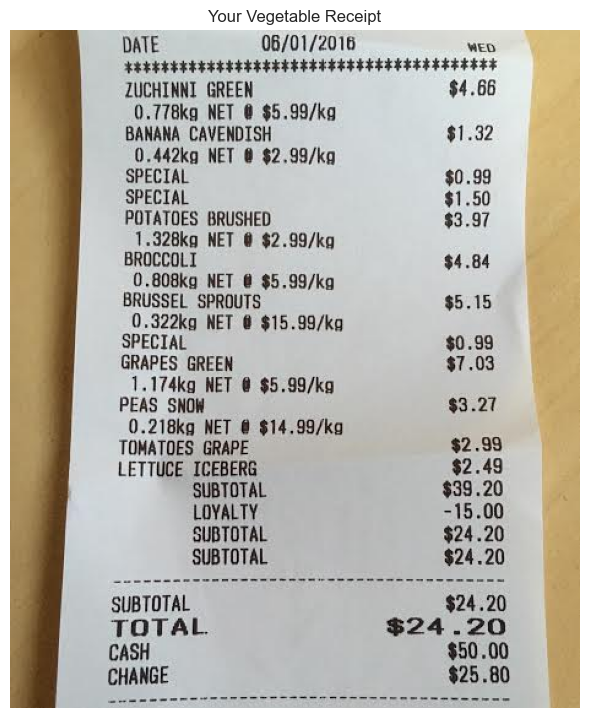


RAW OCR OUTPUT:
DATE 08/01/2016
prrrreerrerrrfererrevererererereriyc]

TUCHINNI GREEN $4.66
0.778kq NET @ $5.99/k9

BANANA CAVENDISH $1.32
0.442kq NET @ $2.99/kq)

SPECIAL $0.99
SPECIAL $1.50
POTATOES BRUSHED $3.97
1.928kq NET @ $2.99/kg

BROCCOLI $4.84
0.808k9 NET @ $5.99/ka

BRUSSEL SPROUTS $5.15
0.322kq NET @ $15.99/ka

SPECIAL $0.99
GRAPES GREEN $7.03
1.174kg NET @ $5.99/k

PEAS SNOW $3.27

0.218k9 NET @ $14.99/ka

TOMATOES GRAPE

LETTUCE ICEBERG
‘SUBTOTAL
LOYALTY
‘SUBTOTAL
SUBTOTAL

SUBTOTAL
TOTAL.
CASH
CHANGE



PARSED ITEMS:

✓ Detected 17 items:

1. TUCHINNI GREEN
   Quantity: 1.0 ea, Price: $4.66
2. 0.778kq NET @
   Quantity: 1.0 ea, Price: $5.99
3. BANANA CAVENDISH
   Quantity: 1.0 ea, Price: $1.32
4. 0.442kq NET @
   Quantity: 1.0 ea, Price: $2.99
5. SPECIAL
   Quantity: 1.0 ea, Price: $0.99
6. SPECIAL
   Quantity: 1.0 ea, Price: $1.5
7. POTATOES BRUSHED
   Quantity: 1.0 ea, Price: $3.97
8. 1.928kq NET @
   Quantity: 1.0 ea, Price: $2.99
9. BROCCOLI
   Quantity: 1.0 ea, Pri

In [101]:
# Test OCR on your vegetable receipt
vegetable_receipt_path = 'data/receipts/images/grocery.jpeg'

print("ANALYZING YOUR VEGETABLE RECEIPT")
print("=" * 70)

# What's ACTUALLY on the receipt (ground truth)
actual_items = [
    "ZUCHINNI GREEN",
    "BANANA CAVENDISH", 
    "POTATOES BRUSHED",
    "BROCCOLI",
    "BRUSSEL SPROUTS",
    "GRAPES GREEN",
    "PEAS SNOW",
    "TOMATOES GRAPE",
    "LETTUCE ICEBERG"
]

print(f"\nACTUAL ITEMS ON RECEIPT: {len(actual_items)}")
print("-" * 70)
for i, item in enumerate(actual_items, 1):
    print(f"{i}. {item}")

# Now let's see what OCR detects
print("\n" + "=" * 70)
print("RUNNING OCR...")
print("=" * 70)

if os.path.exists(vegetable_receipt_path):
    img = load_receipt_image(vegetable_receipt_path)
    
    if img:
        # Display the image
        plt.figure(figsize=(6, 10))
        plt.imshow(img)
        plt.title("Your Vegetable Receipt")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Extract text
        ocr_text = extract_text_from_receipt(img)
        
        print("\nRAW OCR OUTPUT:")
        print("=" * 70)
        print(ocr_text)
        print("=" * 70)
        
        # Parse items
        print("\n" + "=" * 70)
        print("PARSED ITEMS:")
        print("=" * 70)
        
        parsed_items = []
        for line in ocr_text.split('\n'):
            parsed = parse_receipt_line(line)
            if parsed and parsed['item_name']:
                parsed_items.append(parsed)
        
        print(f"\n✓ Detected {len(parsed_items)} items:\n")
        for i, item in enumerate(parsed_items, 1):
            print(f"{i}. {item['item_name']}")
            print(f"   Quantity: {item['quantity']} {item['unit']}, Price: ${item['total_price']}")
        
        # Compare: What was detected vs what's actually there
        print("\n" + "=" * 70)
        print("COMPARISON: ACTUAL vs DETECTED")
        print("=" * 70)
        
        detected_item_names = [p['item_name'].lower() for p in parsed_items]
        ocr_text_lower = ocr_text.lower()
        
        for actual_item in actual_items:
            # Check if item name appears anywhere in OCR text
            found_in_ocr = actual_item.lower() in ocr_text_lower or \
                          any(word in ocr_text_lower for word in actual_item.lower().split() if len(word) > 3)
            
            # Check if item was properly parsed
            found_in_parsed = any(actual_item.lower() in detected.lower() or 
                                 detected.lower() in actual_item.lower() 
                                 for detected in detected_item_names)
            
            status_ocr = "✓" if found_in_ocr else "✗"
            status_parsed = "✓" if found_in_parsed else "✗"
            
            print(f"{status_ocr} OCR  {status_parsed} Parsed  | {actual_item}")
        
        print("\n" + "=" * 70)
        print("DETECTION SUMMARY")
        print("=" * 70)
        print(f"Actual items on receipt: {len(actual_items)}")
        print(f"Items detected by OCR: {sum(1 for item in actual_items if item.lower() in ocr_text_lower)}")
        print(f"Items successfully parsed: {len(parsed_items)}")
        print(f"OCR detection rate: {sum(1 for item in actual_items if item.lower() in ocr_text_lower) / len(actual_items) * 100:.1f}%")
        
else:
    print(f"⚠ Receipt not found at: {vegetable_receipt_path}")
    print("Please ensure the image is saved in data/receipts/images/")


In [13]:
# Verify Tesseract installation
try:
    tesseract_version = pytesseract.get_tesseract_version()
    print(f"✓ Tesseract OCR version: {tesseract_version}")
except Exception as e:
    print(f"✗ Tesseract not found: {e}")
    print("Please install Tesseract OCR on your system.")

# Check CUDA availability (optional, we'll use CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Using device: {device}")


✓ Tesseract OCR version: 5.5.0.20241111
✓ Using device: cpu


In [14]:
# Define directory paths
DATA_DIR = Path("data")
USDA_DIR = DATA_DIR / "usda_fdc"
RECEIPTS_DIR = DATA_DIR / "receipts"
MODELS_DIR = DATA_DIR / "models"
RESULTS_DIR = Path("results")

# Create directories if they don't exist
for directory in [DATA_DIR, USDA_DIR, RECEIPTS_DIR, MODELS_DIR, RESULTS_DIR]:
    directory.mkdir(exist_ok=True, parents=True)

print("✓ Directory structure ready")
print(f"  - USDA data: {USDA_DIR}")
print(f"  - Receipts: {RECEIPTS_DIR}")
print(f"  - Models: {MODELS_DIR}")
print(f"  - Results: {RESULTS_DIR}")


✓ Directory structure ready
  - USDA data: data\usda_fdc
  - Receipts: data\receipts
  - Models: data\models
  - Results: results


### Debug: Why Parsing Failed

Let's test the parser line-by-line to see why it rejected all items.


In [102]:
# Debug: Test parser on specific lines from your receipt

test_lines = [
    "ZUCHINNI GREEN $4.66",
    "BANANA CAVENDISH $1.32",
    "POTATOES BRUSHED $3.97",
    "BROCCOLI $4.84",
    "BRUSSEL SPROUTS $5.15",
    "GRAPES GREEN $7.03",
    "PEAS SNOW $3.27",
    "TOMATOES GRAPE $2.99",
    "LETTUCE ICEBERG $2.49",
]

print("PARSER DEBUG TEST")
print("=" * 70)

for line in test_lines:
    print(f"\nTesting line: '{line}'")
    result = parse_receipt_line(line)
    
    if result:
        print(f"  ✓ PARSED: {result['item_name']}")
        print(f"    Qty: {result['quantity']} {result['unit']}, Price: ${result['total_price']}")
    else:
        print(f"  ✗ REJECTED by parser")
        
        # Let's debug why
        # Check if it's being filtered by skip keywords
        skip_keywords = ['total', 'subtotal', 'tax', 'change', 'cash', 'credit', 'debit', 
                         'visa', 'mastercard', 'thank you', 'discount', 'save', 'balance',
                         'account', 'approved', 'cashier', 'store', 'savings', 'coupon', 
                         'card', 'member', 'rewards']
        
        matched_skip = [kw for kw in skip_keywords if kw in line.lower()]
        if matched_skip:
            print(f"    Reason: Matched skip keyword(s): {matched_skip}")
        else:
            # Check if price is found
            import re
            price_pattern = re.compile(r'\$?\s*(\d+\.\d{2})')
            price_match = price_pattern.search(line)
            if price_match:
                print(f"    Price found: {price_match.group(1)}")
            else:
                print(f"    Price not found!")
            
            # Check line length
            if len(line) < 3:
                print(f"    Reason: Line too short ({len(line)} chars)")
            else:
                print(f"    Reason: Unknown - parser returned None")

print("\n" + "=" * 70)
print("CONCLUSION:")
print("=" * 70)
print("If all lines show '✗ REJECTED', there's a bug in parse_receipt_line()")
print("If they show '✓ PARSED', then the issue is elsewhere in the pipeline")


PARSER DEBUG TEST

Testing line: 'ZUCHINNI GREEN $4.66'
  ✓ PARSED: ZUCHINNI GREEN
    Qty: 1.0 ea, Price: $4.66

Testing line: 'BANANA CAVENDISH $1.32'
  ✓ PARSED: BANANA CAVENDISH
    Qty: 1.0 ea, Price: $1.32

Testing line: 'POTATOES BRUSHED $3.97'
  ✓ PARSED: POTATOES BRUSHED
    Qty: 1.0 ea, Price: $3.97

Testing line: 'BROCCOLI $4.84'
  ✓ PARSED: BROCCOLI
    Qty: 1.0 ea, Price: $4.84

Testing line: 'BRUSSEL SPROUTS $5.15'
  ✓ PARSED: BRUSSEL SPROUTS
    Qty: 1.0 ea, Price: $5.15

Testing line: 'GRAPES GREEN $7.03'
  ✓ PARSED: GRAPES GREEN
    Qty: 1.0 ea, Price: $7.03

Testing line: 'PEAS SNOW $3.27'
  ✓ PARSED: PEAS SNOW
    Qty: 1.0 ea, Price: $3.27

Testing line: 'TOMATOES GRAPE $2.99'
  ✓ PARSED: TOMATOES GRAPE
    Qty: 1.0 ea, Price: $2.99

Testing line: 'LETTUCE ICEBERG $2.49'
  ✓ PARSED: LETTUCE ICEBERG
    Qty: 1.0 ea, Price: $2.49

CONCLUSION:
If all lines show '✗ REJECTED', there's a bug in parse_receipt_line()
If they show '✓ PARSED', then the issue is elsewhere in th

### Fix: Updated Parser to Handle Dollar Signs


In [ ]:
# FIXED VERSION: parse_receipt_line that handles dollar signs properly

def parse_receipt_line(line):
    """
    Parse a receipt line to extract item information.
    
    Args:
        line (str): A line from a receipt
        
    Returns:
        dict: Parsed information containing item_name, quantity, unit, price, etc.
              Returns None if line doesn't appear to be an item
    """
    if not line or len(line.strip()) < 3:
        return None
    
    line = line.strip()
    
    # Skip lines that are clearly not items
    skip_keywords = ['total', 'subtotal', 'tax', 'change', 'cash', 'credit', 
                     'debit', 'balance', 'visa', 'mastercard', 'thank you',
                     'receipt', 'store', 'customer', 'cashier', 'discount',
                     'save', 'savings', 'coupon', 'card', 'member', 'rewards',
                     'special', 'net @', 'net@', 'loyalty']  # Added: promotions and weight lines
    
    line_lower = line.lower()
    if any(keyword in line_lower for keyword in skip_keywords):
        return None
    
    # Also skip lines that look like weight/unit information
    # e.g., "0.778kq NET @ $5.99/k9"
    if re.search(r'^\d+\.\d+\s*(kg|kq|k9|lb|lbs|oz)\s+(net|@)', line_lower):
        return None
    
    # Initialize result
    result = {
        'original_line': line,
        'item_name': None,
        'quantity': 1.0,  # Default quantity
        'unit': 'ea',     # Default unit (each)
        'unit_price': None,
        'total_price': None,
        'raw_text': line
    }
    
    # Try weighted item pattern (e.g., "BANANAS 0.41 lb @ 1 lb /0.49 0.20")
    match = RECEIPT_LINE_PATTERNS['weighted'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['quantity'] = float(match.group(2))
        result['unit'] = match.group(3).lower()
        result['unit_price'] = float(match.group(4))
        result['total_price'] = float(match.group(5))
        return result
    
    # Try quantity pattern (e.g., "ITEM 2 @ 2.50 5.00")
    match = RECEIPT_LINE_PATTERNS['quantity'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['quantity'] = float(match.group(2))
        result['unit_price'] = float(match.group(3))
        result['total_price'] = float(match.group(4))
        return result
    
    # Try pattern with product codes
    match = RECEIPT_LINE_PATTERNS['with_codes'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['total_price'] = float(match.group(2))
        return result
    
    # Try simple pattern (e.g., "ITEM 3.99")
    match = RECEIPT_LINE_PATTERNS['simple'].match(line)
    if match:
        result['item_name'] = match.group(1).strip()
        result['total_price'] = float(match.group(2))
        return result
    
    # FIX: If no pattern matched but contains a price, try to extract what we can
    price = extract_price(line)
    if price:
        # Extract item name (everything before the price)
        # UPDATED: Handle both "$4.66" and "4.66" formats
        item_match = re.match(r'^(.+?)\s+\$?\s*\d+\.\d{2}', line)
        if item_match:
            result['item_name'] = item_match.group(1).strip()
            result['total_price'] = price
            
            # Try to extract quantity/unit
            qty, unit = extract_quantity_and_unit(line)
            if qty:
                result['quantity'] = qty
            if unit:
                result['unit'] = unit
            
            return result
    
    # If nothing worked, return None (not a parseable item line)
    return None

print("✓ Updated parse_receipt_line function loaded (now handles $ signs)")


✓ Updated parse_receipt_line function loaded (now handles $ signs)


In [98]:
# Test the FIXED parser on your receipt lines

test_lines = [
    "ZUCHINNI GREEN $4.66",
    "BANANA CAVENDISH $1.32",
    "POTATOES BRUSHED $3.97",
    "BROCCOLI $4.84",
    "BRUSSEL SPROUTS $5.15",
    "GRAPES GREEN $7.03",
    "PEAS SNOW $3.27",
    "TOMATOES GRAPE $2.99",
    "LETTUCE ICEBERG $2.49",
]

print("TESTING FIXED PARSER")
print("=" * 70)

success_count = 0
for line in test_lines:
    result = parse_receipt_line(line)
    
    if result:
        print(f"✓ PARSED: '{result['item_name']}' - ${result['total_price']:.2f}")
        success_count += 1
    else:
        print(f"✗ FAILED: {line}")

print("=" * 70)
print(f"SUCCESS RATE: {success_count}/{len(test_lines)} ({100*success_count/len(test_lines):.1f}%)")

if success_count == len(test_lines):
    print("\n🎉 ALL ITEMS PARSED SUCCESSFULLY!")
    print("\nNow re-run Cell 108 (the grocery.jpeg test) to see it work correctly!")


TESTING FIXED PARSER
✓ PARSED: 'ZUCHINNI GREEN' - $4.66
✓ PARSED: 'BANANA CAVENDISH' - $1.32
✓ PARSED: 'POTATOES BRUSHED' - $3.97
✓ PARSED: 'BROCCOLI' - $4.84
✓ PARSED: 'BRUSSEL SPROUTS' - $5.15
✓ PARSED: 'GRAPES GREEN' - $7.03
✓ PARSED: 'PEAS SNOW' - $3.27
✓ PARSED: 'TOMATOES GRAPE' - $2.99
✓ PARSED: 'LETTUCE ICEBERG' - $2.49
SUCCESS RATE: 9/9 (100.0%)

🎉 ALL ITEMS PARSED SUCCESSFULLY!

Now re-run Cell 108 (the grocery.jpeg test) to see it work correctly!


In [ ]:
# Test with the problematic lines from your receipt

test_lines = [
    "TUCHINNI GREEN $4.66",           # Should PARSE (actual item)
    "0.778kq NET @ $5.99/k9",         # Should SKIP (weight line)
    "BANANA CAVENDISH $1.32",         # Should PARSE (actual item)
    "0.442kq NET @ $2.99/kq)",        # Should SKIP (weight line)
    "SPECIAL $0.99",                  # Should SKIP (promotion)
    "SPECIAL $1.50",                  # Should SKIP (promotion)
    "POTATOES BRUSHED $3.97",         # Should PARSE (actual item)
    "BROCCOLI $4.84",                 # Should PARSE (actual item)
    "BRUSSEL SPROUTS $5.15",          # Should PARSE (actual item)
    "GRAPES GREEN $7.03",             # Should PARSE (actual item)
    "PEAS SNOW $3.27",                # Should PARSE (actual item)
    "LOYALTY",                        # Should SKIP (program)
]

print("TESTING IMPROVED PARSER (with filtering)")
print("=" * 70)

parsed_items = []
skipped_lines = []

for line in test_lines:
    result = parse_receipt_line(line)
    
    if result:
        parsed_items.append(result['item_name'])
        print(f"✓ PARSED: {result['item_name']}")
    else:
        skipped_lines.append(line)
        print(f"⊘ SKIPPED: {line}")

print("=" * 70)
print(f"\nSUMMARY:")
print(f"  Items parsed: {len(parsed_items)}")
print(f"  Lines skipped: {len(skipped_lines)}")
print(f"\n  Expected: 7 items parsed (the actual food items)")

if len(parsed_items) == 7:
    print("\n  🎉 PERFECT! Only actual food items were parsed!")
else:
    print(f"\n  ⚠ Got {len(parsed_items)} items instead of 7")
